#**Step 1: Install All the Required Packages**

In [ ]:
!pip3 install -q -U bitsandbytes==0.42.0
!pip3 install -q -U peft==0.8.2
!pip3 install -q -U trl==0.7.10
!pip3 install -q -U accelerate==0.27.1
!pip3 install -q -U datasets==2.17.0
!pip3 install -q -U transformers==4.38.1

#**Step 2: Import All the Required Libraries**

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from google.colab import userdata
from datasets import load_dataset
from transformers import (

    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    Trainer,
    GemmaTokenizer
)
from peft import LoraConfig, PeftModel
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)

In [ ]:
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

#**Step 3**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import transformers
from trl import SFTTrainer

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "google/gemma-1.1-7b-it"


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_name, token=os.environ['HF_TOKEN'])
model = AutoModelForCausalLM.from_pretrained(
    model_name, quantization_config=bnb_config, device_map={"":0}, token=os.environ['HF_TOKEN'])

# Fine-tuned model name
new_model = "gemma-1.1-7b-it-finetune"


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)
dataset = load_dataset("SadiaAfreen1048/codeVulnerability")
dataset = dataset.map(lambda samples: tokenizer(samples["func"]), batched=True)

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['func', 'input_ids', 'attention_mask'],
        num_rows: 2100
    })
})


In [ ]:
print(dataset['train'][0]['func'])

Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [qemuProcessHandleReset(qemuMonitorPtr mon G_GNUC_UNUSED,
                       virDomainObjPtr vm,
                       void *opaque)
{
    virQEMUDriverPtr driver = opaque;
    virObjectEventPtr event;
    qemuDomainObjPrivatePtr priv;
    g_autoptr(virQEMUDriverConfig) cfg = virQEMUDriverGetConfig(driver);
    int ret = -1;

    virObjectLock(vm);

    event = virDomainEventRebootNewFromObj(vm);
    priv = vm->privateData;
    if (priv->agent)
        qemuAgentNotifyEvent(priv->agent, QEMU_AGENT_EVENT_RESET);

    if (virDomainObjSave(vm, driver->xmlopt, cfg->stateDir) < 0)
        VIR_WARN("Failed to save status on vm %s", vm->def->name);

    if (vm->def->onReboot == VIR_DOMAIN_LIFECYCLE_ACTION_DESTROY ||
        vm->def->onReboot == VIR_DOMAIN_LIF

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    dataset_text_field='func',
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    peft_config=lora_config,
)
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:223: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:290: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
1,3.755600
2,4.417400
3,2.760900
4,6.418800
5,5.164700
6,3.204800
7,2.381600
8,4.149700
9,3.122700
10,1.928100


TrainOutput(global_step=10, training_loss=3.7304439187049865, metrics={'train_runtime': 20.5684, 'train_samples_per_second': 1.945, 'train_steps_per_second': 0.486, 'total_flos': 1155939693312000.0, 'train_loss': 3.7304439187049865, 'epoch': 0.02})

In [ ]:
print(model)

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3072, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=3072, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3072, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
         

In [ ]:
# Save trained model
trainer.model.save_pretrained('/content/drive/MyDrive/gemma/'+new_model)

##**Step 5: Check the plots on tensorboard, as follows**

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir results/runs

In [ ]:
import gc
for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()
gc.collect()

0

In [ ]:
X_test = pd.read_csv('/content/drive/MyDrive/gemma/data/test_data.csv')
y_true = pd.read_csv('/content/drive/MyDrive/gemma/data/y_true.csv')

In [ ]:
print(X_test.iloc[0]["func"])

Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TEST_F(QueryPlannerTest, SparseIndexCanSupportGTEOrLTENull) {
    params.options &= ~QueryPlannerParams::INCLUDE_COLLSCAN;
    addIndex(BSON("i" << 1),
             false,  // multikey
             true    // sparse
    );

    runQuery(fromjson("{i: {$gte: null}}"));
    assertNumSolutions(1U);
    assertSolutionExists(
        "{fetch: {filter: {i: {$gte: null}}, node: {ixscan: {pattern: "
        "{i: 1}, bounds: {i: [[null,null,true,true]]}}}}}");

    runQuery(fromjson("{i: {$lte: null}}"));
    assertNumSolutions(1U);
    assertSolutionExists(
        "{fetch: {filter: {i: {$lte: null}}, node: {ixscan: {pattern: "
        "{i: 1}, bounds: {i: [[null,null,true,true]]}}}}}");
}]

Response:


In [ ]:
# Maximum length allowed for sequences
max_length = 1024

# Function to clip sequences
def clip_sequence(sequence):
    tokens = tokenizer.tokenize(sequence)
    if len(tokens) > max_length:
        return None
    clipped_tokens = tokens[:max_length]  # Account for [CLS] and [SEP] tokens
    return tokenizer.convert_tokens_to_string(clipped_tokens)

# Clip sequences in the DataFrame
X_test['func'] = X_test['func'].apply(clip_sequence)

# Filter out None values
X_test = X_test.dropna()

# Randomly select 300 data points
random_indices = X_test.sample(n=300, random_state=42).index
X_test = X_test.loc[random_indices]
y_true = y_true.loc[random_indices]

# y_true = y_true.loc[X_test.index]  # Align y_true with the filtered X_test indices

# Print the updated DataFrame
print(X_test)
print(y_true)

                                                  func
456  Instruction:\nAnalyze the code of the program ...
364  Instruction:\nAnalyze the code of the program ...
737  Instruction:\nAnalyze the code of the program ...
143  Instruction:\nAnalyze the code of the program ...
26   Instruction:\nAnalyze the code of the program ...
..                                                 ...
435  Instruction:\nAnalyze the code of the program ...
35   Instruction:\nAnalyze the code of the program ...
49   Instruction:\nAnalyze the code of the program ...
78   Instruction:\nAnalyze the code of the program ...
34   Instruction:\nAnalyze the code of the program ...

[300 rows x 1 columns]
     label
456      0
364      1
737      0
143      1
26       0
..     ...
435      0
35       1
49       0
78       1
34       0

[300 rows x 1 columns]


In [ ]:
print(X_test.shape)

(300, 1)


In [ ]:
print(X_test.iloc[1].values[0])


Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int decode_last_significant_coeff_prefix(thread_context* tctx,
						int log2TrafoSize,
						int cIdx,
						context_model* model)
{
  logtrace(LogSlice,"# last_significant_coeff_prefix log2TrafoSize:%d cIdx:%d\n",log2TrafoSize,cIdx);

  int cMax = (log2TrafoSize<<1)-1;

  int ctxOffset, ctxShift;
  if (cIdx==0) {
    ctxOffset = 3*(log2TrafoSize-2) + ((log2TrafoSize-1)>>2);
    ctxShift  = (log2TrafoSize+1)>>2;
  }
  else {
    ctxOffset = 15;
    ctxShift  = log2TrafoSize-2;
  }

  int binIdx;
  int value = cMax;
  for (binIdx=0;binIdx<cMax;binIdx++)
    {
      int ctxIdxInc = (binIdx >> ctxShift);

      logtrace(LogSlice,"context: %d+%d\n",ctxOffset,ctxIdxInc);

      int bit = decode_CABAC_bit(&tctx->cabac_decoder, &model[ctxOffset + ctxIdxI

In [ ]:
# prompt: print the first value of y_true without name or other shape info

print(y_true.iloc[1].values[0])


0


In [ ]:
text = X_test.iloc[55]["func"]
device = "cuda:0"
inputs = tokenizer(text, return_tensors="pt").to(device)
with torch.cuda.amp.autocast():
  outputs = model.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [
static inline bool skb_irq_freeable(const struct sk_buff *skb)
{
	return !skb->destructor &&
#if IS_ENABLED(CONFIG_XFRM)
		!skb->sp &&
#endif
		!skb_nfct(skb) &&
		!skb->_skb_refdst &&
		!skb_has_frag_list(skb);]

Response:
0


In [ ]:
def predict(test, model, tokenize):
    y_pred = []
    device = "cuda:0"
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["func"]
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.cuda.amp.autocast():
          outputs = model.generate(**inputs, max_new_tokens=10)
        result = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print('result: '+result)
        answer = result.split("Response:")[-1]
        print("Answer: "+answer)
        print("True Answer: ")
        print(y_true.iloc[i].values[0])
        if "1" in answer:
            y_pred.append("1")
        elif "0" in answer:
            y_pred.append("0")
        else:
            y_pred.append("0")
    return y_pred

In [ ]:
y_pred = predict(X_test, model, tokenizer)

  0%|          | 1/300 [00:02<14:20,  2.88s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void acm_read_buffers_free(struct acm *acm)
{
	int i;

	for (i = 0; i < acm->rx_buflimit; i++)
		usb_free_coherent(acm->dev, acm->readsize,
			  acm->read_buffers[i].base, acm->read_buffers[i].dma);
}]

Response:
0
Answer: 
0
True Answer: 
0


  1%|          | 2/300 [00:05<14:13,  2.87s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void bootp_input(struct mbuf *m)
{
    struct bootp_t *bp = mtod(m, struct bootp_t *);

    if (bp->bp_op == BOOTP_REQUEST) {
        bootp_reply(m->slirp, bp);
    }
}]

Response:
0
Answer: 
0
True Answer: 
1


  1%|          | 3/300 [00:08<14:26,  2.92s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [AddOtherUsers(buf, len, p)
char *buf;
int len;
struct win *p;
{
  struct display *d, *olddisplay = display;
  struct canvas *cv;
  char *s;
  int l;

  s = buf;
  for (display = displays; display; display = display->d_next)
    {
      if (olddisplay && D_user == olddisplay->d_user)
	continue;
      for (cv = D_cvlist; cv; cv = cv->c_next)
	if (Layer2Window(cv->c_layer) == p)
	  break;
      if (!cv)
	continue;
      for (d = displays; d && d != display; d = d->d_next)
	if (D_user == d->d_user)
	  break;
      if (d && d != display)
	continue;
      if (len > 1 && s != buf)
	{
	  *s++ = ',';
	  len--;
	}
      l = strlen(D_user->u_name);
      if (l + 1 > len)
	break;
      strcpy(s, D_user->u_name);
      s += l;
      len -= l;
    }
  *s = 0;
 

  1%|▏         | 4/300 [00:11<14:42,  2.98s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [extern "C" void *malloc_wrapper(struct _reent *r, size_t size, void *caller)
{
    void *ptr = NULL;
#ifdef MBED_MEM_TRACING_ENABLED
    mbed_mem_trace_lock();
#endif
#ifdef MBED_HEAP_STATS_ENABLED
    malloc_stats_mutex->lock();
    alloc_info_t *alloc_info = (alloc_info_t *)__real__malloc_r(r, size + sizeof(alloc_info_t));
    if (alloc_info != NULL) {
        alloc_info->size = size;
        alloc_info->signature = MBED_HEAP_STATS_SIGNATURE;
        ptr = (void *)(alloc_info + 1);
        heap_stats.current_size += size;
        heap_stats.total_size += size;
        heap_stats.alloc_cnt += 1;
        if (heap_stats.current_size > heap_stats.max_size) {
            heap_stats.max_size = heap_stats.current_size;
        }
        heap_stats.over

  2%|▏         | 5/300 [00:21<26:15,  5.34s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [socket_ref_state_set (AtkObject *accessible)
{
  char *child_name, *child_path;
  AtkSocket *socket = ATK_SOCKET (accessible);
  int count = 0;
  int j;
  int v;
  DBusMessage *message, *reply;
  DBusMessageIter iter, iter_array;
  AtkStateSet *set;

  set = atk_state_set_new ();

  if (!socket->embedded_plug_id)
    return set;

  child_name = g_strdup (socket->embedded_plug_id);
  if (!child_name)
    return set;
  child_path = g_utf8_strchr (child_name + 1, -1, ':');
  if (!child_path)
    {
      g_free (child_name);
      return set;
    }
  *(child_path++) = '\0';
  message = dbus_message_new_method_call (child_name, child_path, ATSPI_DBUS_INTERFACE_ACCESSIBLE, "GetState");
  g_free (child_name);
  reply = dbus_connection_send_with_reply_and

  2%|▏         | 6/300 [00:24<22:09,  4.52s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [		void CWebServer::Cmd_GetLanguage(WebEmSession & session, const request& req, Json::Value &root)
		{
			std::string sValue;
			if (m_sql.GetPreferencesVar("Language", sValue))
			{
				root["status"] = "OK";
				root["title"] = "GetLanguage";
				root["language"] = sValue;
			}
		}]

Response:
0
Answer: 
0
True Answer: 
0


  2%|▏         | 7/300 [00:27<19:29,  3.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [LogFilePrep(const char *fname, const char *backup, const char *idstring)
{
    char *logFileName = NULL;

    if (asprintf(&logFileName, fname, idstring) == -1)
        FatalError("Cannot allocate space for the log file name\n");

    if (backup && *backup) {
        struct stat buf;

        if (!stat(logFileName, &buf) && S_ISREG(buf.st_mode)) {
            char *suffix;
            char *oldLog;

            if ((asprintf(&suffix, backup, idstring) == -1) ||
                (asprintf(&oldLog, "%s%s", logFileName, suffix) == -1)) {
                FatalError("Cannot allocate space for the log file name\n");
            }
            free(suffix);

            if (rename(logFileName, oldLog) == -1) {
                FatalError("Cannot move old lo

  3%|▎         | 8/300 [00:30<17:44,  3.65s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [krb5_gss_process_context_token(minor_status, context_handle,
                               token_buffer)
    OM_uint32 *minor_status;
    gss_ctx_id_t context_handle;
    gss_buffer_t token_buffer;
{
    krb5_gss_ctx_id_rec *ctx;
    OM_uint32 majerr;

    ctx = (krb5_gss_ctx_id_t) context_handle;

    if (ctx->terminated || !ctx->established) {
        *minor_status = KG_CTX_INCOMPLETE;
        return(GSS_S_NO_CONTEXT);
    }

    /* We only support context deletion tokens for now, and RFC 4121 does not
     * define a context deletion token. */
    if (ctx->proto) {
        *minor_status = 0;
        return(GSS_S_DEFECTIVE_TOKEN);
    }

    /* "unseal" the token */

    if (GSS_ERROR(majerr = kg_unseal(minor_status, context_handle,
           

  3%|▎         | 9/300 [00:33<16:54,  3.48s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void execlists_cancel_requests(struct intel_engine_cs *engine)
{
	struct intel_engine_execlists * const execlists = &engine->execlists;
	struct i915_request *rq, *rn;
	struct rb_node *rb;
	unsigned long flags;

	GEM_TRACE("%s\n", engine->name);

	/*
	 * Before we call engine->cancel_requests(), we should have exclusive
	 * access to the submission state. This is arranged for us by the
	 * caller disabling the interrupt generation, the tasklet and other
	 * threads that may then access the same state, giving us a free hand
	 * to reset state. However, we still need to let lockdep be aware that
	 * we know this state may be accessed in hardirq context, so we
	 * disable the irq around this manipulation and we want to keep
	 * the spinlock foc

  3%|▎         | 10/300 [00:42<25:49,  5.34s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void gen_prov_cont(struct prov_rx *rx, struct net_buf_simple *buf)
{
	uint8_t seg = CONT_SEG_INDEX(rx->gpc);

	BT_DBG("len %u, seg_index %u", buf->len, seg);

	if (!link.rx.seg && link.rx.id == rx->xact_id) {
		if (!ack_pending()) {
			BT_DBG("Resending ack");
			gen_prov_ack_send(rx->xact_id);
		}

		return;
	}

	if (!link.rx.seg &&
	    next_transaction_id(link.rx.id) == rx->xact_id) {
		BT_DBG("Start segment lost");

		link.rx.id = rx->xact_id;

		net_buf_simple_reset(link.rx.buf);

		link.rx.seg = SEG_NVAL;
		link.rx.last_seg = SEG_NVAL;

		prov_clear_tx();
	} else if (rx->xact_id != link.rx.id) {
		BT_WARN("Data for unknown transaction (0x%x != 0x%x)",
				rx->xact_id, link.rx.id);
		return;
	}

	if (seg > link.rx.last_seg) {
		BT_ERR(

  4%|▎         | 11/300 [00:45<22:24,  4.65s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int setup_order(THD *thd, Ref_ptr_array ref_pointer_array, TABLE_LIST *tables,
                List<Item> &fields, List<Item> &all_fields, ORDER *order,
                bool from_window_spec)
{ 
  SELECT_LEX *select = thd->lex->current_select;
  enum_parsing_place context_analysis_place=
                     thd->lex->current_select->context_analysis_place;
  thd->where="order clause";
  const bool for_union= select->master_unit()->is_unit_op() &&
    select == select->master_unit()->fake_select_lex;
  for (uint number = 1; order; order=order->next, number++)
  {
    if (find_order_in_list(thd, ref_pointer_array, tables, order, fields,
                           all_fields, false, true, from_window_spec))
      return 1;
    Item * const item= *or

  4%|▍         | 12/300 [00:48<20:00,  4.17s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [UserNameIterator AuthorizationSessionImpl::getImpersonatedUserNames() {
    return makeUserNameIterator(_impersonatedUserNames.begin(), _impersonatedUserNames.end());
}]

Response:
0
Answer: 
0
True Answer: 
0


  4%|▍         | 13/300 [00:51<18:04,  3.78s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [dwarf_addr_form_is_indexed(int form)
{
    switch(form) {
    case DW_FORM_addrx:
    case DW_FORM_addrx1:
    case DW_FORM_addrx2:
    case DW_FORM_addrx3:
    case DW_FORM_addrx4:
    case DW_FORM_GNU_addr_index:
    case DW_FORM_LLVM_addrx_offset:
        return TRUE;
    default: break;
    }
    return FALSE;
}]

Response:
0
Answer: 
0
True Answer: 
0


  5%|▍         | 14/300 [00:54<16:39,  3.50s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void destroy_att_disconn(void *data)
{
	struct att_disconn *disconn = data;

	if (disconn->destroy)
		disconn->destroy(disconn->user_data);

	free(disconn);
}]

Response:
0
Answer: 
0
True Answer: 
0


  5%|▌         | 15/300 [00:57<15:49,  3.33s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [add_bitset(regex_t* reg, BitSetRef bs)
{
  BB_ADD(reg, bs, SIZE_BITSET);
  return 0;
}]

Response:
0
Answer: 
0
True Answer: 
0


  5%|▌         | 16/300 [01:00<15:19,  3.24s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [*/
PHP_METHOD(DateInterval, __construct)
{
	char *interval_string = NULL;
	int   interval_string_length;
	php_interval_obj *diobj;
	timelib_rel_time *reltime;
	zend_error_handling error_handling;
	
	zend_replace_error_handling(EH_THROW, NULL, &error_handling TSRMLS_CC);
	if (zend_parse_parameters(ZEND_NUM_ARGS() TSRMLS_CC, "s", &interval_string, &interval_string_length) == SUCCESS) {
		if (date_interval_initialize(&reltime, interval_string, interval_string_length TSRMLS_CC) == SUCCESS) {
			diobj = zend_object_store_get_object(getThis() TSRMLS_CC);
			diobj->diff = reltime;
			diobj->initialized = 1;
		} else {
			ZVAL_NULL(getThis());
		}
	}
	zend_restore_error_handling(&error_handling TSRMLS_CC);]

Response:
0
Answer: 
0
True Answer: 
0


  6%|▌         | 17/300 [01:10<24:14,  5.14s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TEST_P(Http2RingHashIntegrationTest, CookieRoutingWithCookieWithTtlSet) {
  config_helper_.addConfigModifier(
      [&](envoy::config::filter::network::http_connection_manager::v2::HttpConnectionManager& hcm)
          -> void {
        auto* hash_policy = hcm.mutable_route_config()
                                ->mutable_virtual_hosts(0)
                                ->mutable_routes(0)
                                ->mutable_route()
                                ->add_hash_policy();
        auto* cookie = hash_policy->mutable_cookie();
        cookie->set_name("foo");
        cookie->mutable_ttl()->set_seconds(15);
      });

  std::set<std::string> served_by;
  sendMultipleRequests(
      1024,
      Http::TestHeaderMapImpl{{":method", 

  6%|▌         | 18/300 [01:13<21:17,  4.53s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ALWAYS_INLINE void MulAdd3Way(const Packet a1, const Packet a2, const Packet a3,
                              const bfloat16** binp1, const bfloat16** binp2,
                              const bfloat16** binp3, float** out) {
  auto inp1 = reinterpret_cast<const float*>(*binp1);
  auto inp2 = reinterpret_cast<const float*>(*binp2);
  auto inp3 = reinterpret_cast<const float*>(*binp3);
  auto c1 = LOAD(*out);
  auto c2 = LOAD(*out + kNumOperands);
  const auto b1 = LOAD(inp1);
  EXPAND_BFLOAT_L(b1, b1_0);
  EXPAND_BFLOAT_U(b1, b1_1);
  *binp1 += 2 * kNumOperands;
  const auto b2 = LOAD(inp2);
  EXPAND_BFLOAT_L(b2, b2_0);
  EXPAND_BFLOAT_U(b2, b2_1);
  *binp2 += 2 * kNumOperands;
  const auto b3 = LOAD(inp3);
  EXPAND_BFLOAT_L(b3, b3_0);
  EXPAND_

  6%|▋         | 19/300 [01:16<18:52,  4.03s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void vrend_texture_barrier(UNUSED struct vrend_context *ctx,
                           unsigned flags)
{
   if (has_feature(feat_texture_barrier) && (flags & PIPE_TEXTURE_BARRIER_SAMPLER))
      glTextureBarrier();
   if (has_feature(feat_blend_equation_advanced) && (flags & PIPE_TEXTURE_BARRIER_FRAMEBUFFER))
      glBlendBarrierKHR();
}]

Response:
0
Answer: 
0
True Answer: 
0


  7%|▋         | 20/300 [01:21<21:23,  4.58s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [pebs_update_state(bool needed_cb, struct cpu_hw_events *cpuc,
		  struct perf_event *event, bool add)
{
	struct pmu *pmu = event->ctx->pmu;
	/*
	 * Make sure we get updated with the first PEBS
	 * event. It will trigger also during removal, but
	 * that does not hurt:
	 */
	bool update = cpuc->n_pebs == 1;

	if (needed_cb != pebs_needs_sched_cb(cpuc)) {
		if (!needed_cb)
			perf_sched_cb_inc(pmu);
		else
			perf_sched_cb_dec(pmu);

		update = true;
	}

	/*
	 * The PEBS record doesn't shrink on pmu::del(). Doing so would require
	 * iterating all remaining PEBS events to reconstruct the config.
	 */
	if (x86_pmu.intel_cap.pebs_baseline && add) {
		u64 pebs_data_cfg;

		/* Clear pebs_data_cfg and pebs_record_size for first PEBS. */
		if (cpuc->n_peb

  7%|▋         | 21/300 [01:24<19:10,  4.12s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [hb_buffer_ensure( HB_Buffer buffer,
		   HB_UInt   size )
{
  HB_UInt new_allocated = buffer->allocated;

  if (size > new_allocated)
    {
      HB_Error error;

      while (size > new_allocated)
	new_allocated += (new_allocated >> 1) + 8;

      if ( buffer->positions )
        {
	  if ( REALLOC_ARRAY( buffer->positions, new_allocated, HB_PositionRec ) )
	    return error;
	}

      if ( REALLOC_ARRAY( buffer->in_string, new_allocated, HB_GlyphItemRec ) )
	return error;

      if ( buffer->separate_out )
        {
	  if ( REALLOC_ARRAY( buffer->alt_string, new_allocated, HB_GlyphItemRec ) )
	    return error;

	  buffer->out_string = buffer->alt_string;
	}
      else
        {
	  buffer->out_string = buffer->in_string;

	  if ( buffer->alt_stri

  7%|▋         | 22/300 [01:27<17:28,  3.77s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static u8 mcps_data_request(
	u8               src_addr_mode,
	u8               dst_address_mode,
	u16              dst_pan_id,
	union macaddr   *dst_addr,
	u8               msdu_length,
	u8              *msdu,
	u8               msdu_handle,
	u8               tx_options,
	struct secspec  *security,
	void            *device_ref
)
{
	struct secspec *psec;
	struct mac_message command;

	command.command_id = SPI_MCPS_DATA_REQUEST;
	command.pdata.data_req.src_addr_mode = src_addr_mode;
	command.pdata.data_req.dst.mode = dst_address_mode;
	if (dst_address_mode != MAC_MODE_NO_ADDR) {
		command.pdata.data_req.dst.pan_id[0] = LS_BYTE(dst_pan_id);
		command.pdata.data_req.dst.pan_id[1] = MS_BYTE(dst_pan_id);
		if (dst_address_mode == MAC_MODE_SHORT_ADDR) {


  8%|▊         | 23/300 [01:30<16:09,  3.50s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [GF_Err iKMS_box_read(GF_Box *s, GF_BitStream *bs)
{
	u32 len;
	GF_ISMAKMSBox *ptr = (GF_ISMAKMSBox *)s;

	len = (u32) (ptr->size);
	ptr->URI = (char*) gf_malloc(sizeof(char)*len);
	if (!ptr->URI) return GF_OUT_OF_MEM;
	gf_bs_read_data(bs, ptr->URI, len);
	return GF_OK;
}]

Response:
0
Answer: 
0
True Answer: 
0


  8%|▊         | 24/300 [01:33<15:22,  3.34s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int sctp_wait_for_sndbuf(struct sctp_association *asoc, long *timeo_p,
				size_t msg_len)
{
	struct sock *sk = asoc->base.sk;
	int err = 0;
	long current_timeo = *timeo_p;
	DEFINE_WAIT(wait);

	pr_debug("%s: asoc:%p, timeo:%ld, msg_len:%zu\n", __func__, asoc,
		 *timeo_p, msg_len);

	/* Increment the association's refcnt.  */
	sctp_association_hold(asoc);

	/* Wait on the association specific sndbuf space. */
	for (;;) {
		prepare_to_wait_exclusive(&asoc->wait, &wait,
					  TASK_INTERRUPTIBLE);
		if (!*timeo_p)
			goto do_nonblock;
		if (sk->sk_err || asoc->state >= SCTP_STATE_SHUTDOWN_PENDING ||
		    asoc->base.dead)
			goto do_error;
		if (signal_pending(current))
			goto do_interrupted;
		if (msg_len <= sctp_wspace(asoc))
			break;

	

  8%|▊         | 25/300 [01:36<14:54,  3.25s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [const Address *HttpDownstreamConnection::get_raddr() const { return raddr_; }]

Response:
0
Answer: 
0
True Answer: 
0


  9%|▊         | 26/300 [01:39<14:26,  3.16s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [BGD_DECLARE(int) gdImagePaletteToTrueColor(gdImagePtr src)
{
	unsigned int y;
	unsigned int yy;

	if (src == NULL) {
		return 0;
	}

	if (src->trueColor == 1) {
		return 1;
	} else {
		unsigned int x;
		const unsigned int sy = gdImageSY(src);
		const unsigned int sx = gdImageSX(src);

		src->tpixels = (int **) gdMalloc(sizeof(int *) * sy);
		if (src->tpixels == NULL) {
			return 0;
		}

		for (y = 0; y < sy; y++) {
			const unsigned char *src_row = src->pixels[y];
			int * dst_row;

			/* no need to calloc it, we overwrite all pxl anyway */
			src->tpixels[y] = (int *) gdMalloc(sx * sizeof(int));
			if (src->tpixels[y] == NULL) {
				goto clean_on_error;
			}

			dst_row = src->tpixels[y];
			for (x = 0; x < sx; x++) {
				const unsigned char c = 

  9%|▉         | 27/300 [01:42<13:57,  3.07s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TEST_F(QueryPlannerTest, SparseIndexCanSupportGTEOrLTENull) {
    params.options &= ~QueryPlannerParams::INCLUDE_COLLSCAN;
    addIndex(BSON("i" << 1),
             false,  // multikey
             true    // sparse
    );

    runQuery(fromjson("{i: {$gte: null}}"));
    assertNumSolutions(1U);
    assertSolutionExists(
        "{fetch: {filter: {i: {$gte: null}}, node: {ixscan: {pattern: "
        "{i: 1}, bounds: {i: [[null,null,true,true]]}}}}}");

    runQuery(fromjson("{i: {$lte: null}}"));
    assertNumSolutions(1U);
    assertSolutionExists(
        "{fetch: {filter: {i: {$lte: null}}, node: {ixscan: {pattern: "
        "{i: 1}, bounds: {i: [[null,null,true,true]]}}}}}");
}]

Response:
0
Answer: 
0
True Answer: 
1


  9%|▉         | 28/300 [01:52<22:48,  5.03s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [psutil_disk_partitions(PyObject *self, PyObject *args) {
    FILE *file = NULL;
    struct mntent * mt = NULL;
    PyObject *py_dev = NULL;
    PyObject *py_mountp = NULL;
    PyObject *py_tuple = NULL;
    PyObject *py_retlist = PyList_New(0);

    if (py_retlist == NULL)
        return NULL;

    file = setmntent(MNTTAB, "rb");
    if (file == NULL) {
        PyErr_SetFromErrno(PyExc_OSError);
        goto error;
    }
    mt = getmntent(file);
    while (mt != NULL) {
        py_dev = PyUnicode_DecodeFSDefault(mt->mnt_fsname);
        if (! py_dev)
            goto error;
        py_mountp = PyUnicode_DecodeFSDefault(mt->mnt_dir);
        if (! py_mountp)
            goto error;
        py_tuple = Py_BuildValue(
            "(OOss)",
          

 10%|▉         | 29/300 [01:55<19:48,  4.38s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int cmm_oom_notify(struct notifier_block *self,
			  unsigned long dummy, void *parm)
{
	unsigned long *freed = parm;
	long nr = 256;

	nr = cmm_free_pages(nr, &cmm_timed_pages, &cmm_timed_page_list);
	if (nr > 0)
		nr = cmm_free_pages(nr, &cmm_pages, &cmm_page_list);
	cmm_pages_target = cmm_pages;
	cmm_timed_pages_target = cmm_timed_pages;
	*freed += 256 - nr;
	return NOTIFY_OK;
}]

Response:
0
Answer: 
0
True Answer: 
0


 10%|█         | 30/300 [01:57<17:41,  3.93s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [read_random_source( int requester, size_t length, int level )
{
    static int (*fnc)(void (*)(const void*, size_t, int), int,
						    size_t, int) = NULL;
    if( !fnc ) {
	if( !is_initialized )
	    initialize();
	fnc = getfnc_gather_random();
	if( !fnc ) {
	    faked_rng = 1;
	    fnc = gather_faked;
	}
	if( !requester && !length && !level )
	    return; /* init only */
    }
    if( (*fnc)( add_randomness, requester, length, level ) < 0 )
	log_fatal("No way to gather entropy for the RNG\n");
}]

Response:
0
Answer: 
0
True Answer: 
0


 10%|█         | 31/300 [02:01<16:34,  3.70s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void atalk_register_sysctl(void)
{
	atalk_table_header = register_net_sysctl(&init_net, "net/appletalk", atalk_table);
}]

Response:
0
Answer: 
0
True Answer: 
1


 11%|█         | 32/300 [02:04<15:23,  3.45s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int bson_check_string( bson *b, const char *string,
                       const int length ) {

    return bson_validate_string( b, ( const unsigned char * )string, length, 1, 0, 0 );
}]

Response:
0
Answer: 
0
True Answer: 
1


 11%|█         | 33/300 [02:06<14:32,  3.27s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [iakerb_gss_wrap_iov_length(OM_uint32 *minor_status,
                           gss_ctx_id_t context_handle, int conf_req_flag,
                           gss_qop_t qop_req, int *conf_state,
                           gss_iov_buffer_desc *iov, int iov_count)
{
    iakerb_ctx_id_t ctx = (iakerb_ctx_id_t)context_handle;

    if (ctx->gssc == GSS_C_NO_CONTEXT)
        return GSS_S_NO_CONTEXT;

    return krb5_gss_wrap_iov_length(minor_status, ctx->gssc, conf_req_flag,
                                    qop_req, conf_state, iov, iov_count);
}]

Response:
0
Answer: 
0
True Answer: 
0


 11%|█▏        | 34/300 [02:16<22:59,  5.19s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [psutil_disk_io_counters(PyObject *self, PyObject *args) {
    kstat_ctl_t *kc;
    kstat_t *ksp;
    kstat_io_t kio;
    PyObject *py_retdict = PyDict_New();
    PyObject *py_disk_info = NULL;

    if (py_retdict == NULL)
        return NULL;
    kc = kstat_open();
    if (kc == NULL) {
        PyErr_SetFromErrno(PyExc_OSError);;
        goto error;
    }
    ksp = kc->kc_chain;
    while (ksp != NULL) {
        if (ksp->ks_type == KSTAT_TYPE_IO) {
            if (strcmp(ksp->ks_class, "disk") == 0) {
                if (kstat_read(kc, ksp, &kio) == -1) {
                    kstat_close(kc);
                    return PyErr_SetFromErrno(PyExc_OSError);;
                }
                py_disk_info = Py_BuildValue(
                    "(IIKKLL)",

 12%|█▏        | 35/300 [02:26<28:56,  6.55s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [    kssl_keytab_is_available(KSSL_CTX *kssl_ctx)
{
    krb5_context		krb5context = NULL;
    krb5_keytab 		krb5keytab = NULL;
    krb5_keytab_entry           entry;
    krb5_principal              princ = NULL;
    krb5_error_code  		krb5rc = KRB5KRB_ERR_GENERIC;
    int rc = 0;

    if ((krb5rc = krb5_init_context(&krb5context)))
        return(0);

    /*	kssl_ctx->keytab_file == NULL ==> use Kerberos default
    */
    if (kssl_ctx->keytab_file)
    {
        krb5rc = krb5_kt_resolve(krb5context, kssl_ctx->keytab_file,
                                  &krb5keytab);
        if (krb5rc)
            goto exit;
    }
    else
    {
        krb5rc = krb5_kt_default(krb5context,&krb5keytab);
        if (krb5rc)
            goto exit;
    }

    /* t

 12%|█▏        | 36/300 [02:29<23:58,  5.45s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void hci_le_adv_report_evt(struct hci_dev *hdev, struct sk_buff *skb)
{
	u8 num_reports = skb->data[0];
	void *ptr = &skb->data[1];

	hci_dev_lock(hdev);

	while (num_reports--) {
		struct hci_ev_le_advertising_info *ev = ptr;
		s8 rssi;

		if (ev->length <= HCI_MAX_AD_LENGTH) {
			rssi = ev->data[ev->length];
			process_adv_report(hdev, ev->evt_type, &ev->bdaddr,
					   ev->bdaddr_type, NULL, 0, rssi,
					   ev->data, ev->length, false);
		} else {
			bt_dev_err(hdev, "Dropping invalid advertising data");
		}

		ptr += sizeof(*ev) + ev->length + 1;
	}

	hci_dev_unlock(hdev);
}]

Response:
0
Answer: 
0
True Answer: 
0


 12%|█▏        | 37/300 [02:32<20:29,  4.68s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [std::shared_ptr<SQLiteDBInstance> getTestDBC() {
  auto dbc = SQLiteDBManager::getUnique();
  char* err = nullptr;
  std::vector<std::string> queries = {
      "CREATE TABLE test_table (username varchar(30) primary key, age int)",
      "INSERT INTO test_table VALUES (\"mike\", 23)",
      "INSERT INTO test_table VALUES (\"matt\", 24)"};

  for (auto q : queries) {
    sqlite3_exec(dbc->db(), q.c_str(), nullptr, nullptr, &err);
    if (err != nullptr) {
      throw std::domain_error(std::string("Cannot create testing DBC's db: ") +
                              err);
    }
  }

  return dbc;
}]

Response:
0
Answer: 
0
True Answer: 
1


 13%|█▎        | 38/300 [02:34<18:03,  4.14s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [bool TR_table::open()
{
  DBUG_ASSERT(!table);
  open_tables_backup= new Open_tables_backup;
  if (!open_tables_backup)
  {
    my_error(ER_OUT_OF_RESOURCES, MYF(0));
    return true;
  }

  All_tmp_tables_list *temporary_tables= thd->temporary_tables;
  bool error= !open_log_table(thd, this, open_tables_backup);
  thd->temporary_tables= temporary_tables;

  if (use_transaction_registry == MAYBE)
    error= check(error);

  use_transaction_registry= error ? NO : YES;

  return error;
}]

Response:
0
Answer: 
0
True Answer: 
0


 13%|█▎        | 39/300 [02:38<16:48,  3.87s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [networkstatus_format_signatures(networkstatus_t *consensus,
                                int for_detached_signatures)
{
  smartlist_t *elements;
  char buf[4096];
  char *result = NULL;
  int n_sigs = 0;
  const consensus_flavor_t flavor = consensus->flavor;
  const char *flavor_name = networkstatus_get_flavor_name(flavor);
  const char *keyword;

  if (for_detached_signatures && flavor != FLAV_NS)
    keyword = "additional-signature";
  else
    keyword = "directory-signature";

  elements = smartlist_new();

  SMARTLIST_FOREACH_BEGIN(consensus->voters, networkstatus_voter_info_t *, v) {
    SMARTLIST_FOREACH_BEGIN(v->sigs, document_signature_t *, sig) {
      char sk[HEX_DIGEST_LEN+1];
      char id[HEX_DIGEST_LEN+1];
      if (!sig->signatur

 13%|█▎        | 40/300 [02:41<15:28,  3.57s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void nfs_set_open_stateid_locked(struct nfs4_state *state, nfs4_stateid *stateid, int open_flags)
{
	if (test_bit(NFS_DELEGATED_STATE, &state->flags) == 0)
		memcpy(state->stateid.data, stateid->data, sizeof(state->stateid.data));
	memcpy(state->open_stateid.data, stateid->data, sizeof(state->open_stateid.data));
	switch (open_flags) {
		case FMODE_READ:
			set_bit(NFS_O_RDONLY_STATE, &state->flags);
			break;
		case FMODE_WRITE:
			set_bit(NFS_O_WRONLY_STATE, &state->flags);
			break;
		case FMODE_READ|FMODE_WRITE:
			set_bit(NFS_O_RDWR_STATE, &state->flags);
	}
}]

Response:
0
Answer: 
0
True Answer: 
1


 14%|█▎        | 41/300 [02:43<14:31,  3.36s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void pict_read_point(dbuf *f, i64 pos,
	struct pict_point *point, const char *dbgname)
{
	point->y = dbuf_geti16be(f, pos);
	point->x = dbuf_geti16be(f, pos+2);

	if(dbgname) {
		de_dbg(f->c, "%s: (%d,%d)", dbgname, (int)point->x, (int)point->y);
	}
}]

Response:
0
Answer: 
0
True Answer: 
0


 14%|█▍        | 42/300 [02:46<13:56,  3.24s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void fs_private_homedir(void) {
	char *homedir = cfg.homedir;
	char *private_homedir = cfg.home_private;
	assert(homedir);
	assert(private_homedir);
	
	int xflag = store_xauthority();
	int aflag = store_asoundrc();
	
	uid_t u = getuid();
	gid_t g = getgid();
	struct stat s;
	if (stat(homedir, &s) == -1) {
		fprintf(stderr, "Error: cannot find user home directory\n");
		exit(1);
	}
	

	// mount bind private_homedir on top of homedir
	if (arg_debug)
		printf("Mount-bind %s on top of %s\n", private_homedir, homedir);
	if (mount(private_homedir, homedir, NULL, MS_NOSUID | MS_NODEV | MS_BIND | MS_REC, NULL) < 0)
		errExit("mount bind");
	fs_logger3("mount-bind", private_homedir, cfg.homedir);
	fs_logger2("whitelist", cfg.homedir);
// preserve mode and 

 14%|█▍        | 43/300 [02:49<13:41,  3.20s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void _default_exception_get_entry(zval *object, char *name, int name_len, zval *return_value TSRMLS_DC) /* {{{ */
{
	zval *value;

	value = zend_read_property(default_exception_ce, object, name, name_len, 0 TSRMLS_CC);

	*return_value = *value;
	zval_copy_ctor(return_value);
	INIT_PZVAL(return_value);
}]

Response:
0
Answer: 
0
True Answer: 
0


 15%|█▍        | 44/300 [02:52<13:14,  3.10s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [multi_addtimeout(struct curl_llist *timeoutlist,
                 struct timeval *stamp)
{
  struct curl_llist_element *e;
  struct timeval *timedup;
  struct curl_llist_element *prev = NULL;

  timedup = malloc(sizeof(*timedup));
  if(!timedup)
    return CURLM_OUT_OF_MEMORY;

  /* copy the timestamp */
  memcpy(timedup, stamp, sizeof(*timedup));

  if(Curl_llist_count(timeoutlist)) {
    /* find the correct spot in the list */
    for(e = timeoutlist->head; e; e = e->next) {
      struct timeval *checktime = e->ptr;
      long diff = curlx_tvdiff(*checktime, *timedup);
      if(diff > 0)
        break;
      prev = e;
    }

  }
  /* else
     this is the first timeout on the list */

  if(!Curl_llist_insert_next(timeoutlist, prev, timedup)) {
 

 15%|█▌        | 45/300 [02:55<12:52,  3.03s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static SQInteger closure_getroot(HSQUIRRELVM v)
{
    if(SQ_FAILED(sq_getclosureroot(v,-1)))
        return SQ_ERROR;
    return 1;
}]

Response:
0
Answer: 
0
True Answer: 
0


 15%|█▌        | 46/300 [02:58<12:36,  2.98s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [	CString SafeGetUserNameParam(CWebSock& WebSock) {
		CString sUserName = WebSock.GetParam("user"); // check for POST param
		if(sUserName.empty() && !WebSock.IsPost()) {
			// if no POST param named user has been given and we are not
			// saving this form, fall back to using the GET parameter.
			sUserName = WebSock.GetParam("user", false);
		}
		return sUserName;
	}]

Response:
0
Answer: 
0
True Answer: 
0


 16%|█▌        | 47/300 [03:01<12:48,  3.04s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [iter_apply_cfg(struct iter_env* iter_env, struct config_file* cfg)
{
	int i;
	/* target fetch policy */
	if(!read_fetch_policy(iter_env, cfg->target_fetch_policy))
		return 0;
	for(i=0; i<iter_env->max_dependency_depth+1; i++)
		verbose(VERB_QUERY, "target fetch policy for level %d is %d",
			i, iter_env->target_fetch_policy[i]);

	if(!iter_env->donotq)
		iter_env->donotq = donotq_create();
	if(!iter_env->donotq || !donotq_apply_cfg(iter_env->donotq, cfg)) {
		log_err("Could not set donotqueryaddresses");
		return 0;
	}
	if(!iter_env->priv)
		iter_env->priv = priv_create();
	if(!iter_env->priv || !priv_apply_cfg(iter_env->priv, cfg)) {
		log_err("Could not set private addresses");
		return 0;
	}
	if(cfg->caps_whitelist) {
		if(!iter_env->caps_whit

 16%|█▌        | 48/300 [03:04<12:32,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void openssl_dynlock_destroy(openssl_lock_t *lock, const char *file,
				    int line)
{
  mysql_rwlock_destroy(&lock->lock);
  delete lock;
}]

Response:
0
Answer: 
0
True Answer: 
0


 16%|█▋        | 49/300 [03:07<12:25,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [    void CurlIo::CurlImpl::getDataByRange(long lowBlock, long highBlock, std::string& response)
    {
        curl_easy_reset(curl_); // reset all options
        curl_easy_setopt(curl_, CURLOPT_URL, path_.c_str());
        curl_easy_setopt(curl_, CURLOPT_NOPROGRESS, 1L); // no progress meter please
        curl_easy_setopt(curl_, CURLOPT_WRITEFUNCTION, curlWriter);
        curl_easy_setopt(curl_, CURLOPT_WRITEDATA, &response);
        curl_easy_setopt(curl_, CURLOPT_SSL_VERIFYPEER, 0L);
        curl_easy_setopt(curl_, CURLOPT_CONNECTTIMEOUT, timeout_);
        curl_easy_setopt(curl_, CURLOPT_SSL_VERIFYHOST, 0L);

        //curl_easy_setopt(curl_, CURLOPT_VERBOSE, 1); // debugging mode

        if (lowBlock > -1 && highBlock> -1) {
            std

 17%|█▋        | 50/300 [03:10<12:21,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [check_and_convert_grammar (void)
{
  /* Grammar has been read.  Do some checking.  */
  if (nrules == 0)
    complain (NULL, fatal, _("no rules in the input grammar"));

  /* If the user did not define her EOFTOKEN, do it now. */
  if (!eoftoken)
    {
      eoftoken = symbol_get ("YYEOF", empty_loc);
      eoftoken->content->class = token_sym;
      eoftoken->content->number = 0;
      /* Value specified by POSIX.  */
      eoftoken->content->code = 0;
      {
        symbol *alias = symbol_get ("$end", empty_loc);
        symbol_class_set (alias, token_sym, empty_loc, false);
        symbol_make_alias (eoftoken, alias, empty_loc);
      }
    }

  /* Report any undefined symbols and consider them nonterminals.  */
  symbols_check_defined ();

  

 17%|█▋        | 51/300 [03:13<12:29,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [alloc_tv(void)
{
    return ALLOC_CLEAR_ONE(typval_T);
}]

Response:
0
Answer: 
0
True Answer: 
0


 17%|█▋        | 52/300 [03:16<12:13,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void testCacheManager::setUp()
{
    Mem::Init();
}]

Response:
0
Answer: 
0
True Answer: 
1


 18%|█▊        | 53/300 [03:26<20:33,  5.00s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TEST_F(QuantizedConv2DTest, Small32Bit) {
  const int stride = 1;
  TF_ASSERT_OK(NodeDefBuilder("quantized_conv_op", "QuantizedConv2D")
                   .Input(FakeInput(DT_QUINT8))
                   .Input(FakeInput(DT_QUINT8))
                   .Input(FakeInput(DT_FLOAT))
                   .Input(FakeInput(DT_FLOAT))
                   .Input(FakeInput(DT_FLOAT))
                   .Input(FakeInput(DT_FLOAT))
                   .Attr("out_type", DataTypeToEnum<qint32>::v())
                   .Attr("strides", {1, stride, stride, 1})
                   .Attr("padding", "SAME")
                   .Finalize(node_def()));
  TF_ASSERT_OK(InitOp());

  const int depth = 1;
  const int image_width = 4;
  const int image_height = 3;
  const int ima

 18%|█▊        | 54/300 [03:29<17:54,  4.37s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void input_device_enter_reconnect_mode(struct input_device *idev)
{
	DBG("path=%s reconnect_mode=%s", idev->path,
				reconnect_mode_to_string(idev->reconnect_mode));

	/* Only attempt an auto-reconnect when the device is required to
	 * accept reconnections from the host.
	 */
	if (idev->reconnect_mode != RECONNECT_ANY &&
				idev->reconnect_mode != RECONNECT_HOST)
		return;

	/* If the device is temporary we are not required to reconnect
	 * with the device. This is likely the case of a removing device.
	 */
	if (device_is_temporary(idev->device) ||
					btd_device_is_connected(idev->device))
		return;

	if (idev->reconnect_timer > 0)
		g_source_remove(idev->reconnect_timer);

	DBG("registering auto-reconnect");
	idev->reconnect_attempt =

 18%|█▊        | 55/300 [03:32<16:05,  3.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int git_pkt_parse_line(
	git_pkt **head, const char *line, const char **out, size_t bufflen)
{
	int ret;
	int32_t len;

	/* Not even enough for the length */
	if (bufflen > 0 && bufflen < PKT_LEN_SIZE)
		return GIT_EBUFS;

	len = parse_len(line);
	if (len < 0) {
		/*
		 * If we fail to parse the length, it might be because the
		 * server is trying to send us the packfile already.
		 */
		if (bufflen >= 4 && !git__prefixcmp(line, "PACK")) {
			giterr_clear();
			*out = line;
			return pack_pkt(head);
		}

		return (int)len;
	}

	/*
	 * If we were given a buffer length, then make sure there is
	 * enough in the buffer to satisfy this line
	 */
	if (bufflen > 0 && bufflen < (size_t)len)
		return GIT_EBUFS;

	line += PKT_LEN_SIZE;
	/*
	 * TODO: How d

 19%|█▊        | 56/300 [03:34<14:42,  3.62s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [
static inline bool skb_irq_freeable(const struct sk_buff *skb)
{
	return !skb->destructor &&
#if IS_ENABLED(CONFIG_XFRM)
		!skb->sp &&
#endif
		!skb_nfct(skb) &&
		!skb->_skb_refdst &&
		!skb_has_frag_list(skb);]

Response:
0
Answer: 
0
True Answer: 
0


 19%|█▉        | 57/300 [03:38<14:04,  3.48s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int cypress_hidcom_port_probe(struct usb_serial_port *port)
{
	struct cypress_private *priv;
	int ret;

	ret = cypress_generic_port_probe(port);
	if (ret) {
		dev_dbg(&port->dev, "%s - Failed setting up port\n", __func__);
		return ret;
	}

	priv = usb_get_serial_port_data(port);
	priv->chiptype = CT_CYPHIDCOM;

	return 0;
}]

Response:
0
Answer: 
0
True Answer: 
0


 19%|█▉        | 58/300 [03:41<13:25,  3.33s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [get_tabpage_arg(exarg_T *eap)
{
    int tab_number;
    int unaccept_arg0 = (eap->cmdidx == CMD_tabmove) ? 0 : 1;

    if (eap->arg && *eap->arg != NUL)
    {
	char_u *p = eap->arg;
	char_u *p_save;
	int    relative = 0; /* argument +N/-N means: go to N places to the
			      * right/left relative to the current position. */

	if (*p == '-')
	{
	    relative = -1;
	    p++;
	}
	else if (*p == '+')
	{
	    relative = 1;
	    p++;
	}

	p_save = p;
	tab_number = getdigits(&p);

	if (relative == 0)
	{
	    if (STRCMP(p, "$") == 0)
		tab_number = LAST_TAB_NR;
	    else if (p == p_save || *p_save == '-' || *p != NUL
		    || tab_number > LAST_TAB_NR)
	    {
		/* No numbers as argument. */
		eap->errmsg = e_invarg;
		goto theend;
	    }
	}
	else
	{
	    

 20%|█▉        | 59/300 [03:43<12:49,  3.19s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [mbc_case_fold(OnigCaseFoldType flag ARG_UNUSED,
	      const UChar** pp, const UChar* end ARG_UNUSED, UChar* lower)
{
  int len;
  const UChar* p = *pp;

  if (ONIGENC_IS_MBC_ASCII(p)) {
    *lower = ONIGENC_ASCII_CODE_TO_LOWER_CASE(*p);
    (*pp)++;
    return 1;
  }
  else {
    int i;

    len = enclen(ONIG_ENCODING_EUC_JP, p);
    for (i = 0; i < len; i++) {
      *lower++ = *p++;
    }
    (*pp) += len;
    return len; /* return byte length of converted char to lower */
  }
}]

Response:
0
Answer: 
0
True Answer: 
0


 20%|██        | 60/300 [03:46<12:25,  3.11s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [flatpak_remove_override_keyfile (const char *app_id,
                                 gboolean    user,
                                 GError    **error)
{
  g_autoptr(GFile) base_dir = NULL;
  g_autoptr(GFile) override_dir = NULL;
  g_autoptr(GFile) file = NULL;
  g_autoptr(GError) local_error = NULL;

  if (user)
    base_dir = flatpak_get_user_base_dir_location ();
  else
    base_dir = flatpak_get_system_default_base_dir_location ();

  override_dir = g_file_get_child (base_dir, "overrides");

  if (app_id)
    file = g_file_get_child (override_dir, app_id);
  else
    file = g_file_get_child (override_dir, "global");

  if (!g_file_delete (file, NULL, &local_error) &&
      !g_error_matches (local_error, G_IO_ERROR, G_IO_ERROR_NOT_FOUND))
 

 20%|██        | 61/300 [03:49<12:23,  3.11s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static inline void check_mapped_dB(const struct usbmix_name_map *p,
				   struct usb_mixer_elem_info *cval)
{
	if (p && p->dB) {
		cval->dBmin = p->dB->min;
		cval->dBmax = p->dB->max;
		cval->initialized = 1;
	}
}]

Response:
0
Answer: 
0
True Answer: 
0


 21%|██        | 62/300 [03:52<12:05,  3.05s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [    template<typename tq, typename tv>
    bool _priority_queue_insert(CImg<tq>& is_queued, unsigned int& siz, const tv value,
                                const unsigned int x, const unsigned int y, const unsigned int z,
                                const unsigned int n=1) {
      if (is_queued(x,y,z)) return false;
      is_queued(x,y,z) = (tq)n;
      if (++siz>=_width) { if (!is_empty()) resize(_width*2,4,1,1,0); else assign(64,4); }
      (*this)(siz - 1,0) = (T)value;
      (*this)(siz - 1,1) = (T)x;
      (*this)(siz - 1,2) = (T)y;
      (*this)(siz - 1,3) = (T)z;
      for (unsigned int pos = siz - 1, par = 0; pos && value>(*this)(par=(pos + 1)/2 - 1,0); pos = par) {
        cimg::swap((*this)(pos,0),(*this)(par,0));
        cimg::sw

 21%|██        | 63/300 [03:55<11:47,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [  uint32_t readMessageBegin(std::string& name, TMessageType& messageType, int32_t& seqid) {
    T_VIRTUAL_CALL();
    return readMessageBegin_virt(name, messageType, seqid);
  }]

Response:
0
Answer: 
0
True Answer: 
0


 21%|██▏       | 64/300 [03:58<11:35,  2.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void __start_timer(struct timer_list *t, unsigned long interval)
{
	unsigned long when = jiffies + interval;
	unsigned long flags;

	local_irq_save(flags);

	if (!timer_pending(t) || time_before(when, t->expires))
		mod_timer(t, round_jiffies(when));

	local_irq_restore(flags);
}]

Response:
0
Answer: 
0
True Answer: 
0


 22%|██▏       | 65/300 [04:01<11:33,  2.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [flatpak_dir_get_remote_collection_id (FlatpakDir *self,
                                      const char *remote_name)
{
  char *collection_id = NULL;

  if (!flatpak_dir_ensure_repo (self, NULL, NULL))
    return NULL;

  repo_get_remote_collection_id (self->repo, remote_name, &collection_id, NULL);

  return collection_id;
}]

Response:
0
Answer: 
0
True Answer: 
0


 22%|██▏       | 66/300 [04:04<11:34,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int reenc_keyslot_store_data(struct crypt_device *cd,
	json_object *jobj_keyslot,
	const void *buffer, size_t buffer_len)
{
	int devfd, r;
	json_object *jobj_area, *jobj_offset, *jobj_length;
	uint64_t area_offset, area_length;
	struct device *device = crypt_metadata_device(cd);

	if (!json_object_object_get_ex(jobj_keyslot, "area", &jobj_area) ||
	    !json_object_object_get_ex(jobj_area, "offset", &jobj_offset) ||
	    !json_object_object_get_ex(jobj_area, "size", &jobj_length))
		return -EINVAL;

	area_offset = crypt_jobj_get_uint64(jobj_offset);
	area_length = crypt_jobj_get_uint64(jobj_length);

	if (!area_offset || !area_length || ((uint64_t)buffer_len > area_length))
		return -EINVAL;

	devfd = device_open_locked(cd, device, O_RDWR);

 22%|██▏       | 67/300 [04:07<11:27,  2.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [virNodeDevPCICapabilityParseXML(xmlXPathContextPtr ctxt,
                                xmlNodePtr node,
                                virNodeDevCapPCIDevPtr pci_dev)
{
    char *type = virXMLPropString(node, "type");
    VIR_XPATH_NODE_AUTORESTORE(ctxt)
    int ret = -1;

    ctxt->node = node;

    if (!type) {
        virReportError(VIR_ERR_XML_ERROR, "%s", _("Missing capability type"));
        goto cleanup;
    }

    if (STREQ(type, "phys_function") &&
        virNodeDevPCICapSRIOVPhysicalParseXML(ctxt, pci_dev) < 0) {
        goto cleanup;
    } else if (STREQ(type, "virt_functions") &&
               virNodeDevPCICapSRIOVVirtualParseXML(ctxt, pci_dev) < 0) {
        goto cleanup;
    } else if (STREQ(type, "mdev_types")) {
        if (v

 23%|██▎       | 68/300 [04:10<11:21,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [size_t srvstr_get_path_req(TALLOC_CTX *mem_ctx, struct smb_request *req,
				 char **pp_dest, const char *src, int flags,
				 NTSTATUS *err)
{
	ssize_t bufrem = smbreq_bufrem(req, src);

	if (bufrem < 0) {
		*err = NT_STATUS_INVALID_PARAMETER;
		return 0;
	}

	if (req->posix_pathnames) {
		return srvstr_get_path_internal(mem_ctx,
				(const char *)req->inbuf,
				req->flags2,
				pp_dest,
				src,
				bufrem,
				flags,
				true,
				err);
	} else {
		return srvstr_get_path_internal(mem_ctx,
				(const char *)req->inbuf,
				req->flags2,
				pp_dest,
				src,
				bufrem,
				flags,
				false,
				err);
	}
}]

Response:
0
Answer: 
0
True Answer: 
1


 23%|██▎       | 69/300 [04:13<11:18,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int32_t cli_bcapi_pdf_set_flags(struct cli_bc_ctx *ctx , int32_t flags)
{
    if (!ctx->pdf_phase)
	return -1;
    cli_dbgmsg("cli_pdf: bytecode set_flags %08x -> %08x\n",
	       *ctx->pdf_flags,
	       flags);
    *ctx->pdf_flags = flags;
    return 0;
}]

Response:
0
Answer: 
0
True Answer: 
0


 23%|██▎       | 70/300 [04:16<11:22,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void list_proxy(char *server, void *data __attribute__((unused)), void *rock)
{
    struct enum_rock *erock = (struct enum_rock *) rock;
    struct backend *be;
    int r;
    char *result;

    be = proxy_findserver(server, &nntp_protocol,
			  nntp_userid ? nntp_userid : "anonymous",
			  &backend_cached, &backend_current, NULL, nntp_in);
    if (!be) return;

    prot_printf(be->out, "LIST %s %s\r\n", erock->cmd, erock->wild);

    r = read_response(be, 0, &result);
    if (!r && !strncmp(result, "215 ", 4)) {
	while (!(r = read_response(be, 0, &result)) && result[0] != '.') {
	    prot_printf(nntp_out, "%s", result);
	}
    }
}]

Response:
0
Answer: 
0
True Answer: 
1


 24%|██▎       | 71/300 [04:19<11:15,  2.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [sunacl_get(int cmd, int *aclcnt, int fd, const char *path)
{
	int cnt, cntcmd;
	size_t size;
	void *aclp;

	if (cmd == GETACL) {
		cntcmd = GETACLCNT;
		size = sizeof(aclent_t);
	}
#if ARCHIVE_ACL_SUNOS_NFS4
	else if (cmd == ACE_GETACL) {
		cntcmd = ACE_GETACLCNT;
		size = sizeof(ace_t);
	}
#endif
	else {
		errno = EINVAL;
		*aclcnt = -1;
		return (NULL);
	}

	aclp = NULL;
	cnt = -2;

	while (cnt == -2 || (cnt == -1 && errno == ENOSPC)) {
		if (path != NULL)
			cnt = acl(path, cntcmd, 0, NULL);
		else
			cnt = facl(fd, cntcmd, 0, NULL);

		if (cnt > 0) {
			if (aclp == NULL)
				aclp = malloc(cnt * size);
			else
				aclp = realloc(NULL, cnt * size);
			if (aclp != NULL) {
				if (path != NULL)
					cnt = acl(path, cmd, cnt, aclp);
				else
					c

 24%|██▍       | 72/300 [04:22<11:07,  2.93s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [uint Field_new_decimal::pack_length_from_metadata(uint field_metadata)
{
  uint const source_precision= (field_metadata >> 8U) & 0x00ff;
  uint const source_decimal= field_metadata & 0x00ff; 
  uint const source_size= my_decimal_get_binary_size(source_precision, 
                                                     source_decimal);
  return (source_size);
}]

Response:
0
Answer: 
0
True Answer: 
0


 24%|██▍       | 73/300 [04:24<11:00,  2.91s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [PHP_BZ2_API php_stream *_php_stream_bz2open_from_BZFILE(BZFILE *bz, 
														char *mode, php_stream *innerstream STREAMS_DC TSRMLS_DC)
{
	struct php_bz2_stream_data_t *self;
	
	self = emalloc(sizeof(*self));

	self->stream = innerstream;
	self->bz_file = bz;

	return php_stream_alloc_rel(&php_stream_bz2io_ops, self, 0, mode);
}]

Response:
0
Answer: 
0
True Answer: 
1


 25%|██▍       | 74/300 [04:28<11:12,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static GF_Node *lsr_read_animate(GF_LASeRCodec *lsr, SVG_Element *parent, Bool is_animateColor)
{
	GF_Node *elt = gf_node_new(lsr->sg, is_animateColor ? TAG_SVG_animateColor : TAG_SVG_animate);
	lsr_read_id(lsr, elt);
	lsr_read_rare(lsr, elt);
	lsr_read_attribute_name(lsr, elt);

	lsr_read_accumulate(lsr, elt);
	lsr_read_additive(lsr, elt);
	lsr_read_anim_value(lsr, elt, TAG_SVG_ATT_by, "by");
	lsr_read_calc_mode(lsr, elt);
	lsr_read_anim_value(lsr, elt, TAG_SVG_ATT_from, "from");
	lsr_read_fraction_12(lsr, elt, TAG_SVG_ATT_keySplines, "keySplines");
	lsr_read_fraction_12(lsr, elt, TAG_SVG_ATT_keyTimes, "keyTimes");
	lsr_read_anim_values(lsr, elt);
	lsr_read_attribute_type(lsr, elt);
	lsr_read_smil_times(lsr, elt, TAG_SVG_ATT_begin, NULL, "begin",

 25%|██▌       | 75/300 [04:30<11:01,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [_outA_Indirection(StringInfo str, const A_Indirection *node)
{
	WRITE_NODE_TYPE("A_INDIRECTION");

	WRITE_NODE_FIELD(arg);
	WRITE_NODE_FIELD(indirection);
}]

Response:
0
Answer: 
0
True Answer: 
0


 25%|██▌       | 76/300 [04:33<10:55,  2.92s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int ZEND_FASTCALL  ZEND_INIT_ARRAY_SPEC_TMP_UNUSED_HANDLER(ZEND_OPCODE_HANDLER_ARGS)
{
	zend_op *opline = EX(opline);

	array_init(&EX_T(opline->result.u.var).tmp_var);
	if (IS_TMP_VAR == IS_UNUSED) {
		ZEND_VM_NEXT_OPCODE();
#if 0 || IS_TMP_VAR != IS_UNUSED
	} else {
		return ZEND_ADD_ARRAY_ELEMENT_SPEC_TMP_UNUSED_HANDLER(ZEND_OPCODE_HANDLER_ARGS_PASSTHRU);
#endif
	}
}]

Response:
0
Answer: 
0
True Answer: 
0


 26%|██▌       | 77/300 [04:36<10:48,  2.91s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int snmp_helper(void *context, size_t hdrlen, unsigned char tag,
		const void *data, size_t datalen)
{
	struct snmp_ctx *ctx = (struct snmp_ctx *)context;
	__be32 *pdata = (__be32 *)data;

	if (*pdata == ctx->from) {
		pr_debug("%s: %pI4 to %pI4\n", __func__,
			 (void *)&ctx->from, (void *)&ctx->to);

		if (*ctx->check)
			fast_csum(ctx, (unsigned char *)data - ctx->begin);
		*pdata = ctx->to;
	}

	return 1;
}]

Response:
0
Answer: 
0
True Answer: 
1


 26%|██▌       | 78/300 [04:39<10:58,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void ocfs2_free_write_ctxt(struct ocfs2_write_ctxt *wc)
{
	ocfs2_unlock_and_free_pages(wc->w_pages, wc->w_num_pages);

	brelse(wc->w_di_bh);
	kfree(wc);
}]

Response:
0
Answer: 
0
True Answer: 
0


 26%|██▋       | 79/300 [04:47<16:00,  4.35s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int b43_dmacontroller_tx_reset(struct b43_wldev *dev, u16 mmio_base,
				      enum b43_dmatype type)
{
	int i;
	u32 value;
	u16 offset;

	might_sleep();

	for (i = 0; i < 10; i++) {
		offset = (type == B43_DMA_64BIT) ? B43_DMA64_TXSTATUS :
						   B43_DMA32_TXSTATUS;
		value = b43_read32(dev, mmio_base + offset);
		if (type == B43_DMA_64BIT) {
			value &= B43_DMA64_TXSTAT;
			if (value == B43_DMA64_TXSTAT_DISABLED ||
			    value == B43_DMA64_TXSTAT_IDLEWAIT ||
			    value == B43_DMA64_TXSTAT_STOPPED)
				break;
		} else {
			value &= B43_DMA32_TXSTATE;
			if (value == B43_DMA32_TXSTAT_DISABLED ||
			    value == B43_DMA32_TXSTAT_IDLEWAIT ||
			    value == B43_DMA32_TXSTAT_STOPPED)
				break;
		}
		msleep(1);
	}
	offset = (type == B43_D

 27%|██▋       | 80/300 [04:50<14:28,  3.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [grapheme_extract_charcount_iter(UBreakIterator *bi, int32_t csize, unsigned char *pstr, int32_t str_len)
{
	int pos = 0, prev_pos = 0;
	int ret_pos = 0, prev_ret_pos = 0;

	while ( 1 ) {
		pos = ubrk_next(bi);

		if ( UBRK_DONE == pos ) {
			break;
		}

		/* if we are beyond our limit, then the loop is done */
		if ( pos > csize ) {
			break;
		}

		/* update our pointer in the original UTF-8 buffer by as many characters
		   as ubrk_next iterated over */

		prev_ret_pos = ret_pos;
		U8_FWD_N(pstr, ret_pos, str_len, pos - prev_pos);

		if ( prev_ret_pos == ret_pos ) {
			/* something wrong - malformed utf8? */
			break;
		}

		prev_pos = pos;
	}

	return ret_pos;
}]

Response:
0
Answer: 
0
True Answer: 
0


 27%|██▋       | 81/300 [04:53<13:25,  3.68s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void Server::handleCommand_PlayerItem(NetworkPacket* pkt)
{
	if (pkt->getSize() < 2)
		return;

	session_t peer_id = pkt->getPeerId();
	RemotePlayer *player = m_env->getPlayer(peer_id);

	if (player == NULL) {
		errorstream <<
			"Server::ProcessData(): Canceling: No player for peer_id=" <<
			peer_id << " disconnecting peer!" << std::endl;
		DisconnectPeer(peer_id);
		return;
	}

	PlayerSAO *playersao = player->getPlayerSAO();
	if (playersao == NULL) {
		errorstream <<
			"Server::ProcessData(): Canceling: No player object for peer_id=" <<
			peer_id << " disconnecting peer!" << std::endl;
		DisconnectPeer(peer_id);
		return;
	}

	u16 item;

	*pkt >> item;

	playersao->getPlayer()->setWieldIndex(item);
}]

Response:
0
Answer: 
0
True Answer: 
0


 27%|██▋       | 82/300 [04:56<12:29,  3.44s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [soup_ntlm_request (void)
{
	return g_strdup ("NTLM TlRMTVNTUAABAAAABYIIAAAAAAAAAAAAAAAAAAAAAAAAAAAAMAAAAAAAAAAwAAAA");
}]

Response:
0
Answer: 
0
True Answer: 
0


 28%|██▊       | 83/300 [04:59<11:55,  3.30s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ikev2_t_print(netdissect_options *ndo, int tcount,
	      const struct isakmp_gen *ext, u_int item_len,
	      const u_char *ep)
{
	const struct ikev2_t *p;
	struct ikev2_t t;
	uint16_t  t_id;
	const u_char *cp;
	const char *idstr;
	const struct attrmap *map;
	size_t nmap;
	const u_char *ep2;

	p = (const struct ikev2_t *)ext;
	ND_TCHECK(*p);
	UNALIGNED_MEMCPY(&t, ext, sizeof(t));
	ikev2_pay_print(ndo, NPSTR(ISAKMP_NPTYPE_T), t.h.critical);

	t_id = ntohs(t.t_id);

	map = NULL;
	nmap = 0;

	switch (t.t_type) {
	case IV2_T_ENCR:
		idstr = STR_OR_ID(t_id, esp_p_map);
		map = encr_t_map;
		nmap = sizeof(encr_t_map)/sizeof(encr_t_map[0]);
		break;

	case IV2_T_PRF:
		idstr = STR_OR_ID(t_id, prf_p_map);
		break;

	case IV2_T_INTEG:
		idstr = STR_OR_ID(

 28%|██▊       | 84/300 [05:02<11:27,  3.18s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int mp_lcm(fp_int *a, fp_int *b, fp_int *c)
{
    return fp_lcm(a, b, c);
}]

Response:
0
Answer: 
0
True Answer: 
0


 28%|██▊       | 85/300 [05:05<11:16,  3.15s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TPMI_ECC_CURVE_Unmarshal(TPMI_ECC_CURVE *target, BYTE **buffer, INT32 *size)
{
    TPM_RC rc = TPM_RC_SUCCESS;

    if (rc == TPM_RC_SUCCESS) {
	rc = TPM_ECC_CURVE_Unmarshal(target, buffer, size);  
    }
    if (rc == TPM_RC_SUCCESS) {
	switch (*target) {
#if ECC_BN_P256
	  case TPM_ECC_BN_P256:
#endif
#if ECC_BN_P638		// libtpms added begin
	  case TPM_ECC_BN_P638:
#endif
#if ECC_NIST_P192
	  case TPM_ECC_NIST_P192:
#endif
#if ECC_NIST_P224
	  case TPM_ECC_NIST_P224:
#endif			// libtpms added end
#if ECC_NIST_P256
	  case TPM_ECC_NIST_P256:
#endif
#if ECC_NIST_P384
	  case TPM_ECC_NIST_P384:
#endif
#if ECC_NIST_P521	// libtpms added begin
	  case TPM_ECC_NIST_P521:
#endif
#if ECC_SM2_P256
	  case TPM_ECC_SM2_P256:
#endif
          if (!CryptEccI

 29%|██▊       | 86/300 [05:08<10:56,  3.07s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [UTI_GetRandomBytesUrandom(void *buf, unsigned int len)
{
  static FILE *f = NULL;

  if (!f)
    f = fopen(DEV_URANDOM, "r");
  if (!f)
    LOG_FATAL("Can't open %s : %s", DEV_URANDOM, strerror(errno));
  if (fread(buf, 1, len, f) != len)
    LOG_FATAL("Can't read from %s", DEV_URANDOM);
}]

Response:
0
Answer: 
0
True Answer: 
1


 29%|██▉       | 87/300 [05:11<10:41,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void test_json_append_escaped(void)
{
	string_t *str = t_str_new(32);

	test_begin("json_append_escaped()");
	json_append_escaped(str, "\b\f\r\n\t\"\\\001\002-\xC3\xA4\xf0\x90\x90\xb7");
	test_assert(strcmp(str_c(str), "\\b\\f\\r\\n\\t\\\"\\\\\\u0001\\u0002-\\u00e4\\ud801\\udc37") == 0);
	test_end();
}]

Response:
0
Answer: 
0
True Answer: 
1


 29%|██▉       | 88/300 [05:13<10:29,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static ssize_t lbs_highrssi_read(struct file *file, char __user *userbuf,
				 size_t count, loff_t *ppos)
{
	return lbs_threshold_read(TLV_TYPE_RSSI_HIGH, CMD_SUBSCRIBE_RSSI_HIGH,
				  file, userbuf, count, ppos);
}]

Response:
0
Answer: 
0
True Answer: 
0


 30%|██▉       | 89/300 [05:16<10:34,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [char* PE_(r_bin_pe_get_class)(RBinPEObj* pe) {
	if (pe && pe->nt_headers) {
		switch (pe->nt_headers->optional_header.Magic) {
		case PE_IMAGE_FILE_TYPE_PE32: return strdup ("PE32");
		case PE_IMAGE_FILE_TYPE_PE32PLUS: return strdup ("PE32+");
		default: return strdup ("Unknown");
		}
	}
	return NULL;
}]

Response:
0
Answer: 
0
True Answer: 
0


 30%|███       | 90/300 [05:19<10:29,  3.00s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int ssl3_alert_code(int code)
	{
	switch (code)
		{
	case SSL_AD_CLOSE_NOTIFY:	return(SSL3_AD_CLOSE_NOTIFY);
	case SSL_AD_UNEXPECTED_MESSAGE:	return(SSL3_AD_UNEXPECTED_MESSAGE);
	case SSL_AD_BAD_RECORD_MAC:	return(SSL3_AD_BAD_RECORD_MAC);
	case SSL_AD_DECRYPTION_FAILED:	return(SSL3_AD_BAD_RECORD_MAC);
	case SSL_AD_RECORD_OVERFLOW:	return(SSL3_AD_BAD_RECORD_MAC);
	case SSL_AD_DECOMPRESSION_FAILURE:return(SSL3_AD_DECOMPRESSION_FAILURE);
	case SSL_AD_HANDSHAKE_FAILURE:	return(SSL3_AD_HANDSHAKE_FAILURE);
	case SSL_AD_NO_CERTIFICATE:	return(SSL3_AD_NO_CERTIFICATE);
	case SSL_AD_BAD_CERTIFICATE:	return(SSL3_AD_BAD_CERTIFICATE);
	case SSL_AD_UNSUPPORTED_CERTIFICATE:return(SSL3_AD_UNSUPPORTED_CERTIFICATE);
	case SSL_AD_CERTIFICATE_REVOKED:return(SSL3_AD_C

 30%|███       | 91/300 [05:22<10:17,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void exit_io_context(struct task_struct *task)
{
	struct io_context *ioc;

	task_lock(task);
	ioc = task->io_context;
	task->io_context = NULL;
	task_unlock(task);

	if (atomic_dec_and_test(&ioc->nr_tasks)) {
		if (ioc->aic && ioc->aic->exit)
			ioc->aic->exit(ioc->aic);
		cfq_exit(ioc);

	}
	put_io_context(ioc);
}]

Response:
0
Answer: 
0
True Answer: 
0


 31%|███       | 92/300 [05:25<10:09,  2.93s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int RGWBulkUploadOp::verify_permission()
{
  if (s->auth.identity->is_anonymous()) {
    return -EACCES;
  }

  if (! verify_user_permission(s, RGW_PERM_WRITE)) {
    return -EACCES;
  }

  if (s->user->user_id.tenant != s->bucket_tenant) {
    ldout(s->cct, 10) << "user cannot create a bucket in a different tenant"
                      << " (user_id.tenant=" << s->user->user_id.tenant
                      << " requested=" << s->bucket_tenant << ")"
                      << dendl;
    return -EACCES;
  }

  if (s->user->max_buckets < 0) {
    return -EPERM;
  }

  return 0;
}]

Response:
0
Answer: 
0
True Answer: 
0


 31%|███       | 93/300 [05:28<10:19,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [prepare_for_client_read(void)
{
	if (DoingCommandRead)
	{
		/* Enable immediate processing of asynchronous signals */
		EnableNotifyInterrupt();
		EnableCatchupInterrupt();

		/* Allow cancel/die interrupts to be processed while waiting */
		ImmediateInterruptOK = true;

		/* And don't forget to detect one that already arrived */
		CHECK_FOR_INTERRUPTS();
	}
}]

Response:
0
Answer: 
0
True Answer: 
1


 31%|███▏      | 94/300 [05:31<10:12,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [cmsBool AddConversion(cmsPipeline* Result, cmsColorSpaceSignature InPCS, cmsColorSpaceSignature OutPCS, cmsMAT3* m, cmsVEC3* off)
{
    cmsFloat64Number* m_as_dbl = (cmsFloat64Number*) m;
    cmsFloat64Number* off_as_dbl = (cmsFloat64Number*) off;

    // Handle PCS mismatches. A specialized stage is added to the LUT in such case
    switch (InPCS) {

        case cmsSigXYZData: // Input profile operates in XYZ

            switch (OutPCS) {

            case cmsSigXYZData:  // XYZ -> XYZ
                if (!IsEmptyLayer(m, off))
                    cmsPipelineInsertStage(Result, cmsAT_END, cmsStageAllocMatrix(Result ->ContextID, 3, 3, m_as_dbl, off_as_dbl));
                break;

            case cmsSigLabData:  // XYZ -> Lab
                i

 32%|███▏      | 95/300 [05:34<10:05,  2.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [dwg_add_handleref_free (const BITCODE_RC code, const unsigned long absref)
{
  Dwg_Object_Ref *ref = (Dwg_Object_Ref *)calloc (1, sizeof (Dwg_Object_Ref));
  dwg_add_handle (&ref->handleref, code, absref, NULL);
  return ref;
}]

Response:
0
Answer: 
0
True Answer: 
0


 32%|███▏      | 96/300 [05:37<10:05,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [dtls1_process_out_of_seq_message(SSL *s, struct hm_header_st* msg_hdr, int *ok)
{
	int i=-1;
	hm_fragment *frag = NULL;
	pitem *item = NULL;
	unsigned char seq64be[8];
	unsigned long frag_len = msg_hdr->frag_len;

	if ((msg_hdr->frag_off+frag_len) > msg_hdr->msg_len)
		goto err;

	/* Try to find item in queue, to prevent duplicate entries */
	memset(seq64be,0,sizeof(seq64be));
	seq64be[6] = (unsigned char) (msg_hdr->seq>>8);
	seq64be[7] = (unsigned char) msg_hdr->seq;
	item = pqueue_find(s->d1->buffered_messages, seq64be);

	/* If we already have an entry and this one is a fragment,
	 * don't discard it and rather try to reassemble it.
	 */
	if (item != NULL && frag_len < msg_hdr->msg_len)
		item = NULL;

	/* Discard the message if sequence number

 32%|███▏      | 97/300 [05:40<10:15,  3.03s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void TestGatherNd(int* param_dims, const ParamType* param_data, int* index_dims,
                  const IndexType* index_data, int* output_dims,
                  ParamType* output_data,
                  const ParamType* expected_output_data) {
  TfLiteIntArray* pdims = IntArrayFromInts(param_dims);
  TfLiteIntArray* idims = IntArrayFromInts(index_dims);
  TfLiteIntArray* odims = IntArrayFromInts(output_dims);

  constexpr int inputs_size = 2;
  constexpr int outputs_size = 1;
  constexpr int tensors_size = inputs_size + outputs_size;
  TfLiteTensor tensors[tensors_size] = {
      CreateTensor(param_data, pdims),
      CreateTensor(index_data, idims),
      CreateTensor(output_data, odims),
  };
  int inputs_array_data[] = {2, 0, 1};
  TfLiteInt

 33%|███▎      | 98/300 [05:43<10:04,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [QPDFXRefEntry::getObjStreamIndex() const
{
    if (this->type != 2)
    {
	throw std::logic_error(
	    "getObjStreamIndex called for xref entry of type != 2");
    }
    return this->field2;
}]

Response:
0
Answer: 
0
True Answer: 
0


 33%|███▎      | 99/300 [05:46<09:57,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [handle_subnets_accessed(CMD_Request *rx_message, CMD_Reply *tx_message)
{
  int i, j;
  unsigned long ns, bits_specd;
  IPAddr ip;
  CLG_Status result;
  
  ns = ntohl(rx_message->data.subnets_accessed.n_subnets);
  tx_message->status = htons(STT_SUCCESS);
  tx_message->reply = htons(RPY_SUBNETS_ACCESSED);
  tx_message->data.subnets_accessed.n_subnets = htonl(ns);

  for (i=0; i<ns; i++) {
    UTI_IPNetworkToHost(&rx_message->data.subnets_accessed.subnets[i].ip, &ip);
    bits_specd = ntohl(rx_message->data.subnets_accessed.subnets[i].bits_specd);

    UTI_IPHostToNetwork(&ip, &tx_message->data.subnets_accessed.subnets[i].ip);
    tx_message->data.subnets_accessed.subnets[i].bits_specd = htonl(bits_specd);
    
    result = CLG_GetSubnetBitmap(&ip

 33%|███▎      | 100/300 [05:49<09:53,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void onConnectionMigration(
    QuicServerConnectionState& conn,
    const folly::SocketAddress& newPeerAddress,
    bool isIntentional) {
  if (conn.migrationState.numMigrations >= kMaxNumMigrationsAllowed) {
    if (conn.qLogger) {
      conn.qLogger->addPacketDrop(
          0,
          QuicTransportStatsCallback::toString(
              PacketDropReason::PEER_ADDRESS_CHANGE));
    }
    QUIC_STATS(
        conn.statsCallback,
        onPacketDropped,
        PacketDropReason::PEER_ADDRESS_CHANGE);
    throw QuicTransportException(
        "Too many migrations", TransportErrorCode::INVALID_MIGRATION);
  }
  ++conn.migrationState.numMigrations;

  bool hasPendingPathChallenge = conn.pendingEvents.pathChallenge.has_value();
  // Clear any pendin

 34%|███▎      | 101/300 [05:52<09:56,  3.00s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TPUTS_PROTO(outc, c)
{
    int rc = c;

    if (interrupted) {
	char tmp = (char) c;
	if (write(STDOUT_FILENO, &tmp, (size_t) 1) == -1)
	    rc = EOF;
    } else {
	rc = putc(c, stdout);
    }
    TPUTS_RETURN(rc);
}]

Response:
0
Answer: 
0
True Answer: 
0


 34%|███▍      | 102/300 [05:55<09:54,  3.00s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int apply_filter_to_req_line(struct session *t, struct buffer *req, struct hdr_exp *exp)
{
	char term;
	char *cur_ptr, *cur_end;
	int done;
	struct http_txn *txn = &t->txn;
	int len, delta;


	if (unlikely(txn->flags & (TX_CLDENY | TX_CLTARPIT)))
		return 1;
	else if (unlikely(txn->flags & TX_CLALLOW) &&
		 (exp->action == ACT_ALLOW ||
		  exp->action == ACT_DENY ||
		  exp->action == ACT_TARPIT))
		return 0;
	else if (exp->action == ACT_REMOVE)
		return 0;

	done = 0;

	cur_ptr = txn->req.sol;
	cur_end = cur_ptr + txn->req.sl.rq.l;

	/* Now we have the request line between cur_ptr and cur_end */

	/* The annoying part is that pattern matching needs
	 * that we modify the contents to null-terminate all
	 * strings before testing them.
	 */

	term 

 34%|███▍      | 103/300 [05:58<09:48,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int zmq::curve_client_t::encode (msg_t *msg_)
{
    zmq_assert (state == connected);

    uint8_t flags = 0;
    if (msg_->flags () & msg_t::more)
        flags |= 0x01;

    uint8_t message_nonce [crypto_box_NONCEBYTES];
    memcpy (message_nonce, "CurveZMQMESSAGEC", 16);
    memcpy (message_nonce + 16, &cn_nonce, 8);

    const size_t mlen = crypto_box_ZEROBYTES + 1 + msg_->size ();

    uint8_t *message_plaintext = static_cast <uint8_t *> (malloc (mlen));
    alloc_assert (message_plaintext);

    memset (message_plaintext, 0, crypto_box_ZEROBYTES);
    message_plaintext [crypto_box_ZEROBYTES] = flags;
    memcpy (message_plaintext + crypto_box_ZEROBYTES + 1,
            msg_->data (), msg_->size ());

    uint8_t *message_box = static_cast <ui

 35%|███▍      | 104/300 [06:01<09:40,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [cmd_writecert (assuan_context_t ctx, char *line)
{
  ctrl_t ctrl = assuan_get_pointer (ctx);
  int rc;
  char *certid;
  unsigned char *certdata;
  size_t certdatalen;

  if ( IS_LOCKED (ctrl) )
    return gpg_error (GPG_ERR_LOCKED);

  line = skip_options (line);

  if (!*line)
    return set_error (GPG_ERR_ASS_PARAMETER, "no certid given");
  certid = line;
  while (*line && !spacep (line))
    line++;
  *line = 0;

  if ((rc = open_card (ctrl, NULL)))
    return rc;

  if (!ctrl->app_ctx)
    return gpg_error (GPG_ERR_UNSUPPORTED_OPERATION);

  certid = xtrystrdup (certid);
  if (!certid)
    return out_of_core ();

  /* Now get the actual keydata. */
  rc = assuan_inquire (ctx, "CERTDATA",
                       &certdata, &certdatalen, MAXLEN

 35%|███▌      | 105/300 [06:04<09:46,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [older(struct stat *st, struct archive_entry *entry)
{
	/* First, test the seconds and return if we have a definite answer. */
	/* Definitely older. */
	if (st->st_mtime < archive_entry_mtime(entry))
		return (1);
	/* Definitely younger. */
	if (st->st_mtime > archive_entry_mtime(entry))
		return (0);
	/* If this platform supports fractional seconds, try those. */
#if HAVE_STRUCT_STAT_ST_MTIMESPEC_TV_NSEC
	/* Definitely older. */
	if (st->st_mtimespec.tv_nsec < archive_entry_mtime_nsec(entry))
		return (1);
#elif HAVE_STRUCT_STAT_ST_MTIM_TV_NSEC
	/* Definitely older. */
	if (st->st_mtim.tv_nsec < archive_entry_mtime_nsec(entry))
		return (1);
#elif HAVE_STRUCT_STAT_ST_MTIME_N
	/* older. */
	if (st->st_mtime_n < archive_entry_mtime_nsec(entry))
		re

 35%|███▌      | 106/300 [06:07<09:34,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int vq2q(int queue_index)
{
    return queue_index / 2;
}]

Response:
0
Answer: 
0
True Answer: 
0


 36%|███▌      | 107/300 [06:10<09:26,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static bool ad_convert_truncate(vfs_handle_struct *handle,
				struct adouble *ad,
				const struct smb_filename *smb_fname)
{
	int rc;
	off_t newlen;

	newlen = ADEDOFF_RFORK_DOT_UND + ad_getentrylen(ad, ADEID_RFORK);

	rc = SMB_VFS_FTRUNCATE(ad->ad_fsp, newlen);
	if (rc != 0) {
		return false;
	}

	return true;
}]

Response:
0
Answer: 
0
True Answer: 
0


 36%|███▌      | 108/300 [06:13<09:19,  2.92s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void Sleep(int millisecs)
{
    const struct timespec rqtp = {0, millisecs * 1000000};
    struct timespec rmtp;
    nanosleep(&rqtp, &rmtp);
}]

Response:
0
Answer: 
0
True Answer: 
0


 36%|███▋      | 109/300 [06:16<09:25,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [SPL_METHOD(SplObjectStorage, setInfo)
{
	spl_SplObjectStorageElement *element;
	spl_SplObjectStorage *intern = (spl_SplObjectStorage*)zend_object_store_get_object(getThis() TSRMLS_CC);
	zval *inf;
	
	if (zend_parse_parameters(ZEND_NUM_ARGS() TSRMLS_CC, "z", &inf) == FAILURE) {
		return;
	}

	if (zend_hash_get_current_data_ex(&intern->storage, (void**)&element, &intern->pos) == FAILURE) {
		return;
	}
	zval_ptr_dtor(&element->inf);
	element->inf = inf;
	Z_ADDREF_P(inf);
} /* }}} */]

Response:
0
Answer: 
0
True Answer: 
1


 37%|███▋      | 110/300 [06:19<09:21,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int dcbnl_getpfcstate(struct net_device *netdev, struct nlmsghdr *nlh,
			     u32 seq, struct nlattr **tb, struct sk_buff *skb)
{
	if (!netdev->dcbnl_ops->getpfcstate)
		return -EOPNOTSUPP;

	return nla_put_u8(skb, DCB_ATTR_PFC_STATE,
			  netdev->dcbnl_ops->getpfcstate(netdev));
}]

Response:
0
Answer: 
0
True Answer: 
0


 37%|███▋      | 111/300 [06:28<15:32,  4.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TEST_P(DownstreamProtocolIntegrationTest, BadRequest) {
  // we only care about upstream protocol.
  if (downstreamProtocol() != Http::CodecType::HTTP1) {
    return;
  }
  useAccessLog("%DOWNSTREAM_WIRE_BYTES_SENT% %DOWNSTREAM_WIRE_BYTES_RECEIVED% "
               "%DOWNSTREAM_HEADER_BYTES_SENT% %DOWNSTREAM_HEADER_BYTES_RECEIVED%");
  initialize();
  std::string response;
  std::string full_request(100, '\r');
  full_request += "GET / HTTP/1.1\r\n path: /test/long/url\r\n"
                  "Host: host\r\ncontent-length: 0\r\n"
                  "transfer-encoding: chunked\r\n\r\n";

  sendRawHttpAndWaitForResponse(lookupPort("http"), full_request.c_str(), &response, false);

  expectUpstreamBytesSentAndReceived(BytesCountExpectation(156, 200, 11

 37%|███▋      | 112/300 [06:31<13:38,  4.35s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [u32 __skb_get_poff(const struct sk_buff *skb, void *data,
		   const struct flow_keys *keys, int hlen)
{
	u32 poff = keys->control.thoff;

	/* skip L4 headers for fragments after the first */
	if ((keys->control.flags & FLOW_DIS_IS_FRAGMENT) &&
	    !(keys->control.flags & FLOW_DIS_FIRST_FRAG))
		return poff;

	switch (keys->basic.ip_proto) {
	case IPPROTO_TCP: {
		/* access doff as u8 to avoid unaligned access */
		const u8 *doff;
		u8 _doff;

		doff = __skb_header_pointer(skb, poff + 12, sizeof(_doff),
					    data, hlen, &_doff);
		if (!doff)
			return poff;

		poff += max_t(u32, sizeof(struct tcphdr), (*doff & 0xF0) >> 2);
		break;
	}
	case IPPROTO_UDP:
	case IPPROTO_UDPLITE:
		poff += sizeof(struct udphdr);
		break;
	/* For the rest, we do n

 38%|███▊      | 113/300 [06:34<12:11,  3.91s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int hid_debug_events_release(struct inode *inode, struct file *file)
{
	struct hid_debug_list *list = file->private_data;
	unsigned long flags;

	spin_lock_irqsave(&list->hdev->debug_list_lock, flags);
	list_del(&list->node);
	spin_unlock_irqrestore(&list->hdev->debug_list_lock, flags);
	kfifo_free(&list->hid_debug_fifo);
	kfree(list);

	return 0;
}]

Response:
0
Answer: 
0
True Answer: 
0


 38%|███▊      | 114/300 [06:37<11:10,  3.60s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int main(void)
{
	static void (*test_functions[])(void) = {
		test_do_init,
		test_jwt_hs_token,
		test_jwt_bad_valid_token,
		test_jwt_broken_token,
		test_jwt_dates,
		test_jwt_key_files,
		test_jwt_kid_escape,
		test_jwt_rs_token,
		test_jwt_ps_token,
		test_jwt_ec_token,
		test_do_deinit,
		NULL
	};
	int ret;
	ret = test_run(test_functions);
	return ret;
}]

Response:
0
Answer: 
0
True Answer: 
1


 38%|███▊      | 115/300 [06:40<10:33,  3.42s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [nautilus_directory_add_file_monitors (NautilusDirectory *directory,
				      NautilusFile *file,
				      FileMonitors *monitors)
{
	GList **list;

	g_assert (NAUTILUS_IS_DIRECTORY (directory));
	g_assert (NAUTILUS_IS_FILE (file));
	g_assert (file->details->directory == directory);

	if (monitors == NULL) {
		return;
	}

	list = &directory->details->monitor_list;
	*list = g_list_concat (*list, (GList *) monitors);

	nautilus_directory_add_file_to_work_queue (directory, file);

	update_metadata_monitors (directory);
	nautilus_directory_async_state_changed (directory);
}]

Response:
0
Answer: 
0
True Answer: 
0


 39%|███▊      | 116/300 [06:43<10:07,  3.30s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int sock_prot_inuse_get(struct net *net, struct proto *prot)
{
	int cpu, idx = prot->inuse_idx;
	int res = 0;

	for_each_possible_cpu(cpu)
		res += per_cpu_ptr(net->core.inuse, cpu)->val[idx];

	return res >= 0 ? res : 0;
}]

Response:
0
Answer: 
0
True Answer: 
0


 39%|███▉      | 117/300 [06:46<09:48,  3.22s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void PackLinuxElf32x86::addStubEntrySections(Filter const *ft)
{
    int const n_mru = ft->n_mru;  // FIXME: belongs to filter? packerf?

// Rely on "+80CXXXX" [etc] in getDecompressorSections() packer_c.cpp */
//    // Here is a quick summary of the format of the output file:
//    linker->setLoaderAlignOffset(
//            // Elf32_Ehdr
//        sizeof(elfout.ehdr) +
//            // Elf32_Phdr: 1 for exec86, 2 for sh86, 3 for elf86
//        (get_te16(&elfout.ehdr.e_phentsize) * get_te16(&elfout.ehdr.e_phnum)) +
//            // checksum UPX! lsize version format
//        sizeof(l_info) +
//            // PT_DYNAMIC with DT_NEEDED "forwarded" from original file
//        ((get_te16(&elfout.ehdr.e_phnum)==3)
//            ? (unsigned) get_te3

 39%|███▉      | 118/300 [06:49<09:29,  3.13s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void _set_arm_thumb_bits(struct Elf_(r_bin_elf_obj_t) *bin, RBinSymbol **sym) {
	int bin_bits = Elf_(r_bin_elf_get_bits) (bin);
	RBinSymbol *ptr = *sym;
	int len = strlen (ptr->name);
	if (ptr->name[0] == '$' && (len >= 2 && !ptr->name[2])) {
		switch (ptr->name[1]) {
		case 'a' : //arm
			ptr->bits = 32;
			break;
		case 't': //thumb
			ptr->bits = 16;
			if (ptr->vaddr & 1) {
				ptr->vaddr--;
			}
			if (ptr->paddr & 1) {
				ptr->paddr--;
			}
			break;
		case 'd': //data
			break;
		default:
			goto arm_symbol;
		}
	} else {
arm_symbol:
		ptr->bits = bin_bits;
		if (bin_bits != 64) {
			ptr->bits = 32;
			if (ptr->vaddr & 1) {
				ptr->vaddr--;
				ptr->bits = 16;
			}
			if (ptr->paddr & 1) {
				ptr->paddr--;
				ptr->bits = 16;
			}

 40%|███▉      | 119/300 [06:52<09:19,  3.09s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void clear_evtchn_to_irq_row(unsigned row)
{
	unsigned col;

	for (col = 0; col < EVTCHN_PER_ROW; col++)
		evtchn_to_irq[row][col] = -1;
}]

Response:
0
Answer: 
0
True Answer: 
1


 40%|████      | 120/300 [06:55<09:10,  3.06s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int starts_with_dot_dot_slash(const char *str)
{
	return str[0] == '.' && str[1] == '.' && is_dir_sep(str[2]);
}]

Response:
0
Answer: 
0
True Answer: 
0


 40%|████      | 121/300 [06:58<08:57,  3.00s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [struct inode *igrab(struct inode *inode)
{
	spin_lock(&inode->i_lock);
	if (!(inode->i_state & (I_FREEING|I_WILL_FREE))) {
		__iget(inode);
		spin_unlock(&inode->i_lock);
	} else {
		spin_unlock(&inode->i_lock);
		/*
		 * Handle the case where s_op->clear_inode is not been
		 * called yet, and somebody is calling igrab
		 * while the inode is getting freed.
		 */
		inode = NULL;
	}
	return inode;
}]

Response:
0
Answer: 
0
True Answer: 
0


 41%|████      | 122/300 [07:01<08:51,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int generalizedTimeFilter(
	slap_mask_t use,
	slap_mask_t flags,
	Syntax *syntax,
	MatchingRule *mr,
	struct berval *prefix,
	void * assertedValue,
	BerVarray *keysp,
	void *ctx )
{
	BerVarray keys;
	char tmp[5];
	BerValue bvtmp; /* 40 bit index */
	BerValue *value = (BerValue *) assertedValue;
	struct lutil_tm tm;
	struct lutil_timet tt;
	
	bvtmp.bv_len = sizeof(tmp);
	bvtmp.bv_val = tmp;
	/* GeneralizedTime YYYYmmddHH[MM[SS]][(./,)d...](Z|(+/-)HH[MM]) */
	/* Use 40 bits of time for key */
	if ( value->bv_val && value->bv_len >= 10 &&
		lutil_parsetime( value->bv_val, &tm ) == 0 ) {

		lutil_tm2time( &tm, &tt );
		tmp[0] = tt.tt_gsec & 0xff;
		tmp[4] = tt.tt_sec & 0xff;
		tt.tt_sec >>= 8;
		tmp[3] = tt.tt_sec & 0xff;
		tt.tt_sec >>= 8;
		tmp[2] =

 41%|████      | 123/300 [07:04<08:43,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [decpoint ()
{
  struct lconv *lv;

  lv = localeconv ();
  return (lv && lv->decimal_point && lv->decimal_point[0]) ? lv->decimal_point[0] : '.';
}]

Response:
0
Answer: 
0
True Answer: 
0


 41%|████▏     | 124/300 [07:07<08:43,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int selinux_sb_statfs(struct dentry *dentry)
{
	const struct cred *cred = current_cred();
	struct common_audit_data ad;
	struct selinux_audit_data sad = {0,};

	COMMON_AUDIT_DATA_INIT(&ad, DENTRY);
	ad.selinux_audit_data = &sad;
	ad.u.dentry = dentry->d_sb->s_root;
	return superblock_has_perm(cred, dentry->d_sb, FILESYSTEM__GETATTR, &ad);
}]

Response:
0
Answer: 
0
True Answer: 
0


 42%|████▏     | 125/300 [07:10<08:37,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int nbd_negotiate_handle_export_name(NBDClient *client, uint32_t length)
{
    int rc = -EINVAL;
    char name[NBD_MAX_NAME_SIZE + 1];

    /* Client sends:
        [20 ..  xx]   export name (length bytes)
     */
    TRACE("Checking length");
    if (length >= sizeof(name)) {
        LOG("Bad length received");
        goto fail;
    }
    if (nbd_negotiate_read(client->ioc, name, length) < 0) {
        LOG("read failed");
        goto fail;
    }
    name[length] = '\0';

    TRACE("Client requested export '%s'", name);

    client->exp = nbd_export_find(name);
    if (!client->exp) {
        LOG("export not found");
        goto fail;
    }

    QTAILQ_INSERT_TAIL(&client->exp->clients, client, next);
    nbd_export_get(client->exp);
   

 42%|████▏     | 126/300 [07:13<08:31,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [    TEST(BSONValidate, RandomData) {
        
        PseudoRandom r(17);

        int numValid = 0;
        int numToRun = 1000;
        long long jsonSize = 0;

        for ( int i=0; i<numToRun; i++ ) {
            int size = 1234;
            
            char* x = new char[size];
            int* xx = reinterpret_cast<int*>(x);
            xx[0] = size;
            
            for ( int i=4; i<size; i++ ) {
                x[i] = r.nextInt32( 255 );
            }
            
            x[size-1] = 0;

            BSONObj o( x );

            ASSERT_EQUALS( size, o.objsize() );

            if ( o.valid() ) {
                numValid++;
                jsonSize += o.jsonString().size();
            }

            delete[] x;
        }

    

 42%|████▏     | 127/300 [07:15<08:25,  2.92s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [com_delimiter(String *buffer __attribute__((unused)), char *line)
{
  char buff[256], *tmp;

  strmake_buf(buff, line);
  tmp= get_arg(buff, 0);

  if (!tmp || !*tmp)
  {
    put_info("DELIMITER must be followed by a 'delimiter' character or string",
	     INFO_ERROR);
    return 0;
  }
  else
  {
    if (strstr(tmp, "\\")) 
    {
      put_info("DELIMITER cannot contain a backslash character", INFO_ERROR);
      return 0;
    }
  }
  strmake_buf(delimiter, tmp);
  delimiter_length= (int)strlen(delimiter);
  delimiter_str= delimiter;
  return 0;
}]

Response:
0
Answer: 
0
True Answer: 
1


 43%|████▎     | 128/300 [07:19<08:37,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int __migrate_task(struct task_struct *p, int src_cpu, int dest_cpu)
{
	struct rq *rq_dest, *rq_src;
	int ret = 0;

	if (unlikely(!cpu_active(dest_cpu)))
		return ret;

	rq_src = cpu_rq(src_cpu);
	rq_dest = cpu_rq(dest_cpu);

	double_rq_lock(rq_src, rq_dest);
	/* Already moved. */
	if (task_cpu(p) != src_cpu)
		goto done;
	/* Affinity changed (again). */
	if (!cpumask_test_cpu(dest_cpu, &p->cpus_allowed))
		goto fail;

	/*
	 * If we're not on a rq, the next wake-up will ensure we're
	 * placed properly.
	 */
	if (p->se.on_rq) {
		deactivate_task(rq_src, p, 0);
		set_task_cpu(p, dest_cpu);
		activate_task(rq_dest, p, 0);
		check_preempt_curr(rq_dest, p, 0);
	}
done:
	ret = 1;
fail:
	double_rq_unlock(rq_src, rq_dest);
	return ret;
}]

Respons

 43%|████▎     | 129/300 [07:22<08:28,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int main(int argc, char **argv)
{
    int ret = -1, argc_utf8 = -1;
    char **argv_utf8 = NULL;

    init_commandline_arguments_utf8(&argc_utf8, &argv_utf8);
    ret = wvunpack_main(argc_utf8, argv_utf8);
    free_commandline_arguments_utf8(&argc_utf8, &argv_utf8);
    if (pause_mode) do_pause_mode ();
    return ret;
}]

Response:
0
Answer: 
0
True Answer: 
1


 43%|████▎     | 130/300 [07:24<08:20,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [
static ssize_t bql_show_hold_time(struct netdev_queue *queue,
				  char *buf)
{
	struct dql *dql = &queue->dql;

	return sprintf(buf, "%u\n", jiffies_to_msecs(dql->slack_hold_time));]

Response:
0
Answer: 
0
True Answer: 
0


 44%|████▎     | 131/300 [07:27<08:15,  2.93s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [check_preempt_tick(struct cfs_rq *cfs_rq, struct sched_entity *curr)
{
	unsigned long ideal_runtime, delta_exec;
	struct sched_entity *se;
	s64 delta;

	ideal_runtime = sched_slice(cfs_rq, curr);
	delta_exec = curr->sum_exec_runtime - curr->prev_sum_exec_runtime;
	if (delta_exec > ideal_runtime) {
		resched_curr(rq_of(cfs_rq));
		/*
		 * The current task ran long enough, ensure it doesn't get
		 * re-elected due to buddy favours.
		 */
		clear_buddies(cfs_rq, curr);
		return;
	}

	/*
	 * Ensure that a task that missed wakeup preemption by a
	 * narrow margin doesn't have to wait for a full slice.
	 * This also mitigates buddy induced latencies under load.
	 */
	if (delta_exec < sysctl_sched_min_granularity)
		return;

	se = __pick_first_entity(cfs

 44%|████▍     | 132/300 [07:30<08:22,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [get_function_line(
	exarg_T		*eap,
	char_u		**line_to_free,
	int		indent,
	getline_opt_T	getline_options)
{
    char_u *theline;

    if (eap->getline == NULL)
	theline = getcmdline(':', 0L, indent, 0);
    else
	theline = eap->getline(':', eap->cookie, indent, getline_options);
    if (theline != NULL)
    {
	if (*eap->cmdlinep == *line_to_free)
	    *eap->cmdlinep = theline;
	vim_free(*line_to_free);
	*line_to_free = theline;
    }

    return theline;
}]

Response:
0
Answer: 
0
True Answer: 
1


 44%|████▍     | 133/300 [07:33<08:19,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void apply_sample_adaptive_offset_sequential(de265_image* img)
{
  const seq_parameter_set& sps = img->get_sps();

  if (sps.sample_adaptive_offset_enabled_flag==0) {
    return;
  }

  int lumaImageSize   = img->get_image_stride(0) * img->get_height(0) * img->get_bytes_per_pixel(0);
  int chromaImageSize = img->get_image_stride(1) * img->get_height(1) * img->get_bytes_per_pixel(1);

  uint8_t* inputCopy = new uint8_t[ libde265_max(lumaImageSize, chromaImageSize) ];
  if (inputCopy == NULL) {
    img->decctx->add_warning(DE265_WARNING_CANNOT_APPLY_SAO_OUT_OF_MEMORY,false);
    return;
  }


  int nChannels = 3;
  if (sps.ChromaArrayType == CHROMA_MONO) { nChannels=1; }

  for (int cIdx=0;cIdx<nChannels;cIdx++) {

    int stride = img->get_image_st

 45%|████▍     | 134/300 [07:36<08:12,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int xfrm_dev_state_flush(struct net *net, struct net_device *dev, bool task_valid)
{
	int i, err = 0, cnt = 0;

	spin_lock_bh(&net->xfrm.xfrm_state_lock);
	err = xfrm_dev_state_flush_secctx_check(net, dev, task_valid);
	if (err)
		goto out;

	err = -ESRCH;
	for (i = 0; i <= net->xfrm.state_hmask; i++) {
		struct xfrm_state *x;
		struct xfrm_state_offload *xso;
restart:
		hlist_for_each_entry(x, net->xfrm.state_bydst+i, bydst) {
			xso = &x->xso;

			if (!xfrm_state_kern(x) && xso->dev == dev) {
				xfrm_state_hold(x);
				spin_unlock_bh(&net->xfrm.xfrm_state_lock);

				err = xfrm_state_delete(x);
				xfrm_audit_state_delete(x, err ? 0 : 1,
							task_valid);
				xfrm_state_put(x);
				if (!err)
					cnt++;

				spin_lock_bh(&net->xfrm.xfrm_state

 45%|████▌     | 135/300 [07:39<08:06,  2.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int nfs4_intent_set_file(struct nameidata *nd, struct path *path, struct nfs4_state *state)
{
	struct file *filp;
	int ret;

	/* If the open_intent is for execute, we have an extra check to make */
	if (nd->intent.open.flags & FMODE_EXEC) {
		ret = nfs_may_open(state->inode,
				state->owner->so_cred,
				nd->intent.open.flags);
		if (ret < 0)
			goto out_close;
	}
	filp = lookup_instantiate_filp(nd, path->dentry, NULL);
	if (!IS_ERR(filp)) {
		struct nfs_open_context *ctx;
		ctx = nfs_file_open_context(filp);
		ctx->state = state;
		return 0;
	}
	ret = PTR_ERR(filp);
out_close:
	nfs4_close_sync(path, state, nd->intent.open.flags);
	return ret;
}]

Response:
0
Answer: 
0
True Answer: 
1


 45%|████▌     | 136/300 [07:43<08:17,  3.03s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [SProcXkbSelectEvents(ClientPtr client)
{
    REQUEST(xkbSelectEventsReq);

    swaps(&stuff->length);
    REQUEST_AT_LEAST_SIZE(xkbSelectEventsReq);
    swaps(&stuff->deviceSpec);
    swaps(&stuff->affectWhich);
    swaps(&stuff->clear);
    swaps(&stuff->selectAll);
    swaps(&stuff->affectMap);
    swaps(&stuff->map);
    if ((stuff->affectWhich & (~XkbMapNotifyMask)) != 0) {
        union {
            BOOL *b;
            CARD8 *c8;
            CARD16 *c16;
            CARD32 *c32;
        } from;
        register unsigned bit, ndx, maskLeft, dataLeft, size;

        from.c8 = (CARD8 *) &stuff[1];
        dataLeft = (stuff->length * 4) - SIZEOF(xkbSelectEventsReq);
        maskLeft = (stuff->affectWhich & (~XkbMapNotifyMask));
        for (ndx

 46%|████▌     | 137/300 [07:45<08:06,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ExecAlterObjectDependsStmt(AlterObjectDependsStmt *stmt, ObjectAddress *refAddress)
{
	ObjectAddress address;
	ObjectAddress refAddr;
	Relation	rel;

	address =
		get_object_address_rv(stmt->objectType, stmt->relation, (List *) stmt->object,
							  &rel, AccessExclusiveLock, false);

	/*
	 * If a relation was involved, it would have been opened and locked. We
	 * don't need the relation here, but we'll retain the lock until commit.
	 */
	if (rel)
		table_close(rel, NoLock);

	refAddr = get_object_address(OBJECT_EXTENSION, (Node *) stmt->extname,
								 &rel, AccessExclusiveLock, false);
	Assert(rel == NULL);
	if (refAddress)
		*refAddress = refAddr;

	recordDependencyOn(&address, &refAddr, DEPENDENCY_AUTO_EXTENSION);

	return address;
}]

Resp

 46%|████▌     | 138/300 [07:48<07:57,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [Item_ident::Item_ident(THD *thd, Item_ident *item)
  :Item_result_field(thd, item),
   orig_db_name(item->orig_db_name),
   orig_table_name(item->orig_table_name), 
   orig_field_name(item->orig_field_name),
   context(item->context),
   db_name(item->db_name),
   table_name(item->table_name),
   field_name(item->field_name),
   alias_name_used(item->alias_name_used),
   cached_field_index(item->cached_field_index),
   cached_table(item->cached_table),
   depended_from(item->depended_from),
   can_be_depended(item->can_be_depended)
{}]

Response:
0
Answer: 
0
True Answer: 
0


 46%|████▋     | 139/300 [07:51<07:52,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TEST_F(QueryPlannerTest, MultikeySharedPrefixNoIntersectOutsideElemMatch2) {
    // true means multikey
    addIndex(BSON("a.b" << 1 << "a.c" << 1), true);
    runQuery(fromjson("{a: {$elemMatch: {b: 1, c: 1}}, 'a.b': 1}"));

    assertNumSolutions(3U);
    assertSolutionExists("{cscan: {dir: 1}}");
    assertSolutionExists(
        "{fetch: {node: {ixscan: {pattern: {'a.b':1,'a.c':1}, bounds: "
        "{'a.b': [[1,1,true,true]], "
        " 'a.c': [[1,1,true,true]]}}}}}");
    assertSolutionExists(
        "{fetch: {node: {ixscan: {pattern: {'a.b':1,'a.c':1}, bounds: "
        "{'a.b': [[1,1,true,true]], "
        " 'a.c': [['MinKey','MaxKey',true,true]]}}}}}");
}]

Response:
0
Answer: 
0
True Answer: 
0


 47%|████▋     | 140/300 [07:54<08:00,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void ethtool_ntuple_flush(struct net_device *dev)
{
	struct ethtool_rx_ntuple_flow_spec_container *fsc, *f;

	list_for_each_entry_safe(fsc, f, &dev->ethtool_ntuple_list.list, list) {
		list_del(&fsc->list);
		kfree(fsc);
	}
	dev->ethtool_ntuple_list.count = 0;
}]

Response:
0
Answer: 
0
True Answer: 
0


 47%|████▋     | 141/300 [07:57<07:56,  3.00s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [translate_hierarchy_event (ClutterBackendX11       *backend_x11,
                           ClutterDeviceManagerXI2 *manager_xi2,
                           XIHierarchyEvent        *ev)
{
  int i;

  for (i = 0; i < ev->num_info; i++)
    {
      if (ev->info[i].flags & XIDeviceEnabled)
        {
          XIDeviceInfo *info;
          int n_devices;

          CLUTTER_NOTE (EVENT, "Hierarchy event: device enabled");

          info = XIQueryDevice (backend_x11->xdpy,
                                ev->info[i].deviceid,
                                &n_devices);
          add_device (manager_xi2, backend_x11, &info[0], FALSE);
        }
      else if (ev->info[i].flags & XIDeviceDisabled)
        {
          CLUTTER_NOTE (EVENT, "Hierarchy even

 47%|████▋     | 142/300 [08:00<07:53,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int rawv6_push_pending_frames(struct sock *sk, struct flowi6 *fl6,
				     struct raw6_sock *rp)
{
	struct sk_buff *skb;
	int err = 0;
	int offset;
	int len;
	int total_len;
	__wsum tmp_csum;
	__sum16 csum;

	if (!rp->checksum)
		goto send;

	if ((skb = skb_peek(&sk->sk_write_queue)) == NULL)
		goto out;

	offset = rp->offset;
	total_len = inet_sk(sk)->cork.base.length;
	if (offset >= total_len - 1) {
		err = -EINVAL;
		ip6_flush_pending_frames(sk);
		goto out;
	}

	/* should be check HW csum miyazawa */
	if (skb_queue_len(&sk->sk_write_queue) == 1) {
		/*
		 * Only one fragment on the socket.
		 */
		tmp_csum = skb->csum;
	} else {
		struct sk_buff *csum_skb = NULL;
		tmp_csum = 0;

		skb_queue_walk(&sk->sk_write_queue, skb) {
			tmp_csum

 48%|████▊     | 143/300 [08:03<07:45,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void file_add_remove(struct diff_options *options,
		    int addremove, unsigned mode,
		    const unsigned char *sha1,
		    const char *base, const char *path)
{
	int diff = REV_TREE_DIFFERENT;

	/*
	 * Is it an add of a new file? It means that the old tree
	 * didn't have it at all, so we will turn "REV_TREE_SAME" ->
	 * "REV_TREE_NEW", but leave any "REV_TREE_DIFFERENT" alone
	 * (and if it already was "REV_TREE_NEW", we'll keep it
	 * "REV_TREE_NEW" of course).
	 */
	if (addremove == '+') {
		diff = tree_difference;
		if (diff != REV_TREE_SAME)
			return;
		diff = REV_TREE_NEW;
	}
	tree_difference = diff;
	if (tree_difference == REV_TREE_DIFFERENT)
		DIFF_OPT_SET(options, HAS_CHANGES);
}]

Response:
0
Answer: 
0
True Answer: 
1


 48%|████▊     | 144/300 [08:13<12:58,  4.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void lcdSetPixels_ArrayBuffer_flat(JsGraphics *gfx, short x, short y, short pixelCount, unsigned int col) {
  unsigned char *ptr = (unsigned char*)gfx->backendData;
  unsigned int idx = lcdGetPixelIndex_ArrayBuffer(gfx,x,y,pixelCount);
  ptr += idx>>3;

  unsigned int whiteMask = (1U<<gfx->data.bpp)-1;
  bool shortCut = (col==0 || (col&whiteMask)==whiteMask) && (!(gfx->data.flags&JSGRAPHICSFLAGS_ARRAYBUFFER_VERTICAL_BYTE)); // simple black or white fill

  while (pixelCount--) { // writing individual bits
    if (gfx->data.bpp&7/*not a multiple of one byte*/) {
      idx = idx & 7;
      if (shortCut && idx==0) {
        // Basically, if we're aligned and we're filling all 0 or all 1
        // then we can go really quickly and can just fill
     

 48%|████▊     | 145/300 [08:16<11:14,  4.35s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void AsyncConnection::wakeup_from(uint64_t id)
{
  lock.lock();
  register_time_events.erase(id);
  lock.unlock();
  process();
}]

Response:
0
Answer: 
0
True Answer: 
0


 49%|████▊     | 146/300 [08:25<15:15,  5.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int skcipher_recvmsg_sync(struct socket *sock, struct msghdr *msg,
				 int flags)
{
	struct sock *sk = sock->sk;
	struct alg_sock *ask = alg_sk(sk);
	struct skcipher_ctx *ctx = ask->private;
	unsigned bs = crypto_skcipher_blocksize(crypto_skcipher_reqtfm(
		&ctx->req));
	struct skcipher_sg_list *sgl;
	struct scatterlist *sg;
	int err = -EAGAIN;
	int used;
	long copied = 0;

	lock_sock(sk);
	while (msg_data_left(msg)) {
		sgl = list_first_entry(&ctx->tsgl,
				       struct skcipher_sg_list, list);
		sg = sgl->sg;

		while (!sg->length)
			sg++;

		if (!ctx->used) {
			err = skcipher_wait_for_data(sk, flags);
			if (err)
				goto unlock;
		}

		used = min_t(unsigned long, ctx->used, msg_data_left(msg));

		used = af_alg_make_sg(&ctx->rsgl, 

 49%|████▉     | 147/300 [08:28<12:52,  5.05s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [cherokee_validator_ldap_check (cherokee_validator_ldap_t *ldap,
                               cherokee_connection_t     *conn)
{
	int                              re;
	ret_t                            ret;
	size_t                           size;
	char                            *dn;
	LDAPMessage                     *message;
	LDAPMessage                     *first;
	char                            *attrs[] = { LDAP_NO_ATTRS, NULL };
	cherokee_validator_ldap_props_t *props   = VAL_LDAP_PROP(ldap);

	/* Sanity checks
	 */
	if ((conn->validator == NULL) ||
	    cherokee_buffer_is_empty (&conn->validator->user))
		return ret_error;

	size = cherokee_buffer_cnt_cspn (&conn->validator->user, 0, "*()");
	if (size != conn->validator->user.len)
		return r

 49%|████▉     | 148/300 [08:31<11:16,  4.45s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static ssize_t eth_rx(NetClientState *nc, const uint8_t *buf, size_t size)
{
    struct xlx_ethlite *s = qemu_get_nic_opaque(nc);
    unsigned int rxbase = s->rxbuf * (0x800 / 4);

    /* DA filter.  */
    if (!(buf[0] & 0x80) && memcmp(&s->conf.macaddr.a[0], buf, 6))
        return size;

    if (s->regs[rxbase + R_RX_CTRL0] & CTRL_S) {
        D(qemu_log("ethlite lost packet %x\n", s->regs[R_RX_CTRL0]));
        return -1;
    }

    D(qemu_log("%s %zd rxbase=%x\n", __func__, size, rxbase));
    memcpy(&s->regs[rxbase + R_RX_BUF0], buf, size);

    s->regs[rxbase + R_RX_CTRL0] |= CTRL_S;
    if (s->regs[R_RX_CTRL0] & CTRL_I) {
        eth_pulse_irq(s);
    }

    /* If c_rx_pingpong was set flip buffers.  */
    s->rxbuf ^= s->c_rx_pingpong;
  

 50%|████▉     | 149/300 [08:34<10:02,  3.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [hfs_set_resource_fork_footer(unsigned char *buff, size_t buff_size)
{
	static const char rsrc_footer[RSRC_F_SIZE] = {
		0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
		0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
		0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
		0x00, 0x1c, 0x00, 0x32, 0x00, 0x00, 'c',  'm',
		'p', 'f',   0x00, 0x00, 0x00, 0x0a, 0x00, 0x01,
		0xff, 0xff, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
		0x00, 0x00
	};
	if (buff_size < sizeof(rsrc_footer))
		return (0);
	memcpy(buff, rsrc_footer, sizeof(rsrc_footer));
	return (sizeof(rsrc_footer));
}]

Response:
0
Answer: 
0
True Answer: 
0


 50%|█████     | 150/300 [08:44<14:14,  5.70s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static bool tcp_dma_try_early_copy(struct sock *sk, struct sk_buff *skb,
				  int hlen)
{
	struct tcp_sock *tp = tcp_sk(sk);
	int chunk = skb->len - hlen;
	int dma_cookie;
	bool copied_early = false;

	if (tp->ucopy.wakeup)
		return false;

	if (!tp->ucopy.dma_chan && tp->ucopy.pinned_list)
		tp->ucopy.dma_chan = net_dma_find_channel();

	if (tp->ucopy.dma_chan && skb_csum_unnecessary(skb)) {

		dma_cookie = dma_skb_copy_datagram_iovec(tp->ucopy.dma_chan,
							 skb, hlen,
							 tp->ucopy.iov, chunk,
							 tp->ucopy.pinned_list);

		if (dma_cookie < 0)
			goto out;

		tp->ucopy.dma_cookie = dma_cookie;
		copied_early = true;

		tp->ucopy.len -= chunk;
		tp->copied_seq += chunk;
		tcp_rcv_space_adjust(sk);

		if ((tp->ucopy.len == 0) ||
		   

 50%|█████     | 151/300 [08:47<12:05,  4.87s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [Pl_DCT::decompress(void* cinfo_p, Buffer* b)
{
    struct jpeg_decompress_struct* cinfo =
        reinterpret_cast<jpeg_decompress_struct*>(cinfo_p);

#if ((defined(__GNUC__) && ((__GNUC__ * 100) + __GNUC_MINOR__) >= 406) || \
     defined(__clang__))
#       pragma GCC diagnostic push
#       pragma GCC diagnostic ignored "-Wold-style-cast"
#endif
    jpeg_create_decompress(cinfo);
#if ((defined(__GNUC__) && ((__GNUC__ * 100) + __GNUC_MINOR__) >= 406) || \
     defined(__clang__))
#       pragma GCC diagnostic pop
#endif
    jpeg_buffer_src(cinfo, b);

    (void) jpeg_read_header(cinfo, TRUE);
    (void) jpeg_calc_output_dimensions(cinfo);

    int width = cinfo->output_width * cinfo->output_components;
    JSAMPARRAY buffer = (*cinfo->mem->alloc

 51%|█████     | 152/300 [08:50<10:36,  4.30s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void do_client_file_xfer(VirtioPort *vport,
                                VDAgentMessage *message_header,
                                uint8_t *data)
{
    uint32_t msg_type, id;
    UdscsConnection *conn;

    switch (message_header->type) {
    case VD_AGENT_FILE_XFER_START: {
        VDAgentFileXferStartMessage *s = (VDAgentFileXferStartMessage *)data;
        if (!active_session_conn) {
            send_file_xfer_status(vport,
               "Could not find an agent connection belonging to the "
               "active session, cancelling client file-xfer request %u",
               s->id, VD_AGENT_FILE_XFER_STATUS_VDAGENT_NOT_CONNECTED, NULL, 0);
            return;
        } else if (session_info_session_is_locked(session_info)) {

 51%|█████     | 153/300 [08:53<09:27,  3.86s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [      bool empty() const {
        return (!prefix && !tag && !and_elements);
      }]

Response:
0
Answer: 
0
True Answer: 
0


 51%|█████▏    | 154/300 [08:56<08:49,  3.63s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [    int length() { return ptr - start; }]

Response:
0
Answer: 
0
True Answer: 
1


 52%|█████▏    | 155/300 [08:59<08:16,  3.42s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [  Status FillCollectiveParams(CollectiveParams* col_params,
                              CollectiveType collective_type,
                              const Tensor& group_size, const Tensor& group_key,
                              const Tensor& instance_key) {
    if (group_size.dims() > 0) {
      return errors::Internal("Unexpected dimensions on input group_size, got ",
                              group_size.shape().DebugString());
    }
    if (group_key.dims() > 0) {
      return errors::Internal("Unexpected dimensions on input group_key, got ",
                              group_key.shape().DebugString());
    }
    if (instance_key.dims() > 0) {
      return errors::Internal(
          "Unexpected dimensions on input instance_key, got "

 52%|█████▏    | 156/300 [09:02<07:49,  3.26s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void qemu_chr_be_event(CharDriverState *s, int event)
{
    /* Keep track if the char device is open */
    switch (event) {
        case CHR_EVENT_OPENED:
            s->be_open = 1;
            break;
        case CHR_EVENT_CLOSED:
            s->be_open = 0;
            break;
    }

    if (!s->chr_event)
        return;
    s->chr_event(s->handler_opaque, event);
}]

Response:
0
Answer: 
0
True Answer: 
1


 52%|█████▏    | 157/300 [09:05<07:29,  3.15s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [cleanup(void)
{
    int rc;

#if NO_LEAKS
    free_namelist(namelst);
    _nc_leaks_dump_entry();
#endif
    if (tmp_fp != 0)
	fclose(tmp_fp);
    if (to_remove != 0) {
#if HAVE_REMOVE
	rc = remove(to_remove);
#else
	rc = unlink(to_remove);
#endif
	if (rc != 0)
	    perror(to_remove);
    }
}]

Response:
0
Answer: 
0
True Answer: 
0


 53%|█████▎    | 158/300 [09:08<07:28,  3.16s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [flatpak_dir_get_oci_cache_file (FlatpakDir *self,
                                const char *remote,
                                const char *suffix,
                                GError    **error)
{
  g_autoptr(GFile) oci_dir = NULL;
  g_autofree char *filename = NULL;

  oci_dir = g_file_get_child (flatpak_dir_get_path (self), "oci");
  if (g_mkdir_with_parents (flatpak_file_get_path_cached (oci_dir), 0755) != 0)
    {
      glnx_set_error_from_errno (error);
      return NULL;
    }

  filename = g_strconcat (remote, suffix, NULL);
  return g_file_get_child (oci_dir, filename);
}]

Response:
0
Answer: 
0
True Answer: 
0


 53%|█████▎    | 159/300 [09:11<07:15,  3.09s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ssize_t sock_no_sendpage_locked(struct sock *sk, struct page *page,
				int offset, size_t size, int flags)
{
	ssize_t res;
	struct msghdr msg = {.msg_flags = flags};
	struct kvec iov;
	char *kaddr = kmap(page);

	iov.iov_base = kaddr + offset;
	iov.iov_len = size;
	res = kernel_sendmsg_locked(sk, &msg, &iov, 1, size);
	kunmap(page);
	return res;
}]

Response:
0
Answer: 
0
True Answer: 
0


 53%|█████▎    | 160/300 [09:14<07:03,  3.03s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void vmx_vcpu_pi_put(struct kvm_vcpu *vcpu)
{
	struct pi_desc *pi_desc = vcpu_to_pi_desc(vcpu);

	if (!kvm_arch_has_assigned_device(vcpu->kvm) ||
		!irq_remapping_cap(IRQ_POSTING_CAP))
		return;

	/* Set SN when the vCPU is preempted */
	if (vcpu->preempted)
		pi_set_sn(pi_desc);
}]

Response:
0
Answer: 
0
True Answer: 
0


 54%|█████▎    | 161/300 [09:16<06:53,  2.98s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [XSetNormalHints (			/* old routine */
	Display *dpy,
	Window w,
	XSizeHints *hints)
{
	return XSetSizeHints (dpy, w, hints, XA_WM_NORMAL_HINTS);
}]

Response:
0
Answer: 
0
True Answer: 
0


 54%|█████▍    | 162/300 [09:20<07:01,  3.05s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [gplotRead(const char  *filename)
{
char     buf[L_BUF_SIZE];
char    *rootname, *title, *xlabel, *ylabel, *ignores;
l_int32  outformat, ret, version, ignore;
FILE    *fp;
GPLOT   *gplot;

    PROCNAME("gplotRead");

    if (!filename)
        return (GPLOT *)ERROR_PTR("filename not defined", procName, NULL);

    if ((fp = fopenReadStream(filename)) == NULL)
        return (GPLOT *)ERROR_PTR("stream not opened", procName, NULL);

    ret = fscanf(fp, "Gplot Version %d\n", &version);
    if (ret != 1) {
        fclose(fp);
        return (GPLOT *)ERROR_PTR("not a gplot file", procName, NULL);
    }
    if (version != GPLOT_VERSION_NUMBER) {
        fclose(fp);
        return (GPLOT *)ERROR_PTR("invalid gplot version", procName, NULL);
    }

    ig

 54%|█████▍    | 163/300 [09:23<06:52,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [cmp_item* cmp_item_row::make_same()
{
  return new cmp_item_row();
}]

Response:
0
Answer: 
0
True Answer: 
0


 55%|█████▍    | 164/300 [09:25<06:43,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [      static unsigned int max() { return (unsigned int)-1; }]

Response:
0
Answer: 
0
True Answer: 
0


 55%|█████▌    | 165/300 [09:28<06:39,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [magic_setparam(struct magic_set *ms, int param, const void *val)
{
	switch (param) {
	case MAGIC_PARAM_INDIR_MAX:
		ms->indir_max = *(const size_t *)val;
		return 0;
	case MAGIC_PARAM_NAME_MAX:
		ms->name_max = *(const size_t *)val;
		return 0;
	case MAGIC_PARAM_ELF_PHNUM_MAX:
		ms->elf_phnum_max = *(const size_t *)val;
		return 0;
	case MAGIC_PARAM_ELF_SHNUM_MAX:
		ms->elf_shnum_max = *(const size_t *)val;
		return 0;
	case MAGIC_PARAM_ELF_NOTES_MAX:
		ms->elf_notes_max = *(const size_t *)val;
		return 0;
	default:
		errno = EINVAL;
		return -1;
	}
}]

Response:
0
Answer: 
0
True Answer: 
0


 55%|█████▌    | 166/300 [09:31<06:40,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [irqreturn_t ipmi_si_irq_handler(int irq, void *data)
{
	struct smi_info *smi_info = data;
	unsigned long   flags;

	if (smi_info->io.si_type == SI_BT)
		/* We need to clear the IRQ flag for the BT interface. */
		smi_info->io.outputb(&smi_info->io, IPMI_BT_INTMASK_REG,
				     IPMI_BT_INTMASK_CLEAR_IRQ_BIT
				     | IPMI_BT_INTMASK_ENABLE_IRQ_BIT);

	spin_lock_irqsave(&(smi_info->si_lock), flags);

	smi_inc_stat(smi_info, interrupts);

	debug_timestamp("Interrupt");

	smi_event_handler(smi_info, 0);
	spin_unlock_irqrestore(&(smi_info->si_lock), flags);
	return IRQ_HANDLED;
}]

Response:
0
Answer: 
0
True Answer: 
0


 56%|█████▌    | 167/300 [09:41<10:59,  4.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [nautilus_file_clear_info (NautilusFile *file)
{
	file->details->got_file_info = FALSE;
	if (file->details->get_info_error) {
		g_error_free (file->details->get_info_error);
		file->details->get_info_error = NULL;
	}
	/* Reset to default type, which might be other than unknown for
	   special kinds of files like the desktop or a search directory */
	file->details->type = NAUTILUS_FILE_GET_CLASS (file)->default_file_type;

	if (!file->details->got_custom_display_name) {
		nautilus_file_clear_display_name (file);
	}

	if (!file->details->got_custom_activation_location &&
	    file->details->activation_location != NULL) {
		g_object_unref (file->details->activation_location);
		file->details->activation_location = NULL;
	}
	
	if (file->details->icon !

 56%|█████▌    | 168/300 [09:44<09:44,  4.43s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [SPL_METHOD(SplTempFileObject, __construct)
{
	long max_memory = PHP_STREAM_MAX_MEM;
	char tmp_fname[48];
	spl_filesystem_object *intern = (spl_filesystem_object*)zend_object_store_get_object(getThis() TSRMLS_CC);
	zend_error_handling error_handling;

	zend_replace_error_handling(EH_THROW, spl_ce_RuntimeException, &error_handling TSRMLS_CC);

	if (zend_parse_parameters(ZEND_NUM_ARGS() TSRMLS_CC, "|l", &max_memory) == FAILURE) {
		zend_restore_error_handling(&error_handling TSRMLS_CC);
		return;
	}

	if (max_memory < 0) {
		intern->file_name = "php://memory";
		intern->file_name_len = 12;
	} else if (ZEND_NUM_ARGS()) {
		intern->file_name_len = slprintf(tmp_fname, sizeof(tmp_fname), "php://temp/maxmemory:%ld", max_memory);
		intern->file_name = tmp_

 56%|█████▋    | 169/300 [09:47<08:42,  3.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [agent_export_key (ctrl_t ctrl, const char *hexkeygrip, const char *desc,
                  char **cache_nonce_addr,
                  unsigned char **r_result, size_t *r_resultlen)
{
  gpg_error_t err;
  struct cache_nonce_parm_s cn_parm;
  membuf_t data;
  size_t len;
  unsigned char *buf;
  char line[ASSUAN_LINELENGTH];
  struct default_inq_parm_s dfltparm;

  memset (&dfltparm, 0, sizeof dfltparm);
  dfltparm.ctrl = ctrl;

  *r_result = NULL;

  err = start_agent (ctrl, 0);
  if (err)
    return err;
  dfltparm.ctx = agent_ctx;

  if (desc)
    {
      snprintf (line, DIM(line)-1, "SETKEYDESC %s", desc);
      err = assuan_transact (agent_ctx, line,
                             NULL, NULL, NULL, NULL, NULL, NULL);
      if (err)
        return 

 57%|█████▋    | 170/300 [09:50<07:54,  3.65s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [datetime_s_jisx0301(int argc, VALUE *argv, VALUE klass)
{
    VALUE str, sg;

    rb_scan_args(argc, argv, "02", &str, &sg);

    switch (argc) {
      case 0:
	str = rb_str_new2("-4712-01-01T00:00:00+00:00");
      case 1:
	sg = INT2FIX(DEFAULT_SG);
    }

    {
	VALUE hash = date_s__jisx0301(klass, str);
	return dt_new_by_frags(klass, hash, sg);
    }
}]

Response:
0
Answer: 
0
True Answer: 
1


 57%|█████▋    | 171/300 [09:53<07:22,  3.43s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void ElectronRenderFrameObserver::DraggableRegionsChanged() {
  blink::WebVector<blink::WebDraggableRegion> webregions =
      render_frame_->GetWebFrame()->GetDocument().DraggableRegions();
  std::vector<mojom::DraggableRegionPtr> regions;
  for (auto& webregion : webregions) {
    auto region = mojom::DraggableRegion::New();
    render_frame_->ConvertViewportToWindow(&webregion.bounds);
    region->bounds = webregion.bounds;
    region->draggable = webregion.draggable;
    regions.push_back(std::move(region));
  }

  mojo::Remote<mojom::ElectronBrowser> browser_remote;
  render_frame_->GetBrowserInterfaceBroker()->GetInterface(
      browser_remote.BindNewPipeAndPassReceiver());
  browser_remote->UpdateDraggableRegions(std::move(regions));
}]

R

 57%|█████▋    | 172/300 [09:56<07:05,  3.33s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int uas_switch_interface(struct usb_device *udev,
				struct usb_interface *intf)
{
	int alt;

	alt = uas_find_uas_alt_setting(intf);
	if (alt < 0)
		return alt;

	return usb_set_interface(udev,
			intf->altsetting[0].desc.bInterfaceNumber, alt);
}]

Response:
0
Answer: 
0
True Answer: 
1


 58%|█████▊    | 173/300 [09:59<06:49,  3.23s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void kvm_arch_async_page_not_present(struct kvm_vcpu *vcpu,
				     struct kvm_async_pf *work)
{
	trace_kvm_s390_pfault_init(vcpu, work->arch.pfault_token);
	__kvm_inject_pfault_token(vcpu, true, work->arch.pfault_token);
}]

Response:
0
Answer: 
0
True Answer: 
0


 58%|█████▊    | 174/300 [10:02<06:32,  3.11s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [display_debug_types (struct dwarf_section *section, void *file)
{
  return process_debug_info (section, file, section->abbrev_sec, false, true);
}]

Response:
0
Answer: 
0
True Answer: 
0


 58%|█████▊    | 175/300 [10:11<10:33,  5.07s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [_warc_rdlen(const char *buf, size_t bsz)
{
	static const char _key[] = "\r\nContent-Length:";
	const char *val, *eol;
	char *on = NULL;
	long int len;

	if ((val = xmemmem(buf, bsz, _key, sizeof(_key) - 1U)) == NULL) {
		/* no bother */
		return -1;
	}
	val += sizeof(_key) - 1U;
	if ((eol = _warc_find_eol(val, buf + bsz - val)) == NULL) {
		/* no end of line */
		return -1;
	}

	/* skip leading whitespace */
	while (val < eol && (*val == ' ' || *val == '\t'))
		val++;
	/* there must be at least one digit */
	if (!isdigit((unsigned char)*val))
		return -1;
	len = strtol(val, &on, 10);
	if (on != eol) {
		/* line must end here */
		return -1;
	}

	return (size_t)len;
}]

Response:
0
Explanation:
The code is secure
Answer: 
0
Explanation:
The code is

 59%|█████▊    | 176/300 [10:14<09:06,  4.41s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void nfs4_return_incompatible_delegation(struct inode *inode, mode_t open_flags)
{
	struct nfs_delegation *delegation;

	rcu_read_lock();
	delegation = rcu_dereference(NFS_I(inode)->delegation);
	if (delegation == NULL || (delegation->type & open_flags) == open_flags) {
		rcu_read_unlock();
		return;
	}
	rcu_read_unlock();
	nfs_inode_return_delegation(inode);
}]

Response:
0
Answer: 
0
True Answer: 
1


 59%|█████▉    | 177/300 [10:19<09:16,  4.53s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [compat_do_replace(struct net *net, void __user *user, unsigned int len)
{
	int ret;
	struct compat_ip6t_replace tmp;
	struct xt_table_info *newinfo;
	void *loc_cpu_entry;
	struct ip6t_entry *iter;

	if (copy_from_user(&tmp, user, sizeof(tmp)) != 0)
		return -EFAULT;

	/* overflow check */
	if (tmp.size >= INT_MAX / num_possible_cpus())
		return -ENOMEM;
	if (tmp.num_counters >= INT_MAX / sizeof(struct xt_counters))
		return -ENOMEM;

	newinfo = xt_alloc_table_info(tmp.size);
	if (!newinfo)
		return -ENOMEM;

	/* choose the copy that is on our node/cpu */
	loc_cpu_entry = newinfo->entries[raw_smp_processor_id()];
	if (copy_from_user(loc_cpu_entry, user + sizeof(tmp),
			   tmp.size) != 0) {
		ret = -EFAULT;
		goto free_newinfo;
	}

	ret = translate

 59%|█████▉    | 178/300 [10:22<08:19,  4.10s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [	TEST_METHOD(5) {
		// The destructor doesn't remove the server instance directory if it
		// wasn't created with the ownership flag or if it's been detached.
		string path, path2;
		makeDirTree(parentDir + "/passenger-test.1234");
		makeDirTree(parentDir + "/passenger-test.5678");
		{
			ServerInstanceDir dir(parentDir + "/passenger-test.1234", false);
			ServerInstanceDir dir2(parentDir + "/passenger-test.5678", false);
			dir2.detach();
			path = dir.getPath();
			path2 = dir2.getPath();
		}
		ensure_equals(getFileType(path), FT_DIRECTORY);
		ensure_equals(getFileType(path2), FT_DIRECTORY);
	}]

Response:
1
Answer: 
1
True Answer: 
0


 60%|█████▉    | 179/300 [10:25<07:31,  3.73s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static bool __reg64_bound_u32(u64 a)
{
	if (a > U32_MIN && a < U32_MAX)
		return true;
	return false;
}]

Response:
0
Answer: 
0
True Answer: 
1


 60%|██████    | 180/300 [10:28<06:58,  3.49s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [convert_to_decimal (mpn_t a, size_t extra_zeroes)
{
  mp_limb_t *a_ptr = a.limbs;
  size_t a_len = a.nlimbs;
  /* 0.03345 is slightly larger than log(2)/(9*log(10)).  */
  size_t c_len = 9 * ((size_t)(a_len * (GMP_LIMB_BITS * 0.03345f)) + 1);
  char *c_ptr = (char *) malloc (xsum (c_len, extra_zeroes));
  if (c_ptr != NULL)
    {
      char *d_ptr = c_ptr;
      for (; extra_zeroes > 0; extra_zeroes--)
        *d_ptr++ = '0';
      while (a_len > 0)
        {
          /* Divide a by 10^9, in-place.  */
          mp_limb_t remainder = 0;
          mp_limb_t *ptr = a_ptr + a_len;
          size_t count;
          for (count = a_len; count > 0; count--)
            {
              mp_twolimb_t num =
                ((mp_twolimb_t) remainder << GMP_L

 60%|██████    | 181/300 [10:31<06:36,  3.33s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [QPDF::dumpHPageOffset()
{
    HPageOffset& t = this->m->page_offset_hints;
    *this->m->out_stream
	<< "min_nobjects: " << t.min_nobjects
	<< std::endl
	<< "first_page_offset: " << adjusted_offset(t.first_page_offset)
	<< std::endl
	<< "nbits_delta_nobjects: " << t.nbits_delta_nobjects
	<< std::endl
	<< "min_page_length: " << t.min_page_length
	<< std::endl
	<< "nbits_delta_page_length: " << t.nbits_delta_page_length
	<< std::endl
	<< "min_content_offset: " << t.min_content_offset
	<< std::endl
	<< "nbits_delta_content_offset: " << t.nbits_delta_content_offset
	<< std::endl
	<< "min_content_length: " << t.min_content_length
	<< std::endl
	<< "nbits_delta_content_length: " << t.nbits_delta_content_length
	<< std::endl
	<< "nbits_nshared_objects: "

 61%|██████    | 182/300 [10:34<06:25,  3.27s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [  bool canContinue() override { return true; }]

Response:
0
Answer: 
0
True Answer: 
1


 61%|██████    | 183/300 [10:37<06:08,  3.15s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TfLiteTensor* GetTempLhs(TfLiteContext* context, TfLiteNode* node,
                         const TfLiteTensor* lhs) {
  TfLiteTensor* transposed_lhs = GetTemporary(context, node, 0);
  if (lhs->type == kTfLiteInt8) {
    // Get the quantization params from the LHS tensor.
    transposed_lhs->params.scale = lhs->params.scale;
    transposed_lhs->params.zero_point = lhs->params.zero_point;
  }
  return transposed_lhs;
}]

Response:
0
Answer: 
0
True Answer: 
1


 61%|██████▏   | 184/300 [10:40<05:55,  3.07s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void Curl_ssl_sessionid_unlock(struct Curl_easy *data)
{
  if(SSLSESSION_SHARED(data))
    Curl_share_unlock(data, CURL_LOCK_DATA_SSL_SESSION);
}]

Response:
0
Answer: 
0
True Answer: 
0


 62%|██████▏   | 185/300 [10:43<05:47,  3.02s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void ax25_kill_by_device(struct net_device *dev)
{
	ax25_dev *ax25_dev;
	ax25_cb *s;
	struct sock *sk;

	if ((ax25_dev = ax25_dev_ax25dev(dev)) == NULL)
		return;

	spin_lock_bh(&ax25_list_lock);
again:
	ax25_for_each(s, &ax25_list) {
		if (s->ax25_dev == ax25_dev) {
			sk = s->sk;
			sock_hold(sk);
			spin_unlock_bh(&ax25_list_lock);
			lock_sock(sk);
			s->ax25_dev = NULL;
			ax25_dev_put(ax25_dev);
			release_sock(sk);
			ax25_disconnect(s, ENETUNREACH);
			spin_lock_bh(&ax25_list_lock);
			sock_put(sk);
			/* The entry could have been deleted from the
			 * list meanwhile and thus the next pointer is
			 * no longer valid.  Play it safe and restart
			 * the scan.  Forward progress is ensured
			 * because we set s->ax25_dev to NULL and

 62%|██████▏   | 186/300 [10:52<09:32,  5.03s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int bnep_sock_ioctl(struct socket *sock, unsigned int cmd, unsigned long arg)
{
	struct bnep_connlist_req cl;
	struct bnep_connadd_req  ca;
	struct bnep_conndel_req  cd;
	struct bnep_conninfo ci;
	struct socket *nsock;
	void __user *argp = (void __user *)arg;
	int err;

	BT_DBG("cmd %x arg %lx", cmd, arg);

	switch (cmd) {
	case BNEPCONNADD:
		if (!capable(CAP_NET_ADMIN))
			return -EACCES;

		if (copy_from_user(&ca, argp, sizeof(ca)))
			return -EFAULT;

		nsock = sockfd_lookup(ca.sock, &err);
		if (!nsock)
			return err;

		if (nsock->sk->sk_state != BT_CONNECTED) {
			sockfd_put(nsock);
			return -EBADFD;
		}

		err = bnep_add_connection(&ca, nsock);
		if (!err) {
			if (copy_to_user(argp, &ca, sizeof(ca)))
				err = -EFAULT;
		} else
		

 62%|██████▏   | 187/300 [10:58<09:30,  5.05s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void bond_arp_rcv(struct sk_buff *skb, struct bonding *bond,
			 struct slave *slave)
{
	struct arphdr *arp;
	unsigned char *arp_ptr;
	__be32 sip, tip;

	if (skb->protocol != __cpu_to_be16(ETH_P_ARP))
		return;

	read_lock(&bond->lock);

	pr_debug("bond_arp_rcv: bond %s skb->dev %s\n",
		 bond->dev->name, skb->dev->name);

	if (!pskb_may_pull(skb, arp_hdr_len(bond->dev)))
		goto out_unlock;

	arp = arp_hdr(skb);
	if (arp->ar_hln != bond->dev->addr_len ||
	    skb->pkt_type == PACKET_OTHERHOST ||
	    skb->pkt_type == PACKET_LOOPBACK ||
	    arp->ar_hrd != htons(ARPHRD_ETHER) ||
	    arp->ar_pro != htons(ETH_P_IP) ||
	    arp->ar_pln != 4)
		goto out_unlock;

	arp_ptr = (unsigned char *)(arp + 1);
	arp_ptr += bond->dev->addr_len;
	memcpy(&si

 63%|██████▎   | 188/300 [11:00<08:13,  4.40s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static uint64_t openpic_src_read(void *opaque, uint64_t addr, unsigned len)
{
    OpenPICState *opp = opaque;
    uint32_t retval;
    int idx;

    DPRINTF("%s: addr %#" HWADDR_PRIx "\n", __func__, addr);
    retval = 0xFFFFFFFF;

    addr = addr & 0xffff;
    idx = addr >> 5;

    switch (addr & 0x1f) {
    case 0x00:
        retval = read_IRQreg_ivpr(opp, idx);
        break;
    case 0x10:
        retval = read_IRQreg_idr(opp, idx);
        break;
    case 0x18:
        retval = read_IRQreg_ilr(opp, idx);
        break;
    }

    DPRINTF("%s: => 0x%08x\n", __func__, retval);
    return retval;
}]

Response:
0
Answer: 
0
True Answer: 
0


 63%|██████▎   | 189/300 [11:03<07:20,  3.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [LoadCommand* Binary::add(const LoadCommand& command) {
  static constexpr uint32_t shift_value = 0x4000;
  const int32_t size_aligned = align(command.size(), pointer_size());

  // Check there is enough spaces between the load command table
  // and the raw content
  if (available_command_space_ < size_aligned) {
    shift(shift_value);
    available_command_space_ += shift_value;
    return add(command);
  }

  available_command_space_ -= size_aligned;

  Header& header = this->header();

  // Get border of the load command table
  const uint64_t loadcommands_start = is64_ ? sizeof(details::mach_header_64) :
                                              sizeof(details::mach_header);
  const uint64_t loadcommands_end = loadcommands_start + header.

 63%|██████▎   | 190/300 [11:06<06:40,  3.64s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ptp_free_EOS_DI (PTPCanonEOSDeviceInfo *di)
{
	free (di->EventsSupported);
	free (di->DevicePropertiesSupported);
	free (di->unk);
}]

Response:
0
Answer: 
0
True Answer: 
0


 64%|██████▎   | 191/300 [11:09<06:20,  3.50s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [struct delegpt* delegpt_copy(struct delegpt* dp, struct regional* region)
{
	struct delegpt* copy = delegpt_create(region);
	struct delegpt_ns* ns;
	struct delegpt_addr* a;
	if(!copy) 
		return NULL;
	if(!delegpt_set_name(copy, region, dp->name))
		return NULL;
	copy->bogus = dp->bogus;
	copy->has_parent_side_NS = dp->has_parent_side_NS;
	copy->ssl_upstream = dp->ssl_upstream;
	for(ns = dp->nslist; ns; ns = ns->next) {
		if(!delegpt_add_ns(copy, region, ns->name, ns->lame))
			return NULL;
		copy->nslist->resolved = ns->resolved;
		copy->nslist->got4 = ns->got4;
		copy->nslist->got6 = ns->got6;
		copy->nslist->done_pside4 = ns->done_pside4;
		copy->nslist->done_pside6 = ns->done_pside6;
	}
	for(a = dp->target_list; a; a = a->next_target) {
		if(!d

 64%|██████▍   | 192/300 [11:12<05:58,  3.32s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ip_mainloop(argc, argv, self)
    int   argc;
    VALUE *argv;
    VALUE self;
{
    volatile VALUE ret;
    struct tcltkip *ptr = get_ip(self);

    /* ip is deleted? */
    if (deleted_ip(ptr)) {
        return Qnil;
    }

    if (Tcl_GetMaster(ptr->ip) != (Tcl_Interp*)NULL) {
        /* slave IP */
        return Qnil;
    }

    eventloop_interp = ptr->ip;
    ret = lib_mainloop(argc, argv, self);
    eventloop_interp = (Tcl_Interp*)NULL;
    return ret;
}]

Response:
0
Answer: 
0
True Answer: 
0


 64%|██████▍   | 193/300 [11:15<05:41,  3.19s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [writeRandomBytes_arc4random(void * target, size_t count) {
  size_t bytesWrittenTotal = 0;

  while (bytesWrittenTotal < count) {
    const uint32_t random32 = arc4random();
    size_t i = 0;

    for (; (i < sizeof(random32)) && (bytesWrittenTotal < count);
        i++, bytesWrittenTotal++) {
      const uint8_t random8 = (uint8_t)(random32 >> (i * 8));
      ((uint8_t *)target)[bytesWrittenTotal] = random8;
    }
  }
}]

Response:
0
Answer: 
0
True Answer: 
0


 65%|██████▍   | 194/300 [11:18<05:28,  3.10s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TEST_F(InternalUnpackBucketSplitMatchOnMetaAndRename, OptimizeSplitsMatchAndMapsControlPredicates) {
    auto unpack = fromjson(
        "{$_internalUnpackBucket: { exclude: [], timeField: 'foo', metaField: 'myMeta', "
        "bucketMaxSpanSeconds: 3600}}");
    auto pipeline = Pipeline::parse(
        makeVector(unpack, fromjson("{$match: {myMeta: {$gte: 0, $lte: 5}, a: {$lte: 4}}}")),
        getExpCtx());
    ASSERT_EQ(2u, pipeline->getSources().size());

    pipeline->optimizePipeline();

    // We should split and rename the $match. A separate optimization maps the predicate on 'a' to a
    // predicate on 'control.min.a'. These two created $match stages should be added before
    // $_internalUnpackBucket and merged.
    auto serialized = p

 65%|██████▌   | 195/300 [11:21<05:26,  3.11s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [dirvote_compute_params(smartlist_t *votes)
{
  int i;
  int32_t *vals;

  int cur_param_len;
  const char *cur_param;
  const char *eq;
  char *result;

  const int n_votes = smartlist_len(votes);
  smartlist_t *output;
  smartlist_t *param_list = smartlist_create();

  /* We require that the parameter lists in the votes are well-formed: that
     is, that their keywords are unique and sorted, and that their values are
     between INT32_MIN and INT32_MAX inclusive.  This should be guaranteed by
     the parsing code. */

  vals = tor_malloc(sizeof(int)*n_votes);

  SMARTLIST_FOREACH_BEGIN(votes, networkstatus_t *, v) {
    if (!v->net_params)
      continue;
    smartlist_add_all(param_list, v->net_params);
  } SMARTLIST_FOREACH_END(v);

  if (sm

 65%|██████▌   | 196/300 [11:24<05:21,  3.09s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void cmd_parse_lsub (IMAP_DATA* idata, char* s)
{
  char buf[STRING];
  char errstr[STRING];
  BUFFER err, token;
  ciss_url_t url;
  IMAP_LIST list;

  if (idata->cmddata && idata->cmdtype == IMAP_CT_LIST)
  {
    /* caller will handle response itself */
    cmd_parse_list (idata, s);
    return;
  }

  if (!option (OPTIMAPCHECKSUBSCRIBED))
    return;

  idata->cmdtype = IMAP_CT_LIST;
  idata->cmddata = &list;
  cmd_parse_list (idata, s);
  idata->cmddata = NULL;
  /* noselect is for a gmail quirk (#3445) */
  if (!list.name || list.noselect)
    return;

  dprint (3, (debugfile, "Subscribing to %s\n", list.name));

  strfcpy (buf, "mailboxes \"", sizeof (buf));
  mutt_account_tourl (&idata->conn->account, &url);
  /* escape \ and " */
  

 66%|██████▌   | 197/300 [11:29<06:10,  3.60s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void fx_DataView(txMachine* the)
{
	txSlot* slot;
	txBoolean flag = 0;
	txInteger offset, size;
	txSlot* info;
	txSlot* instance;
	txSlot* view;
	txSlot* buffer;
	if (mxIsUndefined(mxTarget))
		mxTypeError("call: DataView");
	if ((mxArgc > 0) && (mxArgv(0)->kind == XS_REFERENCE_KIND)) {
		slot = mxArgv(0)->value.reference->next;
		if (slot && ((slot->kind == XS_ARRAY_BUFFER_KIND) || (slot->kind == XS_HOST_KIND))) {
			flag = 1;
		}
	}
	if (!flag)
		mxTypeError("buffer is no ArrayBuffer instance");
		
	offset = fxArgToByteLength(the, 1, 0);
	info = fxGetBufferInfo(the, mxArgv(0));
	if (info->value.bufferInfo.length < offset)
		mxRangeError("out of range byteOffset %ld", offset);
	size = fxArgToByteLength(the, 2, -1);
	if (size >= 0) {
		if (info->v

 66%|██████▌   | 198/300 [11:32<05:47,  3.41s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int decode_unit(SCPRContext *s, PixelModel *pixel, unsigned step, unsigned *rval)
{
    GetByteContext *gb = &s->gb;
    RangeCoder *rc = &s->rc;
    unsigned totfr = pixel->total_freq;
    unsigned value, x = 0, cumfr = 0, cnt_x = 0;
    int i, j, ret, c, cnt_c;

    if ((ret = s->get_freq(rc, totfr, &value)) < 0)
        return ret;

    while (x < 16) {
        cnt_x = pixel->lookup[x];
        if (value >= cumfr + cnt_x)
            cumfr += cnt_x;
        else
            break;
        x++;
    }

    c = x * 16;
    cnt_c = 0;
    while (c < 256) {
        cnt_c = pixel->freq[c];
        if (value >= cumfr + cnt_c)
            cumfr += cnt_c;
        else
            break;
        c++;
    }

    if ((ret = s->decode(gb, rc, cumfr, 

 66%|██████▋   | 199/300 [11:35<05:39,  3.36s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int formatIPTCfromBuffer(Image *ofile, char *s, ssize_t len)
{
  char
    temp[MaxTextExtent];

  unsigned int
    foundiptc,
    tagsfound;

  unsigned char
    recnum,
    dataset;

  unsigned char
    *readable,
    *str;

  ssize_t
    tagindx,
    taglen;

  int
    i,
    tagcount = (int) (sizeof(tags) / sizeof(tag_spec));

  int
    c;

  foundiptc = 0; /* found the IPTC-Header */
  tagsfound = 0; /* number of tags found */

  while (len > 0)
  {
    c = *s++; len--;
    if (c == 0x1c)
      foundiptc = 1;
    else
      {
        if (foundiptc)
          return -1;
        else
          continue;
      }
    /*
      We found the 0x1c tag and now grab the dataset and record number tags.
    */
    c = *s++; len--;
    if (len < 0) 

 67%|██████▋   | 200/300 [11:38<05:22,  3.22s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [GF_Err rtp_hnti_box_dump(GF_Box *a, FILE * trace)
{
	GF_RTPBox *p = (GF_RTPBox *)a;
	gf_isom_box_dump_start(a, "RTPMovieHintInformationBox", trace);
	gf_fprintf(trace, "descriptionformat=\"%s\">\n", gf_4cc_to_str(p->subType));
	if (p->sdpText)
		gf_fprintf(trace, "<!-- sdp text: %s -->\n", p->sdpText);
	gf_isom_box_dump_done("RTPMovieHintInformationBox", a, trace);
	return GF_OK;
}]

Response:
0
Answer: 
0
True Answer: 
0


 67%|██████▋   | 201/300 [11:48<08:31,  5.17s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [njs_external_property_query(njs_vm_t *vm, njs_property_query_t *pq,
    njs_value_t *value)
{
    njs_object_prop_t   *prop;
    njs_exotic_slots_t  *slots;

    slots = njs_object_slots(value);

    if (njs_slow_path(slots->prop_handler == NULL)) {
        return NJS_DECLINED;
    }

    prop = &pq->scratch;

    njs_memzero(prop, sizeof(njs_object_prop_t));

    /*
     * njs_memzero() does also:
     *   prop->type = NJS_PROPERTY;
     *   prop->writable = 0;
     *   prop->configurable = 0;
     *   njs_set_null(&prop->getter);
     *   njs_set_null(&prop->setter);
     */

    prop->value.data.magic32 = slots->magic32;
    prop->name = pq->key;

    pq->lhq.value = prop;

    prop->writable = slots->writable;
    prop->configurable = slots->c

 67%|██████▋   | 202/300 [11:51<07:18,  4.48s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ldap_pvt_tls_get_strength( void *s )
{
	tls_session *session = s;

	return tls_imp->ti_session_strength( session );
}]

Response:
0
Answer: 
0
True Answer: 
0


 68%|██████▊   | 203/300 [11:54<06:27,  4.00s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void stellaris_enet_reset(stellaris_enet_state *s)
{
    s->mdv = 0x80;
    s->rctl = SE_RCTL_BADCRC;
    s->im = SE_INT_PHY | SE_INT_MD | SE_INT_RXER | SE_INT_FOV | SE_INT_TXEMP
            | SE_INT_TXER | SE_INT_RX;
    s->thr = 0x3f;
    s->tx_fifo_len = 0;
}]

Response:
0
Answer: 
0
True Answer: 
0


 68%|██████▊   | 204/300 [11:57<05:55,  3.70s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ProcXkbSetMap(ClientPtr client)
{
    DeviceIntPtr dev;
    char *tmp;
    int rc;

    REQUEST(xkbSetMapReq);
    REQUEST_AT_LEAST_SIZE(xkbSetMapReq);

    if (!(client->xkbClientFlags & _XkbClientInitialized))
        return BadAccess;

    CHK_KBD_DEVICE(dev, stuff->deviceSpec, client, DixManageAccess);
    CHK_MASK_LEGAL(0x01, stuff->present, XkbAllMapComponentsMask);

    tmp = (char *) &stuff[1];

    /* Check if we can to the SetMap on the requested device. If this
       succeeds, do the same thing for all extension devices (if needed).
       If any of them fails, fail.  */
    rc = _XkbSetMapChecks(client, dev, stuff, tmp, TRUE);

    if (rc != Success)
        return rc;

    DeviceIntPtr master = GetMaster(dev, MASTER_KEYBOARD);

    i

 68%|██████▊   | 205/300 [12:00<05:35,  3.53s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TfLiteStatus Eval(TfLiteContext* context, TfLiteNode* node) {
  const TfLiteTensor* input = GetInput(context, node, kInputTensor);

  switch (input->type) {  // Already know in/out types are same.
    case kTfLiteFloat32:
      return EvalImpl<kernel_type, kTfLiteFloat32>(context, node);
    case kTfLiteUInt8:
      return EvalImpl<kernel_type, kTfLiteUInt8>(context, node);
    case kTfLiteInt8:
      return EvalImpl<kernel_type, kTfLiteInt8>(context, node);
    case kTfLiteInt16:
      return EvalImpl<kernel_type, kTfLiteInt16>(context, node);
    default:
      context->ReportError(context, "Type %d not currently supported.",
                           input->type);
      return kTfLiteError;
  }
}]

Response:
0
Answer: 
0
True Answer: 
1


 69%|██████▊   | 206/300 [12:03<05:13,  3.34s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [iff_setop(uint8_t *list, uint8_t op, int pos)
{
    uint8_t *item;
    uint8_t mask = 3;

    assert(pos >= 0);
    assert(op <= 3); /* max 2 bits */

    item = &list[pos / 4];
    mask = mask << 2 * (pos % 4);
    *item = (*item) & ~mask;
    *item = (*item) | (op << 2 * (pos % 4));
}]

Response:
0
Answer: 
0
True Answer: 
0


 69%|██████▉   | 207/300 [12:06<04:59,  3.22s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [folly::Optional<TLSMessage> EncryptedReadRecordLayer::read(
    folly::IOBufQueue& buf) {
  auto decryptedBuf = getDecryptedBuf(buf);
  if (!decryptedBuf) {
    return folly::none;
  }

  TLSMessage msg;
  // Iterate over the buffers while trying to find
  // the first non-zero octet. This is much faster than
  // first iterating and then trimming.
  auto currentBuf = decryptedBuf->get();
  bool nonZeroFound = false;
  do {
    currentBuf = currentBuf->prev();
    size_t i = currentBuf->length();
    while (i > 0 && !nonZeroFound) {
      nonZeroFound = (currentBuf->data()[i - 1] != 0);
      i--;
    }
    if (nonZeroFound) {
      msg.type = static_cast<ContentType>(currentBuf->data()[i]);
    }
    currentBuf->trimEnd(currentBuf->length() - i);

 69%|██████▉   | 208/300 [12:09<04:47,  3.13s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [vhost_user_set_vring_addr(struct virtio_net **pdev, struct VhostUserMsg *msg,
			int main_fd __rte_unused)
{
	struct virtio_net *dev = *pdev;
	struct vhost_virtqueue *vq;
	struct vhost_vring_addr *addr = &msg->payload.addr;
	bool access_ok;

	if (dev->mem == NULL)
		return RTE_VHOST_MSG_RESULT_ERR;

	/* addr->index refers to the queue index. The txq 1, rxq is 0. */
	vq = dev->virtqueue[msg->payload.addr.index];

	access_ok = vq->access_ok;

	/*
	 * Rings addresses should not be interpreted as long as the ring is not
	 * started and enabled
	 */
	memcpy(&vq->ring_addrs, addr, sizeof(*addr));

	vring_invalidate(dev, vq);

	if ((vq->enabled && (dev->features &
				(1ULL << VHOST_USER_F_PROTOCOL_FEATURES))) ||
			access_ok) {
		dev = translate_ring_ad

 70%|██████▉   | 209/300 [12:12<04:44,  3.13s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static bool has_locked_children(struct mount *mnt, struct dentry *dentry)
{
	struct mount *child;

	list_for_each_entry(child, &mnt->mnt_mounts, mnt_child) {
		if (!is_subdir(child->mnt_mountpoint, dentry))
			continue;

		if (child->mnt.mnt_flags & MNT_LOCKED)
			return true;
	}
	return false;
}]

Response:
0
Answer: 
0
True Answer: 
0


 70%|███████   | 210/300 [12:15<04:35,  3.06s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [
      static double mp_vector_reverse(_cimg_math_parser& mp) {
        double *const ptrd = &_mp_arg(1) + 1;
        const double *const ptrs = &_mp_arg(2) + 1;
        const unsigned int p1 = (unsigned int)mp.opcode[3];
        CImg<doubleT>(ptrd,p1,1,1,1,true) = CImg<doubleT>(ptrs,p1,1,1,1,true).get_mirror('x');
        return cimg::type<double>::nan();]

Response:
0
Answer: 
0
True Answer: 
0


 70%|███████   | 211/300 [12:17<04:26,  3.00s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int compat_watcher_to_user(struct ebt_entry_watcher *w,
				  void __user **dstptr,
				  unsigned int *size)
{
	return compat_target_to_user((struct ebt_entry_target *)w,
							dstptr, size);
}]

Response:
0
Answer: 
0
True Answer: 
0


 71%|███████   | 212/300 [12:20<04:20,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int BPMDetect::getBeats(float *pos, float *values, int max_num)
{
    int num = beats.size();
    if ((!pos) || (!values)) return num;    // pos or values NULL, return just size

    for (int i = 0; (i < num) && (i < max_num); i++)
    {
        pos[i] = beats[i].pos;
        values[i] = beats[i].strength;
    }
    return num;
]

Response: 0
Answer:  0
True Answer: 
0


 71%|███████   | 213/300 [12:23<04:23,  3.03s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [main (int argc, char *argv[])
{
  int res;

  global_setup ();

  g_test_init (&argc, &argv, NULL);

  g_test_add_func ("/context/empty", test_empty_context);
  g_test_add_func ("/context/filesystems", test_filesystems);
  g_test_add_func ("/context/full", test_full_context);
  g_test_add_func ("/exports/empty", test_empty);
  g_test_add_func ("/exports/full", test_full);
  g_test_add_func ("/exports/host/arch", test_exports_arch);
  g_test_add_func ("/exports/host/debian", test_exports_debian);
  g_test_add_func ("/exports/host/debian-usrmerge", test_exports_debian_merged);
  g_test_add_func ("/exports/ignored", test_exports_ignored);

  res = g_test_run ();

  global_teardown ();

  return res;
}]

Response:
0
Answer: 
0
True Answer: 
0


 71%|███████▏  | 214/300 [12:26<04:19,  3.02s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int hhf_init(struct Qdisc *sch, struct nlattr *opt,
		    struct netlink_ext_ack *extack)
{
	struct hhf_sched_data *q = qdisc_priv(sch);
	int i;

	sch->limit = 1000;
	q->quantum = psched_mtu(qdisc_dev(sch));
	q->perturbation = prandom_u32();
	INIT_LIST_HEAD(&q->new_buckets);
	INIT_LIST_HEAD(&q->old_buckets);

	/* Configurable HHF parameters */
	q->hhf_reset_timeout = HZ / 25; /* 40  ms */
	q->hhf_admit_bytes = 131072;    /* 128 KB */
	q->hhf_evict_timeout = HZ;      /* 1  sec */
	q->hhf_non_hh_weight = 2;

	if (opt) {
		int err = hhf_change(sch, opt, extack);

		if (err)
			return err;
	}

	if (!q->hh_flows) {
		/* Initialize heavy-hitter flow table. */
		q->hh_flows = kvcalloc(HH_FLOWS_CNT, sizeof(struct list_head),
				       GFP_KERNEL);

 72%|███████▏  | 215/300 [12:29<04:12,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [virDomainReboot(virDomainPtr domain, unsigned int flags)
{
    virConnectPtr conn;

    VIR_DOMAIN_DEBUG(domain, "flags=%x", flags);

    virResetLastError();

    virCheckDomainReturn(domain, -1);
    conn = domain->conn;

    virCheckReadOnlyGoto(conn->flags, error);

    if (conn->driver->domainReboot) {
        int ret;
        ret = conn->driver->domainReboot(domain, flags);
        if (ret < 0)
            goto error;
        return ret;
    }

    virReportUnsupportedError();

 error:
    virDispatchError(domain->conn);
    return -1;
}]

Response:
0
Answer: 
0
True Answer: 
0


 72%|███████▏  | 216/300 [12:32<04:07,  2.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static ssize_t lbs_sleepparams_write(struct file *file,
				const char __user *user_buf, size_t count,
				loff_t *ppos)
{
	struct lbs_private *priv = file->private_data;
	ssize_t buf_size, ret;
	struct sleep_params sp;
	int p1, p2, p3, p4, p5, p6;
	unsigned long addr = get_zeroed_page(GFP_KERNEL);
	char *buf = (char *)addr;
	if (!buf)
		return -ENOMEM;

	buf_size = min(count, len - 1);
	if (copy_from_user(buf, user_buf, buf_size)) {
		ret = -EFAULT;
		goto out_unlock;
	}
	ret = sscanf(buf, "%d %d %d %d %d %d", &p1, &p2, &p3, &p4, &p5, &p6);
	if (ret != 6) {
		ret = -EINVAL;
		goto out_unlock;
	}
	sp.sp_error = p1;
	sp.sp_offset = p2;
	sp.sp_stabletime = p3;
	sp.sp_calcontrol = p4;
	sp.sp_extsleepclk = p5;
	sp.sp_reserved = p6;

	ret = lbs_cmd_802

 72%|███████▏  | 217/300 [12:35<04:06,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [bool queue_work_on(int cpu, struct workqueue_struct *wq,
		   struct work_struct *work)
{
	bool ret = false;
	unsigned long flags;

	local_irq_save(flags);

	if (!test_and_set_bit(WORK_STRUCT_PENDING_BIT, work_data_bits(work))) {
		__queue_work(cpu, wq, work);
		ret = true;
	}

	local_irq_restore(flags);
	return ret;
}]

Response:
0
Answer: 
0
True Answer: 
0


 73%|███████▎  | 218/300 [12:38<04:01,  2.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TfLiteStatus Subgraph::GetExecutionPlan(TfLiteIntArray** execution_plan) {
  // TODO(aselle): Do not make a copy here
  plan_cache_.reset(TfLiteIntArrayCreate(execution_plan_.size()));
  *execution_plan = plan_cache_.get();
  static_assert(sizeof(plan_cache_->data[0]) == sizeof(execution_plan_[0]),
                "TfLiteIntArray and execution_plan do not contain same type.");
  std::memcpy(plan_cache_->data, execution_plan_.data(),
              sizeof(plan_cache_->data[0]) * execution_plan_.size());
  return kTfLiteOk;
}]

Response:
0
Answer: 
0
True Answer: 
0


 73%|███████▎  | 219/300 [12:41<03:56,  2.92s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [proto_tree_set_time(field_info *fi, const nstime_t *value_ptr)
{
	DISSECTOR_ASSERT(value_ptr != NULL);

	fvalue_set_time(&fi->value, value_ptr);
}]

Response:
0
Answer: 
0
True Answer: 
0


 73%|███████▎  | 220/300 [12:44<03:55,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static st64 buf_format(RBuffer *dst, RBuffer *src, const char *fmt, int n) {
	st64 res = 0;
	int i;
	for (i = 0; i < n; i++) {
		int j;
		int m = 1;
		int tsize = 2;
		bool bigendian = true;

		for (j = 0; fmt[j]; j++) {
			switch (fmt[j]) {
			case '0':
			case '1':
			case '2':
			case '3':
			case '4':
			case '5':
			case '6':
			case '7':
			case '8':
			case '9':
				if (m == 1) {
					m = r_num_get (NULL, &fmt[j]);
				}
				continue;
			case 's': tsize = 2; bigendian = false; break;
			case 'S': tsize = 2; bigendian = true; break;
			case 'i': tsize = 4; bigendian = false; break;
			case 'I': tsize = 4; bigendian = true; break;
			case 'l': tsize = 8; bigendian = false; break;
			case 'L': tsize = 8; bigendian = true; break;
			case 'c': t

 74%|███████▎  | 221/300 [12:47<03:56,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void gf_isom_ipmpx_remove_tool_list(GF_ISOFile *the_file)
{
	/*remove IPMPToolList if any*/
	if (the_file && the_file->moov && the_file->moov->iods && (the_file ->moov->iods->descriptor->tag == GF_ODF_ISOM_IOD_TAG) ) {
		GF_IsomInitialObjectDescriptor *iod = (GF_IsomInitialObjectDescriptor *)the_file ->moov->iods->descriptor;
		if (iod->IPMPToolList) gf_odf_desc_del((GF_Descriptor*) iod->IPMPToolList);
		iod->IPMPToolList = NULL;
	}
}]

Response:
0
Answer: 
0
True Answer: 
0


 74%|███████▍  | 222/300 [12:50<03:51,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [CJSON_PUBLIC(cJSON *) cJSON_CreateNull(void)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if(item)
    {
        item->type = cJSON_NULL;
    }

    return item;
}]

Response:
0
Answer: 
0
True Answer: 
0


 74%|███████▍  | 223/300 [12:53<03:46,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int create_or_die(const char *filename)
{
    int fd = open(filename, O_WRONLY | O_CREAT | O_TRUNC, DEFAULT_DUMP_DIR_MODE);
    if (fd >= 0)
    {
        IGNORE_RESULT(fchown(fd, dd->dd_uid, dd->dd_gid));
        return fd;
    }

    int sv_errno = errno;
    if (dd)
        dd_delete(dd);
    if (user_core_fd >= 0)
    {
        xchdir(user_pwd);
        unlink(core_basename);
    }
    errno = sv_errno;
    perror_msg_and_die("Can't open '%s'", filename);
}]

Response:
0
Answer: 
0
True Answer: 
1


 75%|███████▍  | 224/300 [12:56<03:43,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ReferFontInfoLocally (
  IN  HII_DATABASE_PRIVATE_DATA   *Private,
  IN  HII_STRING_PACKAGE_INSTANCE *StringPackage,
  IN  UINT8                       FontId,
  IN  BOOLEAN                     DuplicateEnable,
  IN  HII_GLOBAL_FONT_INFO        *GlobalFontInfo,
  OUT HII_FONT_INFO               **LocalFontInfo
  )
{
  HII_FONT_INFO                 *LocalFont;
  LIST_ENTRY                    *Link;

  ASSERT (Private != NULL && StringPackage != NULL && GlobalFontInfo != NULL && LocalFontInfo != NULL);

  if (!DuplicateEnable) {
    for (Link = StringPackage->FontInfoList.ForwardLink;
         Link != &StringPackage->FontInfoList;
         Link = Link->ForwardLink
        ) {
      LocalFont = CR (Link, HII_FONT_INFO, Entry, HII_FONT_INFO_SIGNATURE);

 75%|███████▌  | 225/300 [12:59<03:42,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void ev_stream_open(h2_session *session, h2_stream *stream)
{
    h2_iq_append(session->in_process, stream->id);
    switch (session->state) {
        case H2_SESSION_ST_IDLE:
            if (session->open_streams == 1) {
                /* enter timeout, since we have a stream again */
                session->idle_until = (session->s->timeout + apr_time_now());
            }
            break;
        default:
            break;
    }
}]

Response:
0
Answer: 
0
True Answer: 
1


 75%|███████▌  | 226/300 [13:02<03:40,  2.98s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [win_redraw_last_status(frame_T *frp)
{
    if (frp->fr_layout == FR_LEAF)
	frp->fr_win->w_redr_status = TRUE;
    else if (frp->fr_layout == FR_ROW)
    {
	FOR_ALL_FRAMES(frp, frp->fr_child)
	    win_redraw_last_status(frp);
    }
    else // frp->fr_layout == FR_COL
    {
	frp = frp->fr_child;
	while (frp->fr_next != NULL)
	    frp = frp->fr_next;
	win_redraw_last_status(frp);
    }
}]

Response:
0
Answer: 
0
True Answer: 
0


 76%|███████▌  | 227/300 [13:05<03:34,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [on_idling_set_flag (CockpitAuth *auth,
                    gpointer data)
{
  gboolean *flag = data;
  *flag = TRUE;
  return FALSE;
}]

Response:
0
Answer: 
0
True Answer: 
0


 76%|███████▌  | 228/300 [13:08<03:31,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [rfbHandleAuthResult(rfbClient* client)
{
    uint32_t authResult=0, reasonLen=0;
    char *reason=NULL;

    if (!ReadFromRFBServer(client, (char *)&authResult, 4)) return FALSE;

    authResult = rfbClientSwap32IfLE(authResult);

    switch (authResult) {
    case rfbVncAuthOK:
      rfbClientLog("VNC authentication succeeded\n");
      return TRUE;
      break;
    case rfbVncAuthFailed:
      if (client->major==3 && client->minor>7)
      {
        /* we have an error following */
        if (!ReadFromRFBServer(client, (char *)&reasonLen, 4)) return FALSE;
        reasonLen = rfbClientSwap32IfLE(reasonLen);
        reason = malloc((uint64_t)reasonLen+1);
        if (!ReadFromRFBServer(client, reason, reasonLen)) { free(reason); return FALSE; }


 76%|███████▋  | 229/300 [13:11<03:30,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TfLiteStatus Relu6Eval(TfLiteContext* context, TfLiteNode* node) {
  const TfLiteTensor* input = GetInput(context, node, 0);
  TfLiteTensor* output = GetOutput(context, node, 0);
  ReluOpData* data = reinterpret_cast<ReluOpData*>(node->user_data);
  switch (input->type) {
    case kTfLiteFloat32: {
      size_t elements = input->bytes / sizeof(float);
      const float* in = GetTensorData<float>(input);
      const float* in_end = in + elements;
      float* out = GetTensorData<float>(output);
      for (; in < in_end; in++, out++) *out = std::min(std::max(0.f, *in), 6.f);
      return kTfLiteOk;
    } break;
    case kTfLiteUInt8:
      QuantizedReluX<uint8_t>(0.0f, 6.0f, input, output, data);
      return kTfLiteOk;
    case kTfLiteInt8: {
     

 77%|███████▋  | 230/300 [13:14<03:29,  3.00s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void jbd2_journal_lock_updates(journal_t *journal)
{
	DEFINE_WAIT(wait);

	write_lock(&journal->j_state_lock);
	++journal->j_barrier_count;

	/* Wait until there are no running updates */
	while (1) {
		transaction_t *transaction = journal->j_running_transaction;

		if (!transaction)
			break;

		spin_lock(&transaction->t_handle_lock);
		prepare_to_wait(&journal->j_wait_updates, &wait,
				TASK_UNINTERRUPTIBLE);
		if (!atomic_read(&transaction->t_updates)) {
			spin_unlock(&transaction->t_handle_lock);
			finish_wait(&journal->j_wait_updates, &wait);
			break;
		}
		spin_unlock(&transaction->t_handle_lock);
		write_unlock(&journal->j_state_lock);
		schedule();
		finish_wait(&journal->j_wait_updates, &wait);
		write_lock(&journal->j_state_lock);
	}

 77%|███████▋  | 231/300 [13:17<03:24,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [Header::begin () const
{
    return _map.begin();
}]

Response:
0
Answer: 
0
True Answer: 
0


 77%|███████▋  | 232/300 [13:20<03:20,  2.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [parse_emph2(struct buf *ob, struct sd_markdown *rndr, uint8_t *data, size_t size, uint8_t c)
{
	size_t i = 0, len;
	struct buf *work = 0;
	int r;

	while (i < size) {
		len = find_emph_char(data + i, size - i, c);
		if (!len) return 0;
		i += len;

		if (i + 1 < size && data[i] == c && data[i + 1] == c && i && !_isspace(data[i - 1])) {
			work = rndr_newbuf(rndr, BUFFER_SPAN);
			parse_inline(work, rndr, data, i);

			if (c == '~')
				r = rndr->cb.strikethrough(ob, work, rndr->opaque);
			else if (c == '=')
				r = rndr->cb.highlight(ob, work, rndr->opaque);
			else
				r = rndr->cb.double_emphasis(ob, work, rndr->opaque);

			rndr_popbuf(rndr, BUFFER_SPAN);
			return r ? i + 2 : 0;
		}
		i++;
	}
	return 0;
}]

Response:
0
Answer: 
0
True Answer:

 78%|███████▊  | 233/300 [13:22<03:17,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void bpf_map_inc(struct bpf_map *map, bool uref)
{
	atomic_inc(&map->refcnt);
	if (uref)
		atomic_inc(&map->usercnt);
}]

Response:
0
Answer: 
0
True Answer: 
1


 78%|███████▊  | 234/300 [13:27<03:53,  3.54s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int asn1_find_indefinite_length(const unsigned char *data, size_t datalen,
				       size_t *_dp, size_t *_len,
				       const char **_errmsg)
{
	unsigned char tag, tmp;
	size_t dp = *_dp, len, n;
	int indef_level = 1;

next_tag:
	if (unlikely(datalen - dp < 2)) {
		if (datalen == dp)
			goto missing_eoc;
		goto data_overrun_error;
	}

	/* Extract a tag from the data */
	tag = data[dp++];
	if (tag == 0) {
		/* It appears to be an EOC. */
		if (data[dp++] != 0)
			goto invalid_eoc;
		if (--indef_level <= 0) {
			*_len = dp - *_dp;
			*_dp = dp;
			return 0;
		}
		goto next_tag;
	}

	if (unlikely((tag & 0x1f) == ASN1_LONG_TAG)) {
		do {
			if (unlikely(datalen - dp < 2))
				goto data_overrun_error;
			tmp = data[dp++];
		} while (tmp & 0x

 78%|███████▊  | 235/300 [13:30<03:38,  3.36s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [  TRI_action_result_t execute(TRI_vocbase_t* vocbase, GeneralRequest* request,
                              GeneralResponse* response, Mutex* dataLock,
                              void** data) override {
    TRI_action_result_t result;

    // allow use database execution in rest calls?
    bool allowUseDatabase =
        _allowUseDatabase || _actionFeature.allowUseDatabase();

    // get a V8 context
    V8ContextGuard guard(
        vocbase, _isSystem ? JavaScriptSecurityContext::createInternalContext()
                           : JavaScriptSecurityContext::createRestActionContext(
                                 allowUseDatabase));

    // locate the callback
    READ_LOCKER(readLocker, _callbacksLock);

    {
      auto it = _callbacks.fi

 79%|███████▊  | 236/300 [13:33<03:25,  3.22s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int LibRaw_buffer_datastream::read(void * ptr,size_t sz, size_t nmemb)
{ 
    if(substream) return substream->read(ptr,sz,nmemb);
    size_t to_read = sz*nmemb;
    if(to_read > streamsize - streampos)
        to_read = streamsize-streampos;
    if(to_read<1) 
        return 0;
    memmove(ptr,buf+streampos,to_read);
    streampos+=to_read;
    return int((to_read+sz-1)/sz);
}]

Response:
0
Answer: 
0
True Answer: 
0


 79%|███████▉  | 237/300 [13:36<03:19,  3.17s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void ssl_write_renegotiation_ext( ssl_context *ssl,
                                         unsigned char *buf,
                                         size_t *olen )
{
    unsigned char *p = buf;
    const unsigned char *end = ssl->out_msg + SSL_MAX_CONTENT_LEN;

    *olen = 0;

    if( ssl->renegotiation != SSL_RENEGOTIATION )
        return;

    SSL_DEBUG_MSG( 3, ( "client hello, adding renegotiation extension" ) );

    if( (size_t)(end - p) < 5 + ssl->verify_data_len )
    {
        SSL_DEBUG_MSG( 1, ( "buffer too small" ) );
        return;
    }

    /*
     * Secure renegotiation
     */
    *p++ = (unsigned char)( ( TLS_EXT_RENEGOTIATION_INFO >> 8 ) & 0xFF );
    *p++ = (unsigned char)( ( TLS_EXT_RENEGOTIATION_INFO      ) & 0xFF

 79%|███████▉  | 238/300 [13:39<03:11,  3.09s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [inline void Mul(const ArithmeticParams& params,
                const RuntimeShape& input1_shape, const int16* input1_data,
                const RuntimeShape& input2_shape, const int16* input2_data,
                const RuntimeShape& output_shape, int16* output_data) {
  ruy::profiler::ScopeLabel label("Mul/Int16/NoActivation");
  // This is a copy of the reference implementation. We do not currently have a
  // properly optimized version.

  const int flat_size =
      MatchingElementsSize(input1_shape, input2_shape, output_shape);

  for (int i = 0; i < flat_size; i++) {
    // F0 uses 0 integer bits, range [-1, 1].
    using F0 = gemmlowp::FixedPoint<std::int16_t, 0>;

    F0 unclamped_result =
        F0::FromRaw(input1_data[i]) * F0::FromRa

 80%|███████▉  | 239/300 [13:42<03:05,  3.04s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void* OwnedImpl::linearize(uint32_t size) {
  RELEASE_ASSERT(size <= length(), "Linearize size exceeds buffer size");
  if (slices_.empty()) {
    return nullptr;
  }
  uint64_t linearized_size = 0;
  uint64_t num_slices_to_linearize = 0;
  for (const auto& slice : slices_) {
    num_slices_to_linearize++;
    linearized_size += slice->dataSize();
    if (linearized_size >= size) {
      break;
    }
  }
  if (num_slices_to_linearize > 1) {
    auto new_slice = OwnedSlice::create(linearized_size);
    uint64_t bytes_copied = 0;
    Slice::Reservation reservation = new_slice->reserve(linearized_size);
    ASSERT(reservation.mem_ != nullptr);
    ASSERT(reservation.len_ == linearized_size);
    auto dest = static_cast<uint8_t*>(reservation.mem_);
  

 80%|████████  | 240/300 [13:45<03:00,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static GCObject **correctgraylist (GCObject **p) {
  GCObject *curr;
  while ((curr = *p) != NULL) {
    switch (curr->tt) {
      case LUA_VTABLE: case LUA_VUSERDATA: {
        GCObject **next = getgclist(curr);
        if (getage(curr) == G_TOUCHED1) {  /* touched in this cycle? */
          lua_assert(isgray(curr));
          gray2black(curr);  /* make it black, for next barrier */
          changeage(curr, G_TOUCHED1, G_TOUCHED2);
          p = next;  /* go to next element */
        }
        else {  /* not touched in this cycle */
          if (!iswhite(curr)) {  /* not white? */
            lua_assert(isold(curr));
            if (getage(curr) == G_TOUCHED2)  /* advance from G_TOUCHED2... */
              changeage(curr, G_TOUCHED2, G_OLD);

 80%|████████  | 241/300 [13:48<02:57,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [    string_255 typeName() const
    {
        return type_name_;
    }]

Response:
0
Answer: 
0
True Answer: 
1


 81%|████████  | 242/300 [13:51<02:54,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [nfssvc_decode_readlinkargs(struct svc_rqst *rqstp, __be32 *p, struct nfsd_readlinkargs *args)
{
	p = decode_fh(p, &args->fh);
	if (!p)
		return 0;
	args->buffer = page_address(*(rqstp->rq_next_page++));

	return xdr_argsize_check(rqstp, p);
}]

Response:
0
Answer: 
0
True Answer: 
0


 81%|████████  | 243/300 [13:54<02:48,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static u64 calc_stripe_length(u64 type, u64 chunk_len, int num_stripes)
{
	const int data_stripes = calc_data_stripes(type, num_stripes);

	return div_u64(chunk_len, data_stripes);
}]

Response:
0
Answer: 
0
True Answer: 
0


 81%|████████▏ | 244/300 [13:57<02:44,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int bpf_prog_alloc_id(struct bpf_prog *prog)
{
	int id;

	idr_preload(GFP_KERNEL);
	spin_lock_bh(&prog_idr_lock);
	id = idr_alloc_cyclic(&prog_idr, prog, 1, INT_MAX, GFP_ATOMIC);
	if (id > 0)
		prog->aux->id = id;
	spin_unlock_bh(&prog_idr_lock);
	idr_preload_end();

	/* id is in [1, INT_MAX) */
	if (WARN_ON_ONCE(!id))
		return -ENOSPC;

	return id > 0 ? 0 : id;
}]

Response:
0
Answer: 
0
True Answer: 
0


 82%|████████▏ | 245/300 [14:00<02:43,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [X509 *X509_find_by_subject(STACK_OF(X509) *sk, const X509_NAME *name)
{
    X509 *x509;
    int i;

    for (i = 0; i < sk_X509_num(sk); i++) {
        x509 = sk_X509_value(sk, i);
        if (X509_NAME_cmp(X509_get_subject_name(x509), name) == 0)
            return x509;
    }
    return NULL;
}]

Response:
0
Answer: 
0
True Answer: 
0


 82%|████████▏ | 246/300 [14:08<03:57,  4.39s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [xfs_attr3_leaf_getvalue(
	struct xfs_buf		*bp,
	struct xfs_da_args	*args)
{
	struct xfs_attr_leafblock *leaf;
	struct xfs_attr3_icleaf_hdr ichdr;
	struct xfs_attr_leaf_entry *entry;
	struct xfs_attr_leaf_name_local *name_loc;
	struct xfs_attr_leaf_name_remote *name_rmt;
	int			valuelen;

	leaf = bp->b_addr;
	xfs_attr3_leaf_hdr_from_disk(args->geo, &ichdr, leaf);
	ASSERT(ichdr.count < args->geo->blksize / 8);
	ASSERT(args->index < ichdr.count);

	entry = &xfs_attr3_leaf_entryp(leaf)[args->index];
	if (entry->flags & XFS_ATTR_LOCAL) {
		name_loc = xfs_attr3_leaf_name_local(leaf, args->index);
		ASSERT(name_loc->namelen == args->namelen);
		ASSERT(memcmp(args->name, name_loc->nameval, args->namelen) == 0);
		valuelen = be16_to_cpu(name_loc->valuelen)

 82%|████████▏ | 247/300 [14:11<03:29,  3.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static bool opt_is_good(DnsResourceRecord *rr, bool *rfc6975) {
        const uint8_t* p;
        bool found_dau_dhu_n3u = false;
        size_t l;

        /* Checks whether the specified OPT RR is well-formed and whether it contains RFC6975 data (which is not OK in
         * a reply). */

        assert(rr);
        assert(rr->key->type == DNS_TYPE_OPT);

        /* Check that the version is 0 */
        if (((rr->ttl >> 16) & UINT32_C(0xFF)) != 0) {
                *rfc6975 = false;
                return true; /* if it's not version 0, it's OK, but we will ignore the OPT field contents */
        }

        p = rr->opt.data;
        l = rr->opt.data_size;
        while (l > 0) {
                uint16_t option_code, option_length;

          

 83%|████████▎ | 248/300 [14:14<03:11,  3.68s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [msg_sb_start(msgchunk_T *mps)
{
    msgchunk_T *mp = mps;

    while (mp != NULL && mp->sb_prev != NULL && !mp->sb_prev->sb_eol)
	mp = mp->sb_prev;
    return mp;
}]

Response:
0
Answer: 
0
True Answer: 
0


 83%|████████▎ | 249/300 [14:16<02:55,  3.45s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [    bool parse( char* ptr )
    {
        if (!ptr)
            CV_PARSE_ERROR_CPP("Invalid input");

        ptr = skipSpaces( ptr );
        if ( !ptr || !*ptr )
            return false;

        FileNode root_collection(fs->getFS(), 0, 0);

        if( *ptr == '{' )
        {
            FileNode root_node = fs->addNode(root_collection, std::string(), FileNode::MAP);
            parseMap( ptr, root_node );
        }
        else if ( *ptr == '[' )
        {
            FileNode root_node = fs->addNode(root_collection, std::string(), FileNode::SEQ);
            parseSeq( ptr, root_node );
        }
        else
        {
            CV_PARSE_ERROR_CPP( "left-brace of top level is missing" );
        }

        if( !ptr || !*ptr )
            CV

 83%|████████▎ | 250/300 [14:19<02:43,  3.28s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static bool io_wq_files_match(struct io_wq_work *work, void *data)
{
	struct files_struct *files = data;

	return work->files == files;
}]

Response:
0
Answer: 
0
True Answer: 
1


 84%|████████▎ | 251/300 [14:22<02:34,  3.16s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int zslRandomLevel(void) {
    int level = 1;
    while ((random()&0xFFFF) < (ZSKIPLIST_P * 0xFFFF))
        level += 1;
    return (level<ZSKIPLIST_MAXLEVEL) ? level : ZSKIPLIST_MAXLEVEL;
}]

Response:
0
Answer: 
0
True Answer: 
0


 84%|████████▍ | 252/300 [14:25<02:32,  3.19s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [sixel_dither_new(
    sixel_dither_t    /* out */ **ppdither, /* dither object to be created */
    int               /* in */  ncolors,    /* required colors */
    sixel_allocator_t /* in */  *allocator) /* allocator, null if you use
                                               default allocator */
{
    SIXELSTATUS status = SIXEL_FALSE;
    size_t headsize;
    size_t datasize;
    size_t wholesize;
    int quality_mode;

    if (ppdither == NULL) {
        sixel_helper_set_additional_message(
            "sixel_dither_new: ppdither is null.");
        status = SIXEL_BAD_ARGUMENT;
        goto end;
    }

    if (allocator == NULL) {
        status = sixel_allocator_new(&allocator, NULL, NULL, NULL, NULL);
        if (SIXEL_FAILED(status)) {


 84%|████████▍ | 253/300 [14:28<02:25,  3.11s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TiledInputFile::TiledInputFile (OPENEXR_IMF_INTERNAL_NAMESPACE::IStream &is, int numThreads):
    _data (new Data (numThreads))
{
    _data->_deleteStream=false;
    //
    // This constructor is called when a user
    // explicitly wants to read a tiled file.
    //

    bool streamDataCreated = false;

    try
    {
	readMagicNumberAndVersionField(is, _data->version);

	//
	// Backward compatibility to read multpart file.
	//
	if (isMultiPart(_data->version))
        {
	    compatibilityInitialize(is);
            return;
        }

	streamDataCreated = true;
	_data->_streamData = new InputStreamMutex();
	_data->_streamData->is = &is;
	_data->header.readFrom (*_data->_streamData->is, _data->version);
	initialize();
        // file is guaranteed 

 85%|████████▍ | 254/300 [14:31<02:20,  3.06s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int decode_last_significant_coeff_prefix(thread_context* tctx,
						int log2TrafoSize,
						int cIdx,
						context_model* model)
{
  logtrace(LogSlice,"# last_significant_coeff_prefix log2TrafoSize:%d cIdx:%d\n",log2TrafoSize,cIdx);

  int cMax = (log2TrafoSize<<1)-1;

  int ctxOffset, ctxShift;
  if (cIdx==0) {
    ctxOffset = 3*(log2TrafoSize-2) + ((log2TrafoSize-1)>>2);
    ctxShift  = (log2TrafoSize+1)>>2;
  }
  else {
    ctxOffset = 15;
    ctxShift  = log2TrafoSize-2;
  }

  int binIdx;
  int value = cMax;
  for (binIdx=0;binIdx<cMax;binIdx++)
    {
      int ctxIdxInc = (binIdx >> ctxShift);

      logtrace(LogSlice,"context: %d+%d\n",ctxOffset,ctxIdxInc);

      int bit = decode_CABAC_bit(&tctx->cabac_decoder, &model[ctxOffset +

 85%|████████▌ | 255/300 [14:34<02:15,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static ssize_t ocfs2_direct_IO(struct kiocb *iocb, struct iov_iter *iter)
{
	struct file *file = iocb->ki_filp;
	struct inode *inode = file->f_mapping->host;
	struct ocfs2_super *osb = OCFS2_SB(inode->i_sb);
	get_block_t *get_block;

	/*
	 * Fallback to buffered I/O if we see an inode without
	 * extents.
	 */
	if (OCFS2_I(inode)->ip_dyn_features & OCFS2_INLINE_DATA_FL)
		return 0;

	/* Fallback to buffered I/O if we do not support append dio. */
	if (iocb->ki_pos + iter->count > i_size_read(inode) &&
	    !ocfs2_supports_append_dio(osb))
		return 0;

	if (iov_iter_rw(iter) == READ)
		get_block = ocfs2_get_block;
	else
		get_block = ocfs2_dio_get_block;

	return __blockdev_direct_IO(iocb, inode, inode->i_sb->s_bdev,
				    iter, get_block,
				  

 85%|████████▌ | 256/300 [14:37<02:13,  3.03s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ConnStateData::clientPinnedConnectionRead(const CommIoCbParams &io)
{
    pinning.readHandler = NULL; // Comm unregisters handlers before calling

    if (io.flag == Comm::ERR_CLOSING)
        return; // close handler will clean up

    Must(pinning.serverConnection == io.conn);

#if USE_OPENSSL
    if (handleIdleClientPinnedTlsRead())
        return;
#endif

    const bool clientIsIdle = pipeline.empty();

    debugs(33, 3, "idle pinned " << pinning.serverConnection << " read " <<
           io.size << (clientIsIdle ? " with idle client" : ""));

    pinning.serverConnection->close();

    // If we are still sending data to the client, do not close now. When we are done sending,
    // ConnStateData::kick() checks pinning.serverConnection and wil

 86%|████████▌ | 257/300 [14:40<02:10,  3.03s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ExtractorImpl::extract(const Http::RequestHeaderMap& headers) const {
  std::vector<JwtLocationConstPtr> tokens;

  // Check header locations first
  for (const auto& location_it : header_locations_) {
    const auto& location_spec = location_it.second;
    ENVOY_LOG(debug, "extract {}", location_it.first);
    const Http::HeaderEntry* entry = headers.get(location_spec->header_);
    if (entry) {
      auto value_str = entry->value().getStringView();
      if (!location_spec->value_prefix_.empty()) {
        const auto pos = value_str.find(location_spec->value_prefix_);
        if (pos == absl::string_view::npos) {
          // value_prefix not found anywhere in value_str, so skip
          continue;
        }
        value_str = extractJWT(value_

 86%|████████▌ | 258/300 [14:43<02:05,  3.00s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void ipv4_pktinfo_prepare(const struct sock *sk, struct sk_buff *skb)
{
	struct in_pktinfo *pktinfo = PKTINFO_SKB_CB(skb);
	bool prepare = (inet_sk(sk)->cmsg_flags & IP_CMSG_PKTINFO) ||
		       ipv6_sk_rxinfo(sk);

	if (prepare && skb_rtable(skb)) {
		/* skb->cb is overloaded: prior to this point it is IP{6}CB
		 * which has interface index (iif) as the first member of the
		 * underlying inet{6}_skb_parm struct. This code then overlays
		 * PKTINFO_SKB_CB and in_pktinfo also has iif as the first
		 * element so the iif is picked up from the prior IPCB. If iif
		 * is the loopback interface, then return the sending interface
		 * (e.g., process binds socket to eth0 for Tx which is
		 * redirected to loopback in the rtable/dst).
		 */
		if (pktinf

 86%|████████▋ | 259/300 [14:46<02:01,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [const QMap<QString, QString> Database::getFriends() {
	QMap<QString, QString> qm;
	QSqlQuery query;

	query.prepare(QLatin1String("SELECT `name`, `hash` FROM `friends`"));
	query.exec();
	while (query.next())
		qm.insert(query.value(0).toString(), query.value(1).toString());
	return qm;
}]

Response:
0
Answer: 
0
True Answer: 
0


 87%|████████▋ | 260/300 [14:49<01:59,  2.98s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static inline unsigned int xfrm_alg_auth_len(const struct xfrm_algo_auth *alg)
{
	return sizeof(*alg) + ((alg->alg_key_len + 7) / 8);
}]

Response:
0
Answer: 
0
True Answer: 
0


 87%|████████▋ | 261/300 [14:52<01:57,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [SPL_METHOD(MultipleIterator, valid)
{
	spl_SplObjectStorage        *intern;
	spl_SplObjectStorageElement *element;
	zval                        *it, *retval = NULL;
	long                         expect, valid;

	intern = (spl_SplObjectStorage*)zend_object_store_get_object(getThis() TSRMLS_CC);
	
	if (zend_parse_parameters_none() == FAILURE) {
		return;
	}

	if (!zend_hash_num_elements(&intern->storage)) {
		RETURN_FALSE;
	}

	expect = (intern->flags & MIT_NEED_ALL) ? 1 : 0;

	zend_hash_internal_pointer_reset_ex(&intern->storage, &intern->pos);
	while (zend_hash_get_current_data_ex(&intern->storage, (void**)&element, &intern->pos) == SUCCESS && !EG(exception)) {
		it = element->obj;
		zend_call_method_with_0_params(&it, Z_OBJCE_P(it), &Z_OBJCE_P(it

 87%|████████▋ | 262/300 [14:55<01:52,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [ */
int dev_loopback_xmit(struct sk_buff *skb)
{
	skb_reset_mac_header(skb);
	__skb_pull(skb, skb_network_offset(skb));
	skb->pkt_type = PACKET_LOOPBACK;
	skb->ip_summed = CHECKSUM_UNNECESSARY;
	WARN_ON(!skb_dst(skb));
	skb_dst_force(skb);
	netif_rx_ni(skb);
	return 0;]

Response:
0
Answer: 
0
True Answer: 
0


 88%|████████▊ | 263/300 [15:05<03:05,  5.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [gs_manager_finalize (GObject *object)
{
        GSManager *manager;

        g_return_if_fail (object != NULL);
        g_return_if_fail (GS_IS_MANAGER (object));

        manager = GS_MANAGER (object);

        g_return_if_fail (manager->priv != NULL);

        if (manager->priv->bg_notify_id != 0) {
                gconf_client_remove_dir (manager->priv->client,
                                         GNOME_BG_KEY_DIR,
                                         NULL);
                gconf_client_notify_remove (manager->priv->client,
                                            manager->priv->bg_notify_id);
                manager->priv->bg_notify_id = 0;
        }
        if (manager->priv->bg != NULL) {
                g_object_unref (manager->p

 88%|████████▊ | 264/300 [15:08<02:37,  4.37s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [sync_result_msg(Slapi_PBlock *pb, Sync_Cookie *cookie)
{
    int rc = 0;
    char *cookiestr = sync_cookie2str(cookie);

    LDAPControl **ctrl = (LDAPControl **)slapi_ch_calloc(2, sizeof(LDAPControl *));

    if (cookie->openldap_compat) {
        sync_create_sync_done_control(&ctrl[0], 1, cookiestr);
    } else {
        sync_create_sync_done_control(&ctrl[0], 0, cookiestr);
    }
    slapi_pblock_set(pb, SLAPI_RESCONTROLS, ctrl);
    slapi_send_ldap_result(pb, 0, NULL, NULL, 0, NULL);

    slapi_ch_free((void **)&cookiestr);
    return (rc);
}]

Response:
0
Answer: 
0
True Answer: 
0


 88%|████████▊ | 265/300 [15:17<03:29,  5.98s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [rsvg_filter_primitive_light_source_set_atts (RsvgNode * self,
                                             RsvgHandle * ctx, RsvgPropertyBag * atts)
{
    RsvgNodeLightSource *data;
    const char *value;

    data = (RsvgNodeLightSource *) self;

    if (rsvg_property_bag_size (atts)) {
        if ((value = rsvg_property_bag_lookup (atts, "azimuth")))
            data->azimuth = rsvg_css_parse_angle (value) / 180.0 * M_PI;
        if ((value = rsvg_property_bag_lookup (atts, "elevation")))
            data->elevation = rsvg_css_parse_angle (value) / 180.0 * M_PI;
        if ((value = rsvg_property_bag_lookup (atts, "limitingConeAngle")))
            data->limitingconeAngle = rsvg_css_parse_angle (value);
        if ((value = rsvg_property_bag_loo

 89%|████████▊ | 266/300 [15:21<02:53,  5.09s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int genl_family_rcv_msg(struct genl_family *family,
			       struct sk_buff *skb,
			       struct nlmsghdr *nlh)
{
	const struct genl_ops *ops;
	struct net *net = sock_net(skb->sk);
	struct genl_info info;
	struct genlmsghdr *hdr = nlmsg_data(nlh);
	struct nlattr **attrbuf;
	int hdrlen, err;

	/* this family doesn't exist in this netns */
	if (!family->netnsok && !net_eq(net, &init_net))
		return -ENOENT;

	hdrlen = GENL_HDRLEN + family->hdrsize;
	if (nlh->nlmsg_len < nlmsg_msg_size(hdrlen))
		return -EINVAL;

	ops = genl_get_cmd(hdr->cmd, family);
	if (ops == NULL)
		return -EOPNOTSUPP;

	if ((ops->flags & GENL_ADMIN_PERM) &&
	    !capable(CAP_NET_ADMIN))
		return -EPERM;

	if ((nlh->nlmsg_flags & NLM_F_DUMP) == NLM_F_DUMP) {
		int rc;



 89%|████████▉ | 267/300 [15:24<02:27,  4.46s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [jp2_box_t *jp2_box_get(jas_stream_t *in)
{
	jp2_box_t *box;
	jp2_boxinfo_t *boxinfo;
	jas_stream_t *tmpstream;
	uint_fast32_t len;
	uint_fast64_t extlen;
	bool dataflag;

	box = 0;
	tmpstream = 0;

	if (!(box = jas_malloc(sizeof(jp2_box_t)))) {
		goto error;
	}
	box->ops = &jp2_boxinfo_unk.ops;
	if (jp2_getuint32(in, &len) || jp2_getuint32(in, &box->type)) {
		goto error;
	}
	boxinfo = jp2_boxinfolookup(box->type);
	box->info = boxinfo;
	box->ops = &boxinfo->ops;
	box->len = len;
	if (box->len == 1) {
		if (jp2_getuint64(in, &extlen)) {
			goto error;
		}
		if (extlen > 0xffffffffUL) {
			jas_eprintf("warning: cannot handle large 64-bit box length\n");
			extlen = 0xffffffffUL;
		}
		box->len = extlen;
		box->datalen = extlen - JP2_BOX_HDRLEN(true

 89%|████████▉ | 268/300 [15:27<02:10,  4.07s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [get_keyblock_byfprint (KBNODE * ret_keyblock, const byte * fprint,
		       size_t fprint_len)
{
  int rc;

  if (fprint_len == 20 || fprint_len == 16)
    {
      struct getkey_ctx_s ctx;

      memset (&ctx, 0, sizeof ctx);
      ctx.not_allocated = 1;
      ctx.kr_handle = keydb_new ();
      ctx.nitems = 1;
      ctx.items[0].mode = (fprint_len == 16
                           ? KEYDB_SEARCH_MODE_FPR16
                           : KEYDB_SEARCH_MODE_FPR20);
      memcpy (ctx.items[0].u.fpr, fprint, fprint_len);
      rc = lookup (&ctx, ret_keyblock, 0);
      get_pubkey_end (&ctx);
    }
  else
    rc = GPG_ERR_GENERAL; /* Oops */

  return rc;
}]

Response:
0
Answer: 
0
True Answer: 
0


 90%|████████▉ | 269/300 [15:30<01:55,  3.72s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [MagickExport MagickBooleanType OpenStream(const ImageInfo *image_info,
  StreamInfo *stream_info,const char *filename,ExceptionInfo *exception)
{
  MagickBooleanType
    status;

  (void) CopyMagickString(stream_info->stream->filename,filename,MagickPathExtent);
  status=OpenBlob(image_info,stream_info->stream,WriteBinaryBlobMode,exception);
  return(status);
}]

Response:
0
Answer: 
0
True Answer: 
1


 90%|█████████ | 270/300 [15:32<01:44,  3.47s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [CModule::EModRet CModule::OnChanBufferEnding(CChan& Chan, CClient& Client) {
    return CONTINUE;
}]

Response:
0
Answer: 
0
True Answer: 
0


 90%|█████████ | 271/300 [15:35<01:35,  3.29s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [Pl_ASCII85Decoder::flush()
{
    if (this->pos == 0)
    {
	QTC::TC("libtests", "Pl_ASCII85Decoder no-op flush");
	return;
    }
    unsigned long lval = 0;
    for (int i = 0; i < 5; ++i)
    {
	lval *= 85;
	lval += (this->inbuf[i] - 33);
    }

    unsigned char outbuf[4];
    memset(outbuf, 0, 4);
    for (int i = 3; i >= 0; --i)
    {
	outbuf[i] = lval & 0xff;
	lval >>= 8;
    }

    QTC::TC("libtests", "Pl_ASCII85Decoder partial flush",
	    (this->pos == 5) ? 0 : 1);
    getNext()->write(outbuf, this->pos - 1);

    this->pos = 0;
    memset(this->inbuf, 117, 5);
}]

Response:
0
Answer: 
0
True Answer: 
1


 91%|█████████ | 272/300 [15:38<01:30,  3.23s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [  explicit IPCRenderer(v8::Isolate* isolate)
      : content::RenderFrameObserver(GetCurrentRenderFrame()) {
    RenderFrame* render_frame = GetCurrentRenderFrame();
    DCHECK(render_frame);
    weak_context_ =
        v8::Global<v8::Context>(isolate, isolate->GetCurrentContext());
    weak_context_.SetWeak();

    render_frame->GetRemoteAssociatedInterfaces()->GetInterface(
        &electron_browser_remote_);
  }]

Response:
0
Answer: 
0
True Answer: 
1


 91%|█████████ | 273/300 [15:41<01:25,  3.17s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void ext2_put_super (struct super_block * sb)
{
	int db_count;
	int i;
	struct ext2_sb_info *sbi = EXT2_SB(sb);

	dquot_disable(sb, -1, DQUOT_USAGE_ENABLED | DQUOT_LIMITS_ENABLED);

	ext2_xattr_put_super(sb);
	if (!(sb->s_flags & MS_RDONLY)) {
		struct ext2_super_block *es = sbi->s_es;

		spin_lock(&sbi->s_lock);
		es->s_state = cpu_to_le16(sbi->s_mount_state);
		spin_unlock(&sbi->s_lock);
		ext2_sync_super(sb, es, 1);
	}
	db_count = sbi->s_gdb_count;
	for (i = 0; i < db_count; i++)
		if (sbi->s_group_desc[i])
			brelse (sbi->s_group_desc[i]);
	kfree(sbi->s_group_desc);
	kfree(sbi->s_debts);
	percpu_counter_destroy(&sbi->s_freeblocks_counter);
	percpu_counter_destroy(&sbi->s_freeinodes_counter);
	percpu_counter_destroy(&sbi->s_dirs_counter)

 91%|█████████▏| 274/300 [15:44<01:20,  3.09s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static __inline__ int cbq_dump_ovl(struct sk_buff *skb, struct cbq_class *cl)
{
	unsigned char	 *b = skb->tail;
	struct tc_cbq_ovl opt;

	opt.strategy = cl->ovl_strategy;
	opt.priority2 = cl->priority2+1;
	opt.penalty = (cl->penalty*1000)/HZ;
	RTA_PUT(skb, TCA_CBQ_OVL_STRATEGY, sizeof(opt), &opt);
	return skb->len;

rtattr_failure:
	skb_trim(skb, b - skb->data);
	return -1;
}]

Response:
0
Answer: 
0
True Answer: 
1


 92%|█████████▏| 275/300 [15:52<01:52,  4.50s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void __io_queue_sqe(struct io_kiocb *req, const struct io_uring_sqe *sqe)
{
	struct io_kiocb *linked_timeout;
	struct io_kiocb *nxt = NULL;
	int ret;

again:
	linked_timeout = io_prep_linked_timeout(req);

	ret = io_issue_sqe(req, sqe, &nxt, true);

	/*
	 * We async punt it if the file wasn't marked NOWAIT, or if the file
	 * doesn't support non-blocking read/write attempts
	 */
	if (ret == -EAGAIN && (!(req->flags & REQ_F_NOWAIT) ||
	    (req->flags & REQ_F_MUST_PUNT))) {
punt:
		if (io_op_defs[req->opcode].file_table) {
			ret = io_grab_files(req);
			if (ret)
				goto err;
		}

		/*
		 * Queued up for async execution, worker will release
		 * submit reference when the iocb is actually submitted.
		 */
		io_queue_async_work(req);
		goto d

 92%|█████████▏| 276/300 [15:55<01:36,  4.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [  virtual int flush() {
    if (next) {
      return next->flush();
    }
    return 0;
  }]

Response:
0
Answer: 
0
True Answer: 
0


 92%|█████████▏| 277/300 [15:58<01:24,  3.67s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [impl_get_app_bus(DBusConnection *bus, DBusMessage *msg, void *data)
{
DBusMessage *reply;

  if (bus == spi_global_app_data->bus)
    spi_atk_add_client (dbus_message_get_sender (msg));

reply = dbus_message_new_method_return(msg);
if (reply)
    {
      const char *retval = (g_getenv ("AT_SPI_CLIENT") ?
                            "":
                            spi_global_app_data->app_bus_addr);
      dbus_message_append_args(reply, DBUS_TYPE_STRING, &retval, DBUS_TYPE_INVALID);
    }

return reply;
}]

Response:
0
Answer: 
0
True Answer: 
1


 93%|█████████▎| 278/300 [16:01<01:15,  3.45s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int handle_cmd(struct sk_buff *skb, struct genl_info *info)
{
	struct sk_buff *rep_buf;
	struct nlmsghdr *rep_nlh;
	struct nlmsghdr *req_nlh = info->nlhdr;
	struct tipc_genlmsghdr *req_userhdr = info->userhdr;
	int hdr_space = nlmsg_total_size(GENL_HDRLEN + TIPC_GENL_HDRLEN);
	u16 cmd;

	if ((req_userhdr->cmd & 0xC000) && (!capable(CAP_NET_ADMIN)))
		cmd = TIPC_CMD_NOT_NET_ADMIN;
	else
		cmd = req_userhdr->cmd;

	rep_buf = tipc_cfg_do_cmd(req_userhdr->dest, cmd,
			nlmsg_data(req_nlh) + GENL_HDRLEN + TIPC_GENL_HDRLEN,
			nlmsg_attrlen(req_nlh, GENL_HDRLEN + TIPC_GENL_HDRLEN),
			hdr_space);

	if (rep_buf) {
		skb_push(rep_buf, hdr_space);
		rep_nlh = nlmsg_hdr(rep_buf);
		memcpy(rep_nlh, req_nlh, hdr_space);
		rep_nlh->nlmsg_len = rep_buf->

 93%|█████████▎| 279/300 [16:04<01:10,  3.35s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void utab_unlock(int fd)
{
	if (fd >= 0) {
		DBG(UPDATE, mnt_debug("unlocking utab"));
		close(fd);
	}
}]

Response:
0
Answer: 
0
True Answer: 
1


 93%|█████████▎| 280/300 [16:07<01:04,  3.22s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void ieee80211_check_fast_xmit_iface(struct ieee80211_sub_if_data *sdata)
{
	struct ieee80211_local *local = sdata->local;
	struct sta_info *sta;

	rcu_read_lock();

	list_for_each_entry_rcu(sta, &local->sta_list, list) {
		if (sdata != sta->sdata &&
		    (!sta->sdata->bss || sta->sdata->bss != sdata->bss))
			continue;
		ieee80211_check_fast_xmit(sta);
	}

	rcu_read_unlock();
}]

Response:
0
Answer: 
0
True Answer: 
0


 94%|█████████▎| 281/300 [16:10<00:59,  3.11s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [    **/
    T& atXYZC(const int x, const int y, const int z, const int c, const T& out_value) {
      return (x<0 || y<0 || z<0 || c<0 || x>=width() || y>=height() || z>=depth() || c>=spectrum())?
        (cimg::temporary(out_value)=out_value):(*this)(x,y,z,c);]

Response:
0
Answer: 
0
True Answer: 
0


 94%|█████████▍| 282/300 [16:13<00:55,  3.06s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int hw_atl_utils_fw_rpc_wait(struct aq_hw_s *self,
			     struct hw_atl_utils_fw_rpc **rpc)
{
	struct aq_hw_atl_utils_fw_rpc_tid_s sw;
	struct aq_hw_atl_utils_fw_rpc_tid_s fw;
	int err = 0;

	do {
		sw.val = aq_hw_read_reg(self, HW_ATL_RPC_CONTROL_ADR);

		self->rpc_tid = sw.tid;

		err = readx_poll_timeout_atomic(hw_atl_utils_rpc_state_get,
						self, fw.val,
						sw.tid == fw.tid,
						1000U, 100000U);
		if (err < 0)
			goto err_exit;

		err = aq_hw_err_from_flags(self);
		if (err < 0)
			goto err_exit;

		if (fw.len == 0xFFFFU) {
			err = hw_atl_utils_fw_rpc_call(self, sw.len);
			if (err < 0)
				goto err_exit;
		}
	} while (sw.tid != fw.tid || 0xFFFFU == fw.len);

	if (rpc) {
		if (fw.len) {
			err =
			hw_atl_utils_fw_downld_dwords(self,

 94%|█████████▍| 283/300 [16:16<00:52,  3.09s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int sctp_wait_for_sndbuf(struct sctp_association *asoc, long *timeo_p,
				size_t msg_len)
{
	struct sock *sk = asoc->base.sk;
	int err = 0;
	long current_timeo = *timeo_p;
	DEFINE_WAIT(wait);

	pr_debug("%s: asoc:%p, timeo:%ld, msg_len:%zu\n", __func__, asoc,
		 *timeo_p, msg_len);

	/* Increment the association's refcnt.  */
	sctp_association_hold(asoc);

	/* Wait on the association specific sndbuf space. */
	for (;;) {
		prepare_to_wait_exclusive(&asoc->wait, &wait,
					  TASK_INTERRUPTIBLE);
		if (!*timeo_p)
			goto do_nonblock;
		if (sk->sk_err || asoc->state >= SCTP_STATE_SHUTDOWN_PENDING ||
		    asoc->base.dead)
			goto do_error;
		if (signal_pending(current))
			goto do_interrupted;
		if (msg_len <= sctp_wspace(asoc))
			break;

	

 95%|█████████▍| 284/300 [16:19<00:48,  3.04s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static ssize_t _hostfs_readv(
    oe_fd_t* desc,
    const struct oe_iovec* iov,
    int iovcnt)
{
    ssize_t ret = -1;
    file_t* file = _cast_file(desc);
    void* buf = NULL;
    size_t buf_size = 0;

    if (!file || (!iov && iovcnt) || iovcnt < 0 || iovcnt > OE_IOV_MAX)
        OE_RAISE_ERRNO(OE_EINVAL);

    /* Flatten the IO vector into contiguous heap memory. */
    if (oe_iov_pack(iov, iovcnt, &buf, &buf_size) != 0)
        OE_RAISE_ERRNO(OE_ENOMEM);

    /* Call the host. */
    if (oe_syscall_readv_ocall(&ret, file->host_fd, buf, iovcnt, buf_size) !=
        OE_OK)
    {
        OE_RAISE_ERRNO(OE_EINVAL);
    }

    /* Synchronize data read with IO vector. */
    if (ret > 0)
    {
        if (oe_iov_sync(iov, iovcnt, buf, buf_size) !

 95%|█████████▌| 285/300 [16:22<00:45,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int DefragMfIpv4Test(void)
{
    int retval = 0;
    int ip_id = 9;
    Packet *p = NULL;

    DefragInit();

    Packet *p1 = BuildTestPacket(ip_id, 2, 1, 'C', 8);
    Packet *p2 = BuildTestPacket(ip_id, 0, 1, 'A', 8);
    Packet *p3 = BuildTestPacket(ip_id, 1, 0, 'B', 8);
    if (p1 == NULL || p2 == NULL || p3 == NULL) {
        goto end;
    }

    p = Defrag(NULL, NULL, p1, NULL);
    if (p != NULL) {
        goto end;
    }

    p = Defrag(NULL, NULL, p2, NULL);
    if (p != NULL) {
        goto end;
    }

    /* This should return a packet as MF=0. */
    p = Defrag(NULL, NULL, p3, NULL);
    if (p == NULL) {
        goto end;
    }

    /* Expected IP length is 20 + 8 + 8 = 36 as only 2 of the
     * fragments should be in the re-as

 95%|█████████▌| 286/300 [16:25<00:41,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [    GC_API size_t GC_CALL GC_get_prof_stats_unsafe(
                                            struct GC_prof_stats_s *pstats,
                                            size_t stats_sz)
    {
      struct GC_prof_stats_s stats;

      if (stats_sz >= sizeof(stats)) {
        fill_prof_stats(pstats);
        if (stats_sz > sizeof(stats))
          memset((char *)pstats + sizeof(stats), 0xff,
                 stats_sz - sizeof(stats));
        return sizeof(stats);
      } else {
        fill_prof_stats(&stats);
        BCOPY(&stats, pstats, stats_sz);
        return stats_sz;
      }
    }]

Response:
0
Answer: 
0
True Answer: 
0


 96%|█████████▌| 287/300 [16:28<00:39,  3.01s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [print_p2r_iccpoweron (const unsigned char *msg, size_t msglen)
{
  print_p2r_header ("PC_to_RDR_IccPowerOn", msg, msglen);
  if (msglen < 10)
    return;
  printf ("  bPowerSelect ......: 0x%02x (%s)\n", msg[7],
          msg[7] == 0? "auto":
          msg[7] == 1? "5.0 V":
          msg[7] == 2? "3.0 V":
          msg[7] == 3? "1.8 V":"");
  print_pr_data (msg, msglen, 8);
}]

Response:
0
Answer: 
0
True Answer: 
0


 96%|█████████▌| 288/300 [16:31<00:36,  3.00s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void spl_array_set_array(zval *object, spl_array_object *intern, zval **array, long ar_flags, int just_array TSRMLS_DC) {

	if (Z_TYPE_PP(array) == IS_ARRAY) {
		SEPARATE_ZVAL_IF_NOT_REF(array);
	}

	if (Z_TYPE_PP(array) == IS_OBJECT && (Z_OBJ_HT_PP(array) == &spl_handler_ArrayObject || Z_OBJ_HT_PP(array) == &spl_handler_ArrayIterator)) {
		zval_ptr_dtor(&intern->array);
		if (just_array)	{
			spl_array_object *other = (spl_array_object*)zend_object_store_get_object(*array TSRMLS_CC);
			ar_flags = other->ar_flags & ~SPL_ARRAY_INT_MASK;
		}		
		ar_flags |= SPL_ARRAY_USE_OTHER;
		intern->array = *array;
	} else {
		if (Z_TYPE_PP(array) != IS_OBJECT && Z_TYPE_PP(array) != IS_ARRAY) {
			zend_throw_exception(spl_ce_InvalidArgumentException, "P

 96%|█████████▋| 289/300 [16:34<00:32,  2.98s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int line6_init_pcm(struct usb_line6 *line6,
		   struct line6_pcm_properties *properties)
{
	int i, err;
	unsigned ep_read = line6->properties->ep_audio_r;
	unsigned ep_write = line6->properties->ep_audio_w;
	struct snd_pcm *pcm;
	struct snd_line6_pcm *line6pcm;

	if (!(line6->properties->capabilities & LINE6_CAP_PCM))
		return 0;	/* skip PCM initialization and report success */

	err = snd_line6_new_pcm(line6, &pcm);
	if (err < 0)
		return err;

	line6pcm = kzalloc(sizeof(*line6pcm), GFP_KERNEL);
	if (!line6pcm)
		return -ENOMEM;

	mutex_init(&line6pcm->state_mutex);
	line6pcm->pcm = pcm;
	line6pcm->properties = properties;
	line6pcm->volume_playback[0] = line6pcm->volume_playback[1] = 255;
	line6pcm->volume_monitor = 255;
	line6pcm->line6 = line

 97%|█████████▋| 290/300 [16:36<00:29,  2.96s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [win32_thread_specific_data(void *private_data)
{
    return((DWORD) thread_specific_data(private_data));
}]

Response:
0
Answer: 
0
True Answer: 
0


 97%|█████████▋| 291/300 [16:40<00:26,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void bn_sqr_comba4(BN_ULONG *r, const BN_ULONG *a)
	{
	BN_ULONG t[8];
	bn_sqr_normal(r,a,4,t);
	}]

Response:
0
Answer: 
0
True Answer: 
1


 97%|█████████▋| 292/300 [16:43<00:23,  2.98s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [sf_read_int		(SNDFILE *sndfile, int *ptr, sf_count_t len)
{	SF_PRIVATE 	*psf ;
	sf_count_t	count, extra ;

	VALIDATE_SNDFILE_AND_ASSIGN_PSF (sndfile, psf, 1) ;

	if (psf->file.mode == SFM_WRITE)
	{	psf->error = SFE_NOT_READMODE ;
		return 0 ;
		} ;

	if (len % psf->sf.channels)
	{	psf->error = SFE_BAD_READ_ALIGN ;
		return 0 ;
		} ;

	if (len <= 0 || psf->read_current >= psf->sf.frames)
	{	psf_memset (ptr, 0, len * sizeof (int)) ;
		return 0 ;
		} ;

	if (psf->read_int == NULL || psf->seek == NULL)
	{	psf->error = SFE_UNIMPLEMENTED ;
		return 0 ;
		} ;

	if (psf->last_op != SFM_READ)
		if (psf->seek (psf, SFM_READ, psf->read_current) < 0)
			return 0 ;

	count = psf->read_int (psf, ptr, len) ;

	if (psf->read_current + count / psf->sf.channels <= 

 98%|█████████▊| 293/300 [16:45<00:20,  2.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static size_t consume_u32_r(RBuffer *b, ut64 bound, ut32 *out) {
	size_t n = 0;
	ut32 tmp = consume_r (b, bound, &n, read_u32_leb128);
	if (out) {
		*out = tmp;
	}
	return n;
}]

Response:
0
Answer: 
0
True Answer: 
0


 98%|█████████▊| 294/300 [16:48<00:17,  2.93s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [bool Item::check_type_general_purpose_string(const char *opname) const
{
  const Type_handler *handler= type_handler();
  if (handler->is_general_purpose_string_type())
    return false;
  my_error(ER_ILLEGAL_PARAMETER_DATA_TYPE_FOR_OPERATION, MYF(0),
           handler->name().ptr(), opname);
  return true;
}]

Response:
0
Answer: 
0
True Answer: 
0


 98%|█████████▊| 295/300 [16:51<00:14,  2.94s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [    static Value performCastDoubleToInt(const boost::intrusive_ptr<ExpressionContext>& expCtx,
                                        Value inputValue) {
        double inputDouble = inputValue.getDouble();
        validateDoubleValueIsFinite(inputDouble);

        uassert(ErrorCodes::ConversionFailure,
                str::stream()
                    << "Conversion would overflow target type in $convert with no onError value: "
                    << inputDouble,
                inputDouble >= std::numeric_limits<int>::lowest() &&
                    inputDouble <= std::numeric_limits<int>::max());

        return Value(static_cast<int>(inputDouble));
    }]

Response:
0
Answer: 
0
True Answer: 
0


 99%|█████████▊| 296/300 [16:54<00:11,  2.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [int32_t messageTypeStringtoInt(uint8_t messageTypeString[8]) {
	if (memcmp(messageTypeString, "Hello   ", 8) == 0) {
		return MSGTYPE_HELLO;
	} else if (memcmp(messageTypeString, "HelloACK", 8) == 0) {
		return MSGTYPE_HELLOACK;
	} else if (memcmp(messageTypeString, "Commit  ", 8) == 0) {
		return MSGTYPE_COMMIT;
	} else if (memcmp(messageTypeString, "DHPart1 ", 8) == 0) {
		return MSGTYPE_DHPART1;
	} else if (memcmp(messageTypeString, "DHPart2 ", 8) == 0) {
		return MSGTYPE_DHPART2;
	} else if (memcmp(messageTypeString, "Confirm1", 8) == 0) {
		return MSGTYPE_CONFIRM1;
	} else if (memcmp(messageTypeString, "Confirm2", 8) == 0) {
		return MSGTYPE_CONFIRM2;
	} else if (memcmp(messageTypeString, "Conf2ACK", 8) == 0) {
		return MSGTYPE_CONF2ACK;
	} e

 99%|█████████▉| 297/300 [16:57<00:08,  2.97s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static int exif_process_unicode(image_info_type *ImageInfo, xp_field_type *xp_field, int tag, char *szValuePtr, int ByteCount TSRMLS_DC)
{
	xp_field->tag = tag;	
	
	/* XXX this will fail again if encoding_converter returns on error something different than SIZE_MAX   */
	if (zend_multibyte_encoding_converter(
			(unsigned char**)&xp_field->value, 
			&xp_field->size, 
			(unsigned char*)szValuePtr,
			ByteCount,
			zend_multibyte_fetch_encoding(ImageInfo->encode_unicode TSRMLS_CC),
			zend_multibyte_fetch_encoding(ImageInfo->motorola_intel ? ImageInfo->decode_unicode_be : ImageInfo->decode_unicode_le TSRMLS_CC)
			TSRMLS_CC) == (size_t)-1) {
		xp_field->size = exif_process_string_raw(&xp_field->value, szValuePtr, ByteCount);
	}
	return xp_field->s

 99%|█████████▉| 298/300 [17:00<00:05,  2.95s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [TensorBuffer* FromProtoField<bfloat16>(Allocator* a, const TensorProto& in,
                                       int64_t n) {
  CHECK_GT(n, 0);
  Buffer<bfloat16>* buf = new Buffer<bfloat16>(a, n);
  uint16* data = buf->template base<uint16>();
  if (data == nullptr) {
    buf->Unref();
    return nullptr;
  }
  const int64_t in_n = in.half_val().size();
  auto begin = in.half_val().begin();
  if (n <= in_n) {
    std::copy_n(begin, n, data);
  } else if (in_n > 0) {
    std::copy_n(begin, in_n, data);
    const uint16 last = *(data + in_n - 1);
    std::fill_n(data + in_n, n - in_n, last);
  } else {
    std::fill_n(data, n, 0);
  }
  return buf;
}]

Response:
0
Answer: 
0
True Answer: 
0


100%|█████████▉| 299/300 [17:10<00:04,  4.99s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [void fli_read_lc_2(FILE *f, s_fli_header *fli_header, unsigned char *old_framebuf, unsigned char *framebuf)
{
	unsigned short yc, lc, numline;
	unsigned char *pos;
	memcpy(framebuf, old_framebuf, fli_header->width * fli_header->height);
	yc=0;
	numline = fli_read_short(f);
	for (lc=0; lc < numline; lc++) {
		unsigned short xc, pc, pcnt, lpf, lpn;
		pc=fli_read_short(f);
		lpf=0; lpn=0;
		while (pc & 0x8000) {
			if (pc & 0x4000) {
				yc+=-(signed short)pc;
			} else {
				lpf=1;lpn=pc&0xFF;
			}
			pc=fli_read_short(f);
		}
		xc=0;
		pos=framebuf+(fli_header->width * yc);
		for (pcnt=pc; pcnt>0; pcnt--) {
			unsigned short ps,skip;
			skip=fli_read_char(f);
			ps=fli_read_char(f);
			xc+=skip;
			if (ps & 0x80) {
				unsigned char v1,v2;
				ps=-

100%|██████████| 300/300 [17:20<00:00,  3.47s/it]

result: Instruction:
Analyze the code of the program enclosed in square brackets,
            determine if it has vulnerability, or not, and return the answer as
            the corresponding target label "1" or "0" respectively.
            [static void __init hugetlb_hstate_alloc_pages(struct hstate *h)
{
	unsigned long i;
	nodemask_t *node_alloc_noretry;

	if (!hstate_is_gigantic(h)) {
		/*
		 * Bit mask controlling how hard we retry per-node allocations.
		 * Ignore errors as lower level routines can deal with
		 * node_alloc_noretry == NULL.  If this kmalloc fails at boot
		 * time, we are likely in bigger trouble.
		 */
		node_alloc_noretry = kmalloc(sizeof(*node_alloc_noretry),
						GFP_KERNEL);
	} else {
		/* allocations done at boot time */
		node_alloc_noretry = NULL;
	}

	/* bit mask controlling how hard we retry per-node allocations */
	if (node_alloc_noretry)
		nodes_clear(*node_alloc_noretry);

	for (i = 0; i < h->max_huge_pages; ++i) {
		if (hstate_is_gigantic(h)) {
			

In [ ]:
print(y_pred)
print(y_true)

['0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  f1_score, precision_score, recall_score

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in ((i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def evaluate(y_true, y_pred):
    labels = [0, 1]
    mapping = {'0': 0, '1': 1}
    def map_func(x):
        return mapping.get(x, 0)

    mapping2 = {0: 0, 1: 1}
    def map_func2(x):
        return mapping2.get(x, 0)

    y_true = np.vectorize(map_func2)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Calculate precision
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    print(f'Precision: {precision:.3f}')

    # Calculate recall
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    print(f'Recall: {recall:.3f}')

    # Calculate f1
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    print(f'F1 Score: {f1:.3f}')

    # Generate accuracy report
    unique_labels = np.unique(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1])
    print('\nConfusion Matrix:')
    print(conf_matrix)

    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix, classes=labels, title='Confusion Matrix')

Accuracy: 0.630
Precision: 0.651
Recall: 0.226
F1 Score: 0.335
Accuracy for label 0: 0.915
Accuracy for label 1: 0.226

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.91      0.74       176
           1       0.65      0.23      0.34       124

    accuracy                           0.63       300
   macro avg       0.64      0.57      0.54       300
weighted avg       0.64      0.63      0.57       300


Confusion Matrix:
[[161  15]
 [ 96  28]]
Confusion matrix, without normalization


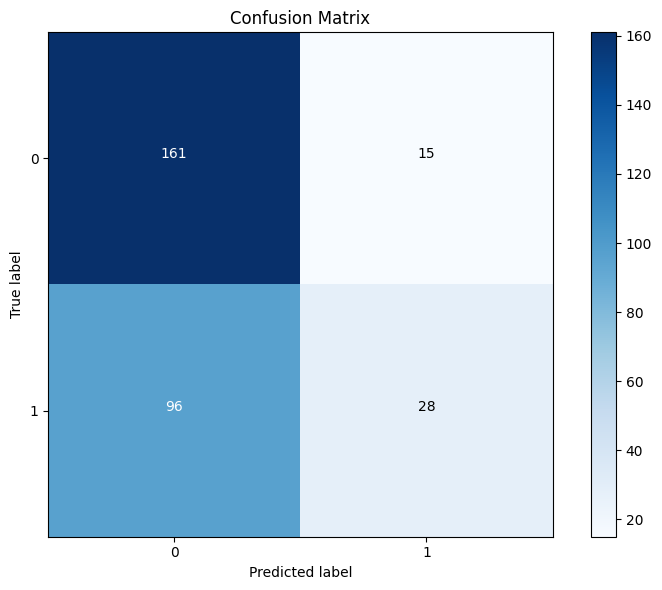

In [ ]:
evaluate(y_true, y_pred)